## A model build using TweetBERT to classify tweet as causal or non-causal 

- The causal sentence prediction model will be trained in several steps using an active learning approach, where in each step the training dataset will be augmented.
- In each step the causal sentence classifier is trained and applied on a subsample of unlabeled tweets to identify tweets with causal elements. 
- Those tweets are then manually labeled for the two tasks: causal sentence prediction and cause-effect identification (NER). 
- The newly labeled data will be added to the training dataset and the causal sentence classifier will be retrained with the augmented dataset to increase performance

In [1]:
import pandas as pd
import numpy as np
import spacy 
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import random
import os
import torch.nn.functional as F
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, SubsetRandomSampler
import transformers
from tqdm import tqdm, trange
import io
from utils import normalizeTweet, split_into_sentences, EarlyStopping
import matplotlib.pyplot as plt

########################### Check if cuda available ############################
# print("Cuda available: ", torch.cuda.is_available())
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


########################### DATA FILE ###################################
dataPath = "../data/Causality_tweets_data.xlsx"


########################### MODEL PARAMETERS ############################
lr = 1e-3    
adam_eps = 1e-8
epochs = 35  ## -----> CHANGE 
num_warmup_steps = 0
early_patience = 5 # how long to wait after last time validation loss improved

train_batch_size = 16
val_batch_size = 16
test_batch_size = 32
test_to_train_ratio = 0.1 # 10% test and 90% train
val_to_train_ratio = 0.2 

metrics_average = "binary" # this will give accuracy measure for class_1, i.e., causal class 

saveModelName = "../model_causal-sentences/model_0_finetuned-{}-epochs-lr_{}.pth".format(epochs, lr) ## it should be epoch so that the name shows at what epoch teh mdel ws saved

In [28]:
##### DATA TO LOAD ######

data = pd.read_excel(dataPath, sheet_name="round0")
data = data[data["Causal association"].notnull()] # some tweets at the end are not labeled yet
data = data[["full_text", "Intent", "Cause", "Effect", "Causal association"]]
print("Data (tweets!):")
print(data["Causal association"].value_counts())
print()

data.head()

Data (tweets!):
0.0    3710
1.0    1290
Name: Causal association, dtype: int64



,full_text,Intent,Cause,Effect,Causal association
0,"tonight , I learned my older girl will back he...",NaN,NaN,NaN,0.0
1,USER USER I knew diabetes and fibromyalgia wer...,joke,NaN,NaN,0.0
2,⬇ ️ ⬇ ️ ⬇ ️ THIS ⬇ ️ ⬇ ️ ⬇ ️ My wife has type ...,mS,NaN,NaN,0.0
3,USER Cheers ! Have one for this diabetic too !,mS,NaN,NaN,0.0
4,USER Additionally the medicines are being char...,NaN,medicines are being charged at MRP,costing much higher,1.0


### Checking if thec cuda is available adnd tehn select the `gpu`

In [29]:
########################### Check if cuda available ############################
print("Cuda available: ", torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Selected {} for this notebook".format(device))

Cuda available:  True
Selected cuda:0 for this notebook


### Preprocessing

In [30]:
def get_start_end_index_of_sentence_in_tweet(tweet, sentence):
    """ 
    The sentence tokens are included in the tweet tokens.
    Return the start end end indices of the sentence tokens in the tweet tokens

    """

    sentence_start_word = sentence[0]
    start_indices = [i for i, x in enumerate(tweet) if x == sentence_start_word] # find all indices of the start word of the sentence 
    try:
        for start_index in start_indices:
            isTrueStartIndex = all([tweet[start_index+i] == sentence[i] for i in range(len(sentence))])
            #print("start_index:", start_index, "isTrueStartIndex:", isTrueStartIndex)
            if isTrueStartIndex:
                return start_index, start_index + len(sentence) 
    except:
        print("ERROR: StartIndex should have been found for sentence:")
        print("tweet:")
        print(tweet)
        print("sentence:")
        print(sentence)
    return -1, -2 # should not be returned


def split_tweets_to_sentences(data):
    """ 
        Splits tweets into sentences and associates the appropriate intent, causes, effects and causal association
        to each sentence.
        
        Parameters:
        - min_words_in_sentences: Minimal number of words in a sentence such that the sentence is kept. 
                                  Assumption: A sentence with too few words does not have enough information
                              
                              
                              
        Ex.:
        full_text                              | Intent | Cause | Effect | Causal association | ...
        --------------------------------------------------------------------------------------------
        what? type 1 causes insulin dependence | q;msS  | type 1|insulin dependence | 1       | ...  
        
        New dataframe returned: 
        full_text                              | Intent | Cause | Effect | Causal association | ...
        --------------------------------------------------------------------------------------------
        what?                                  |   q    |       |        |       0            | ...
        type 1 causes insulin dependence       |        | type 1| insulin dependence | 1       | ...  
    """

    newDF = pd.DataFrame(columns=["sentence", "Intent", "Cause", "Effect", "Causal association", "tokenized"])
    
    for i,row in data.iterrows():
        causes = row["Cause"]
        effects = row["Effect"]
        sentences = split_into_sentences(normalizeTweet(row["full_text"]))
        
        # single sentence in tweet
        if len(sentences) == 1:
            singleSentenceIntent = ""
            if isinstance(row["Intent"], str):
                if len(row["Intent"].split(";")) > 1:
                    singleSentenceIntent = row["Intent"].strip().replace(";msS", "").replace("msS;", "").replace(";mS", "").replace("mS;", "")
                else:
                    if row["Intent"] == "mS" or row["Intent"] == "msS":
                        singleSentenceIntent = ""
                    else:
                        singleSentenceIntent = row["Intent"].strip()
                    
            newDF=newDF.append(pd.Series({"sentence": sentences[0] # only one sentence
                         , "Intent": singleSentenceIntent
                         , "Cause" : row["Cause"]
                         , "Effect": row["Effect"]
                         , "Causal association" : row["Causal association"]
                         , "tokenized": row["tokenized"]}), ignore_index=True)
        
        # tweet has several sentences
        else: 
            intents = str(row["Intent"]).strip().split(";")
            for sentence in sentences:
                sent_tokenized = sentence.split(" ")
                causeInSentence = np.nan if not isinstance(causes, str) or not any([cause in sentence for cause in causes.split(";")]) else ";".join([cause for cause in causes.split(";") if cause in sentence])
                effectInSentence = np.nan if not isinstance(effects, str) or not any([effect in sentence for effect in effects.split(";")]) else ";".join([effect for effect in effects.split(";") if effect in sentence])
                causalAssociationInSentence = 1 if isinstance(causeInSentence, str) and isinstance(effectInSentence, str) else 0
                startIndex, endIndex = get_start_end_index_of_sentence_in_tweet(row["tokenized"], sent_tokenized)
                sentence_tokenized = row["tokenized"][startIndex:endIndex]
                
                if "q" in intents and sentence[-1] == "?": # if current sentence is question
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": "q", "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)                    
                elif "joke" in intents: # all sentences with "joke" in tweet keep the intent "joke"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": "joke", "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)   
                elif "neg" in intents: # all sentences with "neg" in tweet keep intent "neg"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": "neg", "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)               
                elif isinstance(causeInSentence, str) and isinstance(effectInSentence, str): # cause effect sentence
                    causalIntent = ""
                    if len(causeInSentence.split(";")) > 1:
                        causalIntent = "mC"
                        if len(effectInSentence.split(";")) > 1:
                            causalIntent = "mC;mE"
                    elif len(effectInSentence.split(";")) > 1:
                        causalIntent = "mE"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": causalIntent, "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)                                  
                else:
                    nonCausalIntent = ""
                    if isinstance(causeInSentence, str): # only cause is given
                        if len(causeInSentence.split(";")) > 1:
                            nonCausalIntent = "mC"
                    elif isinstance(effectInSentence, str): # only effect is given
                        if len(effectInSentence.split(";")) > 1:
                            nonCausalIntent = "mE"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": nonCausalIntent, "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)

    return newDF

In [31]:
### Split tweets into sentences (train classifier on sentence level) ####

print("N tweets:", data.shape[0])

data["tokenized"] = data["full_text"].map(lambda tweet: normalizeTweet(tweet).split(" "))
dataSentences = split_tweets_to_sentences(data)
print("N sentences:", dataSentences.shape[0])
dataSentences.head()

N tweets: 5000
N sentences: 11756


,sentence,Intent,Cause,Effect,Causal association,tokenized
0,"tonight , I learned my older girl will back he...",,NaN,NaN,0,"[tonight, ,, I, learned, my, older, girl, will..."
1,Fiercely .,,NaN,NaN,0,"[Fiercely, .]"
2,#impressive #bigsister #type1 #type1times2,,NaN,NaN,0,"[#impressive, #bigsister, #type1, #type1times2]"
3,USER USER I knew diabetes and fibromyalgia wer...,joke,NaN,NaN,0,"[USER, USER, I, knew, diabetes, and, fibromyal..."
4,:face_with_rolling_eyes:,joke,NaN,NaN,0,[:face_with_rolling_eyes:]


In [32]:
########## Remove sentences with joke, question, negation and keep only sentences with more than 3 tokens #####

print("N sentences before filtering: ", dataSentences.shape[0])
dataSentFiltered = dataSentences[~dataSentences["Intent"].str.contains("neg|joke|q")] 
dataSentFiltered = dataSentFiltered[dataSentFiltered["tokenized"].map(len) > 3] 
print("N sentences after filtering: ", dataSentFiltered.shape[0])

print("Distribution:")
print(dataSentFiltered["Causal association"].value_counts())
dataSentFiltered.head()

N sentences before filtering:  11756
N sentences after filtering:  8368
Distribution:
0.0    7320
1.0    1048
Name: Causal association, dtype: int64


,sentence,Intent,Cause,Effect,Causal association,tokenized
0,"tonight , I learned my older girl will back he...",,NaN,NaN,0,"[tonight, ,, I, learned, my, older, girl, will..."
2,#impressive #bigsister #type1 #type1times2,,NaN,NaN,0,"[#impressive, #bigsister, #type1, #type1times2]"
5,:down_arrow: :down_arrow: :down_arrow: THIS :d...,,NaN,NaN,0,"[:down_arrow:, :down_arrow:, :down_arrow:, THI..."
6,I 'm a trans woman .,,NaN,NaN,0,"[I, 'm, a, trans, woman, .]"
7,"Both of us could use a world where "" brave and...",,NaN,NaN,0,"[Both, of, us, could, use, a, world, where, "",..."


### Training

In [33]:
####################### Stratified splits ####################


## ONLY FOR TESTING ---------------
#dataSentFiltered = dataSentFiltered[0:500] # for testing

text = dataSentFiltered["sentence"].map(normalizeTweet).values.tolist()
labels = dataSentFiltered["Causal association"].values.tolist()

# first split the data into training and testing label in the ratio of 90:10
train_texts, test_texts, train_labels, test_labels = train_test_split(text, labels, test_size=test_to_train_ratio, stratify=labels, random_state=9)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=val_to_train_ratio, stratify=train_labels, random_state=9)



data_count_info = pd.Series(labels).value_counts(normalize=True)
train_count_info = pd.Series(train_labels).value_counts(normalize=True)
val_count_info = pd.Series(val_labels).value_counts(normalize=True)
test_count_info = pd.Series(test_labels).value_counts(normalize=True)

# for class-imbalanced dataset, the class weight for a ith class
# to be specified for balancing in the loss function is given by:
# weight[i] = num_samples / (num_classes * num_samples[i])
# since train_count_info obtained above has fraction of samples
# for ith class, hence the corresponding weight calculation is:
class_weight = (1/train_count_info)/len(train_count_info)

print("All: Count = {}, % of 0 = {}, % of 1 = {}".format(
    len(labels), *data_count_info.round(4).to_list()))
print("Train: Count = {}, % of 0 = {}, % of 1 = {}".format(
    len(train_labels), *train_count_info.round(4).to_list()))
print("Val: Count = {}, % of 0 = {}, % of 1 = {}".format(
    len(val_labels), *val_count_info.round(4).to_list()))
print("Test: Count = {}, % of 0 = {}, % of 1 = {}".format(
    len(test_labels), *test_count_info.round(4).to_list()))
print("Balancing class wts: for 0 = {}, for 1 = {}".format(
    *class_weight.round(4).to_list()))

All: Count = 8368, % of 0 = 0.8748, % of 1 = 0.1252
Train: Count = 6024, % of 0 = 0.8748, % of 1 = 0.1252
Val: Count = 1507, % of 0 = 0.8746, % of 1 = 0.1254
Test: Count = 837, % of 0 = 0.8746, % of 1 = 0.1254
Balancing class wts: for 0 = 0.5715, for 1 = 3.9947


In [34]:
class TweetDataSet(torch.utils.data.Dataset):
    def __init__(self, text, labels, tokenizer):
        self.text = text
        self.labels = labels
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        inputs = self.tokenizer(self.text, padding=True, truncation=True, return_token_type_ids=True)
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]
        return {
                "input_ids" : torch.tensor(ids[idx], dtype=torch.long)
              , "attention_mask" : torch.tensor(mask[idx], dtype=torch.long)
              , "token_type_ids" : torch.tensor(token_type_ids[idx], dtype=torch.long)
              , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
        }      

    def __len__(self):
        return len(self.labels)

    
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")

train_dataset = TweetDataSet(train_texts, train_labels, tokenizer)
val_dataset = TweetDataSet(val_texts, val_labels, tokenizer)
test_dataset = TweetDataSet(test_texts, test_labels, tokenizer)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

# During training: In each epoch one part of the training data will be used as validation set
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


6024
1507
837


## Evaluation metrics

In [35]:
## we are measuring weighted metrics - as our dataset is imbalanced 
# Calculate metrics for each label, and find their average weighted by support
# (the number of true instances for each label). 
# This alters ‘macro’ to account for label imbalance; 
# it can result in an F-score that is not between precision and recall.


from sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef

def compute_metrics(pred, labels):
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred, average=metrics_average)
    acc = accuracy_score(labels, pred)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


### Model defintion

In [36]:

class CausalityBERT(torch.nn.Module):
    """ Model Bert"""
    def __init__(self):
        super(CausalityBERT, self).__init__()
        self.num_labels = 2
        self.bert = transformers.BertModel.from_pretrained("vinai/bertweet-base")
        self.dropout = torch.nn.Dropout(0.3)
        self.linear1 = torch.nn.Linear(768, 256)
        self.linear2 = torch.nn.Linear(256, self.num_labels)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, output_1 = self.bert(input_ids, attention_mask = attention_mask, token_type_ids=token_type_ids, return_dict=False) # if output 1 is our cls token        
        output_2 = self.dropout(output_1)
        output_3 = self.linear1(output_2)  
        output_4 = self.dropout(output_3)
        output_5 = self.linear2(output_4)
        return output_5



    


In [37]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device selected in the begining 
model = CausalityBERT()
model.to(device)

# fine-tune only the task-specific parameters
for param in model.bert.parameters():
    param.requires_grad = False

num_training_steps = np.ceil(len(train_dataset)/train_batch_size)*epochs
optim = AdamW(model.parameters(), lr=lr, eps=adam_eps)
scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps) # scheduler with a linearly decreasing learning rate from the initial lr set in the optimizer to 0; after a warmup period durnig which it increases linearly from 0 to the initial lr set in the optimizer

## penalising more for class with less number of exaplmes 
loss_fn = CrossEntropyLoss(torch.tensor(class_weight.to_list()).to(device))

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing BertModel: ['roberta.encoder.layer.11.output.LayerNorm.weight', 'lm_head.decoder.bias', 'roberta.encoder.layer.1.intermediate.dense.bias', 'roberta.encoder.layer.9.attention.output.LayerNorm.weight', 'roberta.encoder.layer.8.output.dense.bias', 'roberta.encoder.layer.5.attention.output.LayerNorm.weight', 'roberta.encoder.layer.5.intermediate.dense.weight', 'roberta.encoder.layer.11.attention.output.dense.bias', 'roberta.encoder.layer.2.attention.self.key.weight', 'roberta.encoder.layer.7.attention.self.key.weight', 'roberta.encoder.layer.0.output.dense.weight', 'roberta.encoder.layer.9.attention.self.query.weight', 'roberta.encoder.layer.1.attention.self.key.bias', 'lm_head.decoder.weight', 'roberta.encoder.layer.4.output.LayerNorm.weight', 'robe

In [38]:
############ TRAINING #############

# initialise the early_stopping object
early_stopping = EarlyStopping(patience=early_patience, path=saveModelName, verbose=True)

train_avg_loss = [] # avg training loss per epoch
val_avg_loss = [] # avg validation loss per epoch
train_avg_acc = [] # avg training accuracy per epoch
val_avg_acc = [] # avg val accuracy per epoch
n_trained_epochs = 0

import time

start = time.time()
for epoch in trange(1, epochs+1, desc='Epoch'):
    print("<" + "="*22 + F" Epoch {epoch} "+ "="*22 + ">")
    
    
    ########### training eval metrics #############################
    train_accuracy = []
    train_loss = []
    train_acc = []
    train_prec = []
    train_rec = []
    train_f1 = []
    
    ###################################################
    
    for batch in tqdm(train_loader):
        optim.zero_grad() # gradients get accumulated by default -> clear previous accumulated gradients
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels = batch['labels'].to(device)
        ###########################################################################
        model.train()
        logits = model(**{"input_ids":input_ids, "attention_mask":attention_mask, "token_type_ids":token_type_ids}) # forward pass
        #############################################################################
        loss = loss_fn(logits, labels)
        print("loss:", loss)
        loss.backward() # backward pass
        optim.step()    # update parameters and take a step up using the computed gradient
        scheduler.step()# update learning rate scheduler
        train_loss.append(loss.item())
        
    
        ############# Training Accuracy Measure ###################################

        # move logits and labels to CPU
        logits = logits.detach().to('cpu').numpy()
        label_ids = labels.to('cpu').numpy()

        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()

        metrics = compute_metrics(pred_flat, labels_flat)        
        
        train_acc.append(metrics["accuracy"])
        train_prec.append(metrics["precision"])
        train_rec.append(metrics["recall"])
        train_f1.append(metrics["f1"])
        
    train_avg_loss.append(np.mean(train_loss))
    train_avg_acc.append(np.mean(train_acc))
    print(F'\n\tTrain loss: {np.mean(train_loss)}')
    print(F'\n\ttrain acc: {np.mean(train_acc)}')
    print(F'\n\ttraining prec: {np.mean(train_prec)}')
    print(F'\n\ttraining rec: {np.mean(train_rec)}')
    print(F'\n\ttraining f1: {np.mean(train_f1)}')
    
    n_trained_epochs += 1
    
    ###################################################################################

    
    ## ---- Validation ------
    val_accuracy = []
    val_loss = []
    val_acc = []
    val_prec = []
    val_rec = []
    val_f1 = []
    
    
    # Evaluate data for one epoch
    for batch in tqdm(validation_loader):
        batch = tuple(batch[t].to(device) for t in batch)      # batch to GPU
        b_input_ids, b_input_mask, b_token_type_ids, b_labels = batch     # unpack inputs from dataloader
        
        with torch.no_grad(): # tell model not to compute or store gradients -> saves memory + speeds up validation
            ##################################################################################
            model.eval()
            logits = model(**{"input_ids":b_input_ids, "attention_mask":b_input_mask, "token_type_ids":b_token_type_ids}) # forward pass, calculates logit predictions 

                        
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())
        
        # move logits and labels to CPU
        logits = logits.detach().to('cpu').numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        
        metrics = compute_metrics(pred_flat, labels_flat)
        val_acc.append(metrics["accuracy"])
        val_prec.append(metrics["precision"])
        val_rec.append(metrics["recall"])
        val_f1.append(metrics["f1"])

    val_avg_loss.append(np.mean(val_loss))
    val_avg_acc.append(np.mean(val_acc))
    print(F'\n\tValidation loss: {np.mean(val_loss)}')
    print(F'\n\tValidation acc: {np.mean(val_acc)}')
    print(F'\n\tValidation prec: {np.mean(val_prec)}')
    print(F'\n\tValidation rec: {np.mean(val_rec)}')
    print(F'\n\tValidation f1: {np.mean(val_f1)}')

    # early_stopping needs the validation loss to check if it has decreased,
    # and if it has, it will make a checkpoint of the current model
    early_stopping(np.average(val_loss), model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break
        

Epoch:   0%|          | 0/35 [00:00<?, ?it/s]

<====================== Epoch 1 ======================>



  0%|          | 0/377 [00:00<?, ?it/s]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  0%|          | 1/377 [00:06<40:46,  6.51s/it]

loss: tensor(0.6185, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 2/377 [00:12<39:54,  6.39s/it]

loss: tensor(0.8838, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 3/377 [00:18<38:56,  6.25s/it]

loss: tensor(0.8169, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|          | 4/377 [00:24<38:25,  6.18s/it]

loss: tensor(0.5245, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|▏         | 5/377 [00:31<38:58,  6.29s/it]

loss: tensor(1.7837, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 6/377 [00:37<39:14,  6.35s/it]

loss: tensor(1.0042, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 7/377 [00:44<38:46,  6.29s/it]

loss: tensor(0.3861, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 8/377 [00:50<38:03,  6.19s/it]

loss: tensor(0.8153, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 9/377 [00:56<38:12,  6.23s/it]

loss: tensor(0.6522, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 10/377 [01:02<38:22,  6.27s/it]

loss: tensor(0.7513, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 11/377 [01:08<37:54,  6.21s/it]

loss: tensor(0.6274, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 12/377 [01:15<37:53,  6.23s/it]

loss: tensor(0.6737, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 13/377 [01:21<37:29,  6.18s/it]

loss: tensor(0.5293, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▎         | 14/377 [01:27<37:13,  6.15s/it]

loss: tensor(0.5279, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 15/377 [01:33<36:51,  6.11s/it]

loss: tensor(1.1170, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 16/377 [01:39<36:39,  6.09s/it]

loss: tensor(0.7107, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▍         | 17/377 [01:45<36:29,  6.08s/it]

loss: tensor(0.6291, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▍         | 18/377 [01:51<36:30,  6.10s/it]

loss: tensor(0.7936, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▌         | 19/377 [01:57<36:26,  6.11s/it]

loss: tensor(0.8270, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▌         | 20/377 [02:04<36:52,  6.20s/it]

loss: tensor(0.6215, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 21/377 [02:10<36:30,  6.15s/it]

loss: tensor(0.7194, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 22/377 [02:16<36:30,  6.17s/it]

loss: tensor(0.6054, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  6%|▌         | 23/377 [02:22<36:44,  6.23s/it]

loss: tensor(0.4866, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  6%|▋         | 24/377 [02:29<36:54,  6.27s/it]

loss: tensor(0.9034, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 25/377 [02:35<36:44,  6.26s/it]

loss: tensor(0.7722, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 26/377 [02:41<36:11,  6.19s/it]

loss: tensor(0.5988, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 27/377 [02:47<35:50,  6.14s/it]

loss: tensor(0.5197, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 28/377 [02:53<35:40,  6.13s/it]

loss: tensor(0.6421, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 29/377 [02:59<35:21,  6.10s/it]

loss: tensor(0.7006, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 30/377 [03:05<35:13,  6.09s/it]

loss: tensor(0.4703, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 31/377 [03:11<35:04,  6.08s/it]

loss: tensor(0.6876, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 32/377 [03:17<35:26,  6.17s/it]

loss: tensor(0.7108, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 33/377 [03:24<35:19,  6.16s/it]

loss: tensor(0.5197, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 34/377 [03:30<35:04,  6.13s/it]

loss: tensor(0.5717, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 35/377 [03:36<34:53,  6.12s/it]

loss: tensor(0.7498, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 36/377 [03:42<34:38,  6.09s/it]

loss: tensor(0.8391, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 37/377 [03:48<34:32,  6.10s/it]

loss: tensor(0.8724, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 38/377 [03:54<34:13,  6.06s/it]

loss: tensor(0.6071, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 10%|█         | 39/377 [04:00<33:54,  6.02s/it]

loss: tensor(0.5557, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 40/377 [04:06<33:36,  5.98s/it]

loss: tensor(0.9086, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 41/377 [04:12<33:38,  6.01s/it]

loss: tensor(1.3540, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 42/377 [04:18<33:47,  6.05s/it]

loss: tensor(0.1423, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█▏        | 43/377 [04:24<33:42,  6.06s/it]

loss: tensor(0.8245, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 12%|█▏        | 44/377 [04:30<33:47,  6.09s/it]

loss: tensor(1.0758, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 12%|█▏        | 45/377 [04:36<33:44,  6.10s/it]

loss: tensor(0.4618, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 46/377 [04:43<34:03,  6.17s/it]

loss: tensor(0.8183, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 47/377 [04:49<34:14,  6.23s/it]

loss: tensor(0.7511, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 48/377 [04:55<34:11,  6.23s/it]

loss: tensor(0.6680, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 49/377 [05:02<34:22,  6.29s/it]

loss: tensor(0.6561, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 50/377 [05:08<34:13,  6.28s/it]

loss: tensor(0.6548, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▎        | 51/377 [05:14<33:44,  6.21s/it]

loss: tensor(0.8801, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 52/377 [05:20<33:35,  6.20s/it]

loss: tensor(0.5030, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 53/377 [05:26<33:33,  6.21s/it]

loss: tensor(0.8651, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 54/377 [05:33<33:34,  6.24s/it]

loss: tensor(0.7004, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▍        | 55/377 [05:39<33:17,  6.20s/it]

loss: tensor(0.6078, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 15%|█▍        | 56/377 [05:45<32:59,  6.17s/it]

loss: tensor(0.9627, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 57/377 [05:51<32:56,  6.18s/it]

loss: tensor(0.5573, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 58/377 [05:57<32:35,  6.13s/it]

loss: tensor(0.7432, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 59/377 [06:03<32:26,  6.12s/it]

loss: tensor(0.6009, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 16%|█▌        | 60/377 [06:09<32:24,  6.14s/it]

loss: tensor(0.7146, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 61/377 [06:16<32:40,  6.20s/it]

loss: tensor(0.5808, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▋        | 62/377 [06:22<32:49,  6.25s/it]

loss: tensor(0.8589, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 17%|█▋        | 63/377 [06:28<32:48,  6.27s/it]

loss: tensor(0.6548, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 64/377 [06:35<32:50,  6.30s/it]

loss: tensor(0.8603, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 65/377 [06:41<32:40,  6.28s/it]

loss: tensor(0.8861, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 66/377 [06:47<32:34,  6.28s/it]

loss: tensor(0.4714, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 67/377 [06:54<32:29,  6.29s/it]

loss: tensor(0.6298, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 68/377 [07:00<32:24,  6.29s/it]

loss: tensor(0.7981, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 69/377 [07:06<32:04,  6.25s/it]

loss: tensor(0.5259, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▊        | 70/377 [07:12<31:52,  6.23s/it]

loss: tensor(0.6674, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 71/377 [07:18<31:47,  6.23s/it]

loss: tensor(0.5449, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 72/377 [07:25<31:34,  6.21s/it]

loss: tensor(0.9969, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 73/377 [07:31<31:49,  6.28s/it]

loss: tensor(0.6112, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|█▉        | 74/377 [07:37<31:46,  6.29s/it]

loss: tensor(0.9005, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 75/377 [07:44<31:44,  6.31s/it]

loss: tensor(0.5627, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|██        | 76/377 [07:50<31:35,  6.30s/it]

loss: tensor(0.8681, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 77/377 [07:56<31:30,  6.30s/it]

loss: tensor(0.8288, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 21%|██        | 78/377 [08:03<31:26,  6.31s/it]

loss: tensor(1.1467, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 79/377 [08:09<31:07,  6.27s/it]

loss: tensor(0.6071, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 80/377 [08:15<31:03,  6.27s/it]

loss: tensor(0.7806, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 21%|██▏       | 81/377 [08:21<30:49,  6.25s/it]

loss: tensor(0.3530, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 82/377 [08:28<31:02,  6.31s/it]

loss: tensor(1.0462, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 83/377 [08:34<31:10,  6.36s/it]

loss: tensor(0.7145, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 84/377 [08:41<31:10,  6.38s/it]

loss: tensor(0.6450, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 85/377 [08:47<31:04,  6.38s/it]

loss: tensor(0.7704, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 86/377 [08:53<30:49,  6.35s/it]

loss: tensor(0.5742, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 87/377 [09:00<30:36,  6.33s/it]

loss: tensor(0.7492, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 88/377 [09:06<30:30,  6.33s/it]

loss: tensor(0.6924, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 24%|██▎       | 89/377 [09:12<30:08,  6.28s/it]

loss: tensor(0.6426, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 90/377 [09:18<29:55,  6.25s/it]

loss: tensor(0.5991, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 91/377 [09:25<29:56,  6.28s/it]

loss: tensor(0.6435, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 92/377 [09:31<29:51,  6.29s/it]

loss: tensor(0.7273, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▍       | 93/377 [09:37<29:35,  6.25s/it]

loss: tensor(0.5286, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▍       | 94/377 [09:43<29:23,  6.23s/it]

loss: tensor(0.6121, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 95/377 [09:49<29:06,  6.19s/it]

loss: tensor(0.5686, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 96/377 [09:56<28:54,  6.17s/it]

loss: tensor(0.6599, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▌       | 97/377 [10:02<28:44,  6.16s/it]

loss: tensor(0.6661, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▌       | 98/377 [10:08<28:35,  6.15s/it]

loss: tensor(0.5129, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▋       | 99/377 [10:14<28:27,  6.14s/it]

loss: tensor(0.5821, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 100/377 [10:20<28:08,  6.10s/it]

loss: tensor(0.5701, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 27%|██▋       | 101/377 [10:26<27:55,  6.07s/it]

loss: tensor(0.8963, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 27%|██▋       | 102/377 [10:32<27:54,  6.09s/it]

loss: tensor(0.8606, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 103/377 [10:38<28:14,  6.19s/it]

loss: tensor(0.5730, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 28%|██▊       | 104/377 [10:45<28:21,  6.23s/it]

loss: tensor(0.5174, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 28%|██▊       | 105/377 [10:51<28:25,  6.27s/it]

loss: tensor(0.9866, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 106/377 [10:58<28:33,  6.32s/it]

loss: tensor(0.9853, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 28%|██▊       | 107/377 [11:04<28:36,  6.36s/it]

loss: tensor(0.9012, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▊       | 108/377 [11:10<28:24,  6.34s/it]

loss: tensor(0.6395, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 109/377 [11:17<28:25,  6.36s/it]

loss: tensor(0.9334, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 110/377 [11:23<28:26,  6.39s/it]

loss: tensor(0.8411, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 111/377 [11:30<28:14,  6.37s/it]

loss: tensor(0.6440, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 112/377 [11:36<28:06,  6.36s/it]

loss: tensor(0.5321, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 113/377 [11:42<27:57,  6.35s/it]

loss: tensor(0.5878, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 30%|███       | 114/377 [11:48<27:46,  6.33s/it]

loss: tensor(1.1094, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 115/377 [11:55<27:47,  6.36s/it]

loss: tensor(0.7971, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 31%|███       | 116/377 [12:01<27:38,  6.36s/it]

loss: tensor(0.9286, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 117/377 [12:08<27:33,  6.36s/it]

loss: tensor(0.7532, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███▏      | 118/377 [12:14<27:27,  6.36s/it]

loss: tensor(0.6843, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 119/377 [12:20<27:22,  6.37s/it]

loss: tensor(0.6198, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 120/377 [12:27<27:17,  6.37s/it]

loss: tensor(0.6442, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 32%|███▏      | 121/377 [12:33<27:07,  6.36s/it]

loss: tensor(0.7357, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 32%|███▏      | 122/377 [12:39<26:54,  6.33s/it]

loss: tensor(0.4501, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 123/377 [12:46<26:43,  6.31s/it]

loss: tensor(1.1206, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 124/377 [12:52<26:36,  6.31s/it]

loss: tensor(0.6965, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 125/377 [12:58<26:06,  6.22s/it]

loss: tensor(0.7174, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 126/377 [13:04<25:43,  6.15s/it]

loss: tensor(0.5720, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 34%|███▎      | 127/377 [13:10<25:30,  6.12s/it]

loss: tensor(1.0141, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 128/377 [13:16<25:24,  6.12s/it]

loss: tensor(0.6369, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 129/377 [13:22<25:30,  6.17s/it]

loss: tensor(0.4682, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 130/377 [13:29<25:54,  6.29s/it]

loss: tensor(0.8618, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 35%|███▍      | 131/377 [13:35<25:37,  6.25s/it]

loss: tensor(0.6624, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 35%|███▌      | 132/377 [13:41<25:23,  6.22s/it]

loss: tensor(0.8601, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 133/377 [13:48<25:35,  6.29s/it]

loss: tensor(0.5370, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 134/377 [13:54<25:20,  6.26s/it]

loss: tensor(0.5389, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 135/377 [14:00<24:57,  6.19s/it]

loss: tensor(0.6921, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 136/377 [14:06<24:43,  6.15s/it]

loss: tensor(0.4859, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 36%|███▋      | 137/377 [14:12<24:25,  6.11s/it]

loss: tensor(0.6803, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 138/377 [14:18<24:26,  6.14s/it]

loss: tensor(0.5243, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 139/377 [14:25<24:44,  6.24s/it]

loss: tensor(0.7968, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 140/377 [14:31<24:43,  6.26s/it]

loss: tensor(0.5051, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 141/377 [14:37<24:27,  6.22s/it]

loss: tensor(0.5091, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 142/377 [14:43<24:07,  6.16s/it]

loss: tensor(0.9146, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 143/377 [14:49<23:56,  6.14s/it]

loss: tensor(0.7001, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 144/377 [14:56<24:04,  6.20s/it]

loss: tensor(0.5391, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 145/377 [15:02<24:09,  6.25s/it]

loss: tensor(0.4790, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▊      | 146/377 [15:08<24:02,  6.24s/it]

loss: tensor(0.5673, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 147/377 [15:14<23:46,  6.20s/it]

loss: tensor(0.6022, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 148/377 [15:20<23:36,  6.19s/it]

loss: tensor(0.6860, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 149/377 [15:26<23:19,  6.14s/it]

loss: tensor(0.7022, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 150/377 [15:33<23:26,  6.20s/it]

loss: tensor(0.5846, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|████      | 151/377 [15:39<23:32,  6.25s/it]

loss: tensor(0.5663, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|████      | 152/377 [15:46<23:37,  6.30s/it]

loss: tensor(0.8551, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 153/377 [15:52<23:30,  6.30s/it]

loss: tensor(0.6955, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 154/377 [15:58<23:12,  6.24s/it]

loss: tensor(0.6119, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 41%|████      | 155/377 [16:04<23:01,  6.22s/it]

loss: tensor(0.6764, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 41%|████▏     | 156/377 [16:10<22:45,  6.18s/it]

loss: tensor(0.5452, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 157/377 [16:16<22:37,  6.17s/it]

loss: tensor(0.6255, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 158/377 [16:23<22:31,  6.17s/it]

loss: tensor(0.6785, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 159/377 [16:29<22:25,  6.17s/it]

loss: tensor(0.6810, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 160/377 [16:35<22:18,  6.17s/it]

loss: tensor(0.8703, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 161/377 [16:41<22:12,  6.17s/it]

loss: tensor(0.8065, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 162/377 [16:47<22:05,  6.16s/it]

loss: tensor(0.7527, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 43%|████▎     | 163/377 [16:53<21:46,  6.11s/it]

loss: tensor(0.5188, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▎     | 164/377 [16:59<21:39,  6.10s/it]

loss: tensor(0.5642, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 165/377 [17:05<21:30,  6.09s/it]

loss: tensor(0.7122, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 166/377 [17:11<21:26,  6.10s/it]

loss: tensor(0.5342, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 167/377 [17:18<21:24,  6.12s/it]

loss: tensor(0.6058, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▍     | 168/377 [17:24<21:19,  6.12s/it]

loss: tensor(0.6806, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▍     | 169/377 [17:30<21:16,  6.14s/it]

loss: tensor(0.7701, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 170/377 [17:36<20:59,  6.08s/it]

loss: tensor(0.7956, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 171/377 [17:42<20:53,  6.08s/it]

loss: tensor(0.8760, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 172/377 [17:48<20:46,  6.08s/it]

loss: tensor(0.6042, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 173/377 [17:54<20:36,  6.06s/it]

loss: tensor(0.7808, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 174/377 [18:00<20:42,  6.12s/it]

loss: tensor(0.7021, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▋     | 175/377 [18:07<20:50,  6.19s/it]

loss: tensor(0.7025, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 176/377 [18:13<20:54,  6.24s/it]

loss: tensor(0.5783, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 177/377 [18:19<20:45,  6.23s/it]

loss: tensor(0.7071, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 47%|████▋     | 178/377 [18:25<20:40,  6.23s/it]

loss: tensor(0.8271, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 179/377 [18:32<20:39,  6.26s/it]

loss: tensor(0.6248, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 180/377 [18:38<20:39,  6.29s/it]

loss: tensor(0.6567, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 181/377 [18:44<20:36,  6.31s/it]

loss: tensor(0.5388, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 48%|████▊     | 182/377 [18:51<20:31,  6.31s/it]

loss: tensor(0.7010, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 49%|████▊     | 183/377 [18:57<20:26,  6.32s/it]

loss: tensor(0.6776, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 49%|████▉     | 184/377 [19:04<20:24,  6.34s/it]

loss: tensor(0.9024, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 49%|████▉     | 185/377 [19:10<20:24,  6.38s/it]

loss: tensor(1.0359, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 186/377 [19:16<20:17,  6.38s/it]

loss: tensor(0.5470, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|████▉     | 187/377 [19:23<20:07,  6.35s/it]

loss: tensor(0.8224, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|████▉     | 188/377 [19:29<19:56,  6.33s/it]

loss: tensor(0.8063, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 189/377 [19:35<19:43,  6.30s/it]

loss: tensor(0.6966, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|█████     | 190/377 [19:41<19:22,  6.22s/it]

loss: tensor(0.8633, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 51%|█████     | 191/377 [19:47<18:57,  6.12s/it]

loss: tensor(1.0616, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 51%|█████     | 192/377 [19:53<18:44,  6.08s/it]

loss: tensor(0.9556, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 193/377 [19:59<18:33,  6.05s/it]

loss: tensor(0.9109, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████▏    | 194/377 [20:05<18:25,  6.04s/it]

loss: tensor(0.7116, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 195/377 [20:11<18:13,  6.01s/it]

loss: tensor(0.6275, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 196/377 [20:17<18:02,  5.98s/it]

loss: tensor(0.6539, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 197/377 [20:23<17:53,  5.96s/it]

loss: tensor(0.5853, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 198/377 [20:29<17:39,  5.92s/it]

loss: tensor(0.6619, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 53%|█████▎    | 199/377 [20:35<17:33,  5.92s/it]

loss: tensor(0.2905, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 53%|█████▎    | 200/377 [20:41<17:28,  5.92s/it]

loss: tensor(0.6365, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 53%|█████▎    | 201/377 [20:46<17:24,  5.93s/it]

loss: tensor(0.5660, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 54%|█████▎    | 202/377 [20:53<17:30,  6.00s/it]

loss: tensor(0.1917, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 54%|█████▍    | 203/377 [20:59<17:31,  6.04s/it]

loss: tensor(0.6280, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 54%|█████▍    | 204/377 [21:05<17:28,  6.06s/it]

loss: tensor(0.9972, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 54%|█████▍    | 205/377 [21:11<17:25,  6.08s/it]

loss: tensor(0.5262, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 55%|█████▍    | 206/377 [21:17<17:38,  6.19s/it]

loss: tensor(0.3504, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 55%|█████▍    | 207/377 [21:24<17:27,  6.16s/it]

loss: tensor(0.9426, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 55%|█████▌    | 208/377 [21:30<17:22,  6.17s/it]

loss: tensor(0.4864, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 55%|█████▌    | 209/377 [21:36<17:17,  6.18s/it]

loss: tensor(0.2468, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 210/377 [21:42<17:13,  6.19s/it]

loss: tensor(0.6614, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 56%|█████▌    | 211/377 [21:48<17:06,  6.19s/it]

loss: tensor(0.4604, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 212/377 [21:54<16:54,  6.15s/it]

loss: tensor(0.3894, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▋    | 213/377 [22:01<16:49,  6.15s/it]

loss: tensor(0.5295, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 214/377 [22:07<16:44,  6.16s/it]

loss: tensor(0.5322, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 215/377 [22:13<16:39,  6.17s/it]

loss: tensor(0.4631, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 216/377 [22:19<16:34,  6.18s/it]

loss: tensor(0.7755, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 217/377 [22:25<16:29,  6.19s/it]

loss: tensor(0.5541, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 218/377 [22:32<16:25,  6.20s/it]

loss: tensor(0.5327, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 219/377 [22:38<16:13,  6.16s/it]

loss: tensor(0.7943, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 220/377 [22:44<16:03,  6.14s/it]

loss: tensor(0.6017, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 59%|█████▊    | 221/377 [22:50<16:01,  6.16s/it]

loss: tensor(0.6435, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 222/377 [22:56<15:57,  6.18s/it]

loss: tensor(0.5712, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 223/377 [23:02<15:59,  6.23s/it]

loss: tensor(0.5784, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 224/377 [23:09<16:07,  6.32s/it]

loss: tensor(0.6718, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|█████▉    | 225/377 [23:16<16:09,  6.38s/it]

loss: tensor(0.7183, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|█████▉    | 226/377 [23:22<15:51,  6.30s/it]

loss: tensor(0.4933, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 60%|██████    | 227/377 [23:28<15:41,  6.28s/it]

loss: tensor(0.4909, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 60%|██████    | 228/377 [23:34<15:30,  6.25s/it]

loss: tensor(0.5387, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 229/377 [23:40<15:28,  6.27s/it]

loss: tensor(0.5845, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 61%|██████    | 230/377 [23:47<15:23,  6.28s/it]

loss: tensor(0.2780, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████▏   | 231/377 [23:53<15:18,  6.29s/it]

loss: tensor(0.8311, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 232/377 [24:00<15:24,  6.38s/it]

loss: tensor(0.8509, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 62%|██████▏   | 233/377 [24:06<15:06,  6.30s/it]

loss: tensor(0.5516, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 234/377 [24:12<14:55,  6.26s/it]

loss: tensor(0.4609, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 62%|██████▏   | 235/377 [24:18<14:47,  6.25s/it]

loss: tensor(0.4900, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 63%|██████▎   | 236/377 [24:24<14:44,  6.28s/it]

loss: tensor(0.6708, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 237/377 [24:31<14:50,  6.36s/it]

loss: tensor(0.7154, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 238/377 [24:37<14:38,  6.32s/it]

loss: tensor(0.4039, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 239/377 [24:43<14:28,  6.29s/it]

loss: tensor(1.0058, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▎   | 240/377 [24:49<14:11,  6.22s/it]

loss: tensor(0.7224, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 241/377 [24:56<14:01,  6.19s/it]

loss: tensor(0.3500, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 242/377 [25:02<13:51,  6.16s/it]

loss: tensor(0.4904, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 243/377 [25:08<13:42,  6.14s/it]

loss: tensor(0.5288, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 244/377 [25:14<13:33,  6.12s/it]

loss: tensor(0.6095, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 245/377 [25:20<13:26,  6.11s/it]

loss: tensor(0.7709, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▌   | 246/377 [25:26<13:20,  6.11s/it]

loss: tensor(0.6359, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 247/377 [25:32<13:07,  6.06s/it]

loss: tensor(0.6160, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 248/377 [25:38<13:01,  6.05s/it]

loss: tensor(0.6170, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 249/377 [25:44<12:54,  6.05s/it]

loss: tensor(0.6933, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▋   | 250/377 [25:50<12:49,  6.06s/it]

loss: tensor(0.6565, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 251/377 [25:56<12:43,  6.06s/it]

loss: tensor(0.7203, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 252/377 [26:02<12:45,  6.12s/it]

loss: tensor(0.7722, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 253/377 [26:09<12:44,  6.17s/it]

loss: tensor(0.5257, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 254/377 [26:15<12:39,  6.17s/it]

loss: tensor(0.5984, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 68%|██████▊   | 255/377 [26:21<12:34,  6.18s/it]

loss: tensor(0.7398, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 256/377 [26:27<12:28,  6.18s/it]

loss: tensor(0.8977, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 257/377 [26:33<12:17,  6.15s/it]

loss: tensor(0.6378, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 258/377 [26:40<12:09,  6.13s/it]

loss: tensor(0.8476, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▊   | 259/377 [26:46<12:04,  6.14s/it]

loss: tensor(0.5840, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 260/377 [26:52<11:54,  6.10s/it]

loss: tensor(0.5728, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 261/377 [26:58<11:41,  6.04s/it]

loss: tensor(0.6900, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 262/377 [27:04<11:33,  6.03s/it]

loss: tensor(0.7647, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|██████▉   | 263/377 [27:10<11:26,  6.03s/it]

loss: tensor(0.8415, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 264/377 [27:16<11:21,  6.03s/it]

loss: tensor(0.4977, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 265/377 [27:22<11:14,  6.03s/it]

loss: tensor(0.5587, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 266/377 [27:28<11:08,  6.02s/it]

loss: tensor(0.6491, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 267/377 [27:34<11:05,  6.05s/it]

loss: tensor(0.7561, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 268/377 [27:40<10:56,  6.03s/it]

loss: tensor(0.7758, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████▏  | 269/377 [27:46<10:54,  6.06s/it]

loss: tensor(0.6047, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 270/377 [27:52<10:53,  6.10s/it]

loss: tensor(0.4528, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 271/377 [27:58<10:50,  6.14s/it]

loss: tensor(0.6946, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 272/377 [28:04<10:41,  6.11s/it]

loss: tensor(0.7291, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 273/377 [28:10<10:35,  6.11s/it]

loss: tensor(0.7071, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 274/377 [28:16<10:25,  6.08s/it]

loss: tensor(0.7277, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 275/377 [28:22<10:14,  6.02s/it]

loss: tensor(0.4240, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 276/377 [28:28<10:07,  6.02s/it]

loss: tensor(0.8002, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 277/377 [28:34<10:02,  6.02s/it]

loss: tensor(0.7323, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▎  | 278/377 [28:41<10:01,  6.07s/it]

loss: tensor(0.5506, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 279/377 [28:47<09:53,  6.06s/it]

loss: tensor(0.5593, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 280/377 [28:53<09:49,  6.07s/it]

loss: tensor(0.4793, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 281/377 [28:59<09:43,  6.08s/it]

loss: tensor(0.6336, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 282/377 [29:05<09:35,  6.05s/it]

loss: tensor(0.4965, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 75%|███████▌  | 283/377 [29:11<09:29,  6.06s/it]

loss: tensor(0.6405, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▌  | 284/377 [29:17<09:21,  6.04s/it]

loss: tensor(0.8762, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 285/377 [29:23<09:14,  6.03s/it]

loss: tensor(0.5270, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 286/377 [29:29<09:08,  6.02s/it]

loss: tensor(0.8154, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 287/377 [29:35<09:02,  6.02s/it]

loss: tensor(0.6365, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▋  | 288/377 [29:41<08:56,  6.03s/it]

loss: tensor(0.5945, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 77%|███████▋  | 289/377 [29:47<08:47,  5.99s/it]

loss: tensor(0.5282, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 290/377 [29:53<08:41,  6.00s/it]

loss: tensor(0.8767, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 291/377 [29:59<08:35,  6.00s/it]

loss: tensor(0.7620, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 292/377 [30:05<08:32,  6.02s/it]

loss: tensor(0.6738, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 293/377 [30:11<08:30,  6.08s/it]

loss: tensor(0.6900, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 294/377 [30:17<08:26,  6.10s/it]

loss: tensor(0.6558, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 295/377 [30:23<08:20,  6.10s/it]

loss: tensor(0.6335, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▊  | 296/377 [30:29<08:10,  6.06s/it]

loss: tensor(0.4214, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 297/377 [30:35<08:03,  6.04s/it]

loss: tensor(0.4748, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 298/377 [30:41<07:56,  6.03s/it]

loss: tensor(0.8149, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 299/377 [30:47<07:49,  6.02s/it]

loss: tensor(1.0121, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 300/377 [30:53<07:43,  6.02s/it]

loss: tensor(0.5245, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 80%|███████▉  | 301/377 [30:59<07:37,  6.03s/it]

loss: tensor(0.8315, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 302/377 [31:06<07:35,  6.07s/it]

loss: tensor(0.5770, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 303/377 [31:12<07:27,  6.05s/it]

loss: tensor(0.8176, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 304/377 [31:18<07:21,  6.05s/it]

loss: tensor(0.9241, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 305/377 [31:24<07:14,  6.03s/it]

loss: tensor(0.5015, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 306/377 [31:30<07:08,  6.03s/it]

loss: tensor(0.6798, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████▏ | 307/377 [31:36<07:01,  6.02s/it]

loss: tensor(0.5031, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 82%|████████▏ | 308/377 [31:42<06:55,  6.03s/it]

loss: tensor(0.7360, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 82%|████████▏ | 309/377 [31:48<06:49,  6.03s/it]

loss: tensor(0.6779, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 310/377 [31:54<06:41,  6.00s/it]

loss: tensor(0.6629, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 311/377 [32:00<06:36,  6.01s/it]

loss: tensor(0.8128, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 83%|████████▎ | 312/377 [32:06<06:31,  6.02s/it]

loss: tensor(1.1594, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 83%|████████▎ | 313/377 [32:12<06:25,  6.02s/it]

loss: tensor(0.8720, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 314/377 [32:18<06:19,  6.02s/it]

loss: tensor(0.6752, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▎ | 315/377 [32:24<06:12,  6.01s/it]

loss: tensor(0.6212, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 316/377 [32:30<06:07,  6.02s/it]

loss: tensor(0.8530, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 317/377 [32:36<05:59,  5.99s/it]

loss: tensor(0.5660, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 318/377 [32:42<05:54,  6.01s/it]

loss: tensor(0.7365, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 319/377 [32:48<05:48,  6.01s/it]

loss: tensor(0.4724, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 320/377 [32:54<05:42,  6.01s/it]

loss: tensor(0.7625, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▌ | 321/377 [33:00<05:36,  6.01s/it]

loss: tensor(0.6046, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▌ | 322/377 [33:06<05:30,  6.01s/it]

loss: tensor(0.7138, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 323/377 [33:12<05:24,  6.02s/it]

loss: tensor(0.7453, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 324/377 [33:18<05:17,  6.00s/it]

loss: tensor(0.7298, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 325/377 [33:24<05:12,  6.01s/it]

loss: tensor(0.7285, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▋ | 326/377 [33:30<05:06,  6.01s/it]

loss: tensor(1.1170, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 327/377 [33:36<05:02,  6.05s/it]

loss: tensor(0.6652, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 328/377 [33:42<04:56,  6.05s/it]

loss: tensor(0.7394, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 329/377 [33:48<04:49,  6.04s/it]

loss: tensor(0.5523, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 330/377 [33:54<04:43,  6.04s/it]

loss: tensor(0.6494, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 331/377 [34:00<04:38,  6.05s/it]

loss: tensor(0.5819, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 88%|████████▊ | 332/377 [34:06<04:34,  6.10s/it]

loss: tensor(0.7089, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 333/377 [34:13<04:27,  6.09s/it]

loss: tensor(0.6099, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▊ | 334/377 [34:19<04:20,  6.07s/it]

loss: tensor(0.4888, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 335/377 [34:25<04:13,  6.05s/it]

loss: tensor(0.3836, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 336/377 [34:31<04:07,  6.03s/it]

loss: tensor(0.6439, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 337/377 [34:37<04:00,  6.02s/it]

loss: tensor(0.6316, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 90%|████████▉ | 338/377 [34:42<03:54,  6.00s/it]

loss: tensor(0.6070, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 90%|████████▉ | 339/377 [34:48<03:47,  6.00s/it]

loss: tensor(0.9317, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 90%|█████████ | 340/377 [34:54<03:41,  6.00s/it]

loss: tensor(0.8228, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 90%|█████████ | 341/377 [35:01<03:37,  6.05s/it]

loss: tensor(0.7448, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 91%|█████████ | 342/377 [35:07<03:33,  6.10s/it]

loss: tensor(0.8931, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 343/377 [35:13<03:26,  6.08s/it]

loss: tensor(0.6459, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 344/377 [35:19<03:19,  6.06s/it]

loss: tensor(0.6323, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 345/377 [35:25<03:12,  6.01s/it]

loss: tensor(0.5890, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 92%|█████████▏| 346/377 [35:31<03:05,  6.00s/it]

loss: tensor(0.7141, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 347/377 [35:37<03:00,  6.01s/it]

loss: tensor(0.6348, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 348/377 [35:43<02:56,  6.08s/it]

loss: tensor(0.6140, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 93%|█████████▎| 349/377 [35:49<02:50,  6.09s/it]

loss: tensor(0.9384, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 350/377 [35:55<02:44,  6.10s/it]

loss: tensor(0.8585, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 351/377 [36:01<02:37,  6.08s/it]

loss: tensor(0.5749, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 352/377 [36:07<02:31,  6.07s/it]

loss: tensor(0.6274, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▎| 353/377 [36:14<02:26,  6.11s/it]

loss: tensor(0.8883, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 354/377 [36:20<02:19,  6.06s/it]

loss: tensor(0.6328, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 355/377 [36:25<02:12,  6.02s/it]

loss: tensor(0.4998, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 356/377 [36:31<02:05,  6.00s/it]

loss: tensor(0.5884, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▍| 357/377 [36:37<02:00,  6.02s/it]

loss: tensor(0.7804, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▍| 358/377 [36:43<01:54,  6.02s/it]

loss: tensor(0.5565, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 359/377 [36:49<01:47,  5.97s/it]

loss: tensor(0.8174, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 360/377 [36:55<01:41,  5.96s/it]

loss: tensor(0.6774, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 361/377 [37:01<01:35,  5.96s/it]

loss: tensor(0.7519, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 362/377 [37:07<01:30,  6.00s/it]

loss: tensor(0.7323, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▋| 363/377 [37:13<01:24,  6.03s/it]

loss: tensor(0.6970, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 364/377 [37:19<01:18,  6.01s/it]

loss: tensor(0.6587, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 365/377 [37:25<01:12,  6.00s/it]

loss: tensor(0.6071, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 366/377 [37:31<01:06,  6.01s/it]

loss: tensor(0.7713, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 367/377 [37:38<01:00,  6.05s/it]

loss: tensor(0.7514, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 368/377 [37:44<00:54,  6.06s/it]

loss: tensor(0.5517, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 369/377 [37:50<00:48,  6.09s/it]

loss: tensor(0.5293, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 370/377 [37:56<00:43,  6.15s/it]

loss: tensor(0.7089, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 371/377 [38:02<00:37,  6.17s/it]

loss: tensor(0.5605, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▊| 372/377 [38:08<00:30,  6.17s/it]

loss: tensor(0.6486, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 373/377 [38:15<00:24,  6.14s/it]

loss: tensor(0.5779, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 374/377 [38:21<00:18,  6.18s/it]

loss: tensor(0.5703, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 375/377 [38:27<00:12,  6.29s/it]

loss: tensor(0.6826, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|█████████▉| 376/377 [38:34<00:06,  6.27s/it]

loss: tensor(0.8514, device='cuda:0', grad_fn=<NllLossBackward>)



100%|██████████| 377/377 [38:37<00:00,  6.15s/it]


loss: tensor(0.6324, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.682816301914678

	train acc: 0.6561671087533156

	training prec: 0.16395015977244093

	training rec: 0.44816849816849813

	training f1: 0.2103157158880607



  0%|          | 0/95 [00:00<?, ?it/s]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 1/95 [00:01<02:13,  1.42s/it]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 2/95 [00:02<02:09,  1.40s/it]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 3/95 [00:04<02:11,  1.43s/it]<


	Validation loss: 0.6014913298581775

	Validation acc: 0.5550438596491227

	Validation prec: 0.19430154640680958

	Validation rec: 0.7362155388471178

	Validation f1: 0.2957080157544553
Validation loss decreased (inf --> 0.601491).  Saving model ...


Epoch:   3%|▎         | 1/35 [40:45<23:05:47, 2445.52s/it]

<====================== Epoch 2 ======================>



  0%|          | 0/377 [00:00<?, ?it/s]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  0%|          | 1/377 [00:05<37:30,  5.98s/it]

loss: tensor(0.4964, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 2/377 [00:11<37:29,  6.00s/it]

loss: tensor(0.5143, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|          | 3/377 [00:17<36:55,  5.92s/it]

loss: tensor(0.7561, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 4/377 [00:23<36:48,  5.92s/it]

loss: tensor(0.6349, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|▏         | 5/377 [00:29<36:41,  5.92s/it]

loss: tensor(0.5835, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 6/377 [00:35<36:33,  5.91s/it]

loss: tensor(0.7498, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 7/377 [00:41<36:31,  5.92s/it]

loss: tensor(0.7370, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 8/377 [00:47<36:40,  5.96s/it]

loss: tensor(0.5192, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 9/377 [00:53<36:38,  5.98s/it]

loss: tensor(0.6981, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 10/377 [00:59<36:28,  5.96s/it]

loss: tensor(0.5610, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 11/377 [01:05<36:27,  5.98s/it]

loss: tensor(0.5919, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 12/377 [01:11<36:28,  5.99s/it]

loss: tensor(0.6964, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 13/377 [01:17<36:30,  6.02s/it]

loss: tensor(0.5714, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▎         | 14/377 [01:23<36:27,  6.02s/it]

loss: tensor(0.5804, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 15/377 [01:29<36:22,  6.03s/it]

loss: tensor(0.7595, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 16/377 [01:35<36:22,  6.05s/it]

loss: tensor(0.5284, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▍         | 17/377 [01:41<36:07,  6.02s/it]

loss: tensor(0.7264, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▍         | 18/377 [01:47<35:55,  6.00s/it]

loss: tensor(0.8746, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▌         | 19/377 [01:53<35:50,  6.01s/it]

loss: tensor(0.9540, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▌         | 20/377 [01:59<35:50,  6.02s/it]

loss: tensor(0.4944, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 21/377 [02:05<35:45,  6.03s/it]

loss: tensor(0.6452, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  6%|▌         | 22/377 [02:11<35:42,  6.03s/it]

loss: tensor(0.8087, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  6%|▌         | 23/377 [02:17<35:31,  6.02s/it]

loss: tensor(0.8719, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▋         | 24/377 [02:23<35:12,  5.98s/it]

loss: tensor(0.6642, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 25/377 [02:29<35:05,  5.98s/it]

loss: tensor(0.6205, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 26/377 [02:35<35:01,  5.99s/it]

loss: tensor(0.7989, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  7%|▋         | 27/377 [02:41<34:57,  5.99s/it]

loss: tensor(0.5595, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 28/377 [02:47<34:50,  5.99s/it]

loss: tensor(0.6519, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 29/377 [02:53<34:38,  5.97s/it]

loss: tensor(0.5284, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 30/377 [02:59<34:34,  5.98s/it]

loss: tensor(0.6014, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 31/377 [03:05<34:20,  5.95s/it]

loss: tensor(0.7080, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 32/377 [03:11<34:16,  5.96s/it]

loss: tensor(0.4977, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 33/377 [03:17<34:10,  5.96s/it]

loss: tensor(0.6801, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 34/377 [03:23<34:02,  5.95s/it]

loss: tensor(0.6362, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  9%|▉         | 35/377 [03:29<33:58,  5.96s/it]

loss: tensor(0.7504, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 10%|▉         | 36/377 [03:35<33:51,  5.96s/it]

loss: tensor(0.3598, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 10%|▉         | 37/377 [03:41<33:42,  5.95s/it]

loss: tensor(0.5730, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 38/377 [03:47<33:23,  5.91s/it]

loss: tensor(0.6392, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 39/377 [03:53<33:18,  5.91s/it]

loss: tensor(0.7007, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 40/377 [03:58<33:18,  5.93s/it]

loss: tensor(0.7176, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 41/377 [04:05<33:27,  5.97s/it]

loss: tensor(0.6696, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 42/377 [04:11<33:35,  6.02s/it]

loss: tensor(0.3933, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█▏        | 43/377 [04:17<34:12,  6.15s/it]

loss: tensor(0.6197, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 12%|█▏        | 44/377 [04:23<34:19,  6.19s/it]

loss: tensor(0.6956, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 45/377 [04:30<34:13,  6.19s/it]

loss: tensor(0.6660, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 46/377 [04:36<34:15,  6.21s/it]

loss: tensor(0.6315, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 12%|█▏        | 47/377 [04:42<34:16,  6.23s/it]

loss: tensor(0.7326, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 13%|█▎        | 48/377 [04:48<34:10,  6.23s/it]

loss: tensor(0.5529, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 49/377 [04:54<33:46,  6.18s/it]

loss: tensor(0.7244, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 50/377 [05:01<33:46,  6.20s/it]

loss: tensor(0.6579, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▎        | 51/377 [05:07<33:43,  6.21s/it]

loss: tensor(0.6971, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 14%|█▍        | 52/377 [05:13<33:27,  6.18s/it]

loss: tensor(0.5706, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 53/377 [05:19<33:26,  6.19s/it]

loss: tensor(0.5395, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 54/377 [05:25<33:10,  6.16s/it]

loss: tensor(0.6143, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 15%|█▍        | 55/377 [05:32<33:09,  6.18s/it]

loss: tensor(0.4185, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▍        | 56/377 [05:38<33:05,  6.19s/it]

loss: tensor(0.7915, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 15%|█▌        | 57/377 [05:44<32:59,  6.19s/it]

loss: tensor(0.3416, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 58/377 [05:50<32:53,  6.19s/it]

loss: tensor(0.8052, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 59/377 [05:56<32:43,  6.18s/it]

loss: tensor(0.6957, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 60/377 [06:02<32:25,  6.14s/it]

loss: tensor(0.5263, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 61/377 [06:08<32:12,  6.12s/it]

loss: tensor(0.5155, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▋        | 62/377 [06:15<32:09,  6.13s/it]

loss: tensor(0.5228, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 17%|█▋        | 63/377 [06:21<32:07,  6.14s/it]

loss: tensor(0.6397, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 64/377 [06:27<32:00,  6.14s/it]

loss: tensor(0.6340, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 65/377 [06:33<31:52,  6.13s/it]

loss: tensor(0.7935, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 66/377 [06:39<31:44,  6.12s/it]

loss: tensor(0.5207, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 67/377 [06:45<31:32,  6.10s/it]

loss: tensor(0.7432, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 68/377 [06:51<31:25,  6.10s/it]

loss: tensor(0.6058, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 69/377 [06:57<31:22,  6.11s/it]

loss: tensor(0.6620, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▊        | 70/377 [07:04<31:42,  6.20s/it]

loss: tensor(0.5268, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 71/377 [07:10<32:15,  6.32s/it]

loss: tensor(0.8022, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 72/377 [07:17<32:07,  6.32s/it]

loss: tensor(0.5144, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 73/377 [07:23<31:48,  6.28s/it]

loss: tensor(0.6000, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|█▉        | 74/377 [07:29<31:16,  6.19s/it]

loss: tensor(0.5831, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 75/377 [07:35<31:32,  6.27s/it]

loss: tensor(0.5748, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|██        | 76/377 [07:42<31:27,  6.27s/it]

loss: tensor(0.6737, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|██        | 77/377 [07:48<31:07,  6.22s/it]

loss: tensor(0.6766, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 78/377 [07:54<30:46,  6.18s/it]

loss: tensor(0.4455, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 79/377 [08:00<30:32,  6.15s/it]

loss: tensor(0.8082, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 21%|██        | 80/377 [08:06<30:34,  6.18s/it]

loss: tensor(0.4726, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██▏       | 81/377 [08:12<30:29,  6.18s/it]

loss: tensor(0.6919, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 82/377 [08:18<30:28,  6.20s/it]

loss: tensor(0.4477, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 83/377 [08:25<30:12,  6.17s/it]

loss: tensor(0.7104, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 84/377 [08:31<30:05,  6.16s/it]

loss: tensor(0.7776, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 23%|██▎       | 85/377 [08:37<30:37,  6.29s/it]

loss: tensor(0.5496, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 23%|██▎       | 86/377 [08:44<31:01,  6.40s/it]

loss: tensor(0.5319, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 87/377 [08:51<31:12,  6.46s/it]

loss: tensor(0.5211, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 88/377 [08:57<31:04,  6.45s/it]

loss: tensor(0.9110, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▎       | 89/377 [09:03<30:37,  6.38s/it]

loss: tensor(0.7209, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 90/377 [09:09<30:15,  6.32s/it]

loss: tensor(0.5461, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 91/377 [09:15<29:47,  6.25s/it]

loss: tensor(0.8641, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 92/377 [09:22<29:28,  6.21s/it]

loss: tensor(0.6025, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▍       | 93/377 [09:28<29:11,  6.17s/it]

loss: tensor(0.6511, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▍       | 94/377 [09:34<29:04,  6.17s/it]

loss: tensor(0.8169, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 95/377 [09:40<29:22,  6.25s/it]

loss: tensor(0.5769, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 96/377 [09:47<29:48,  6.36s/it]

loss: tensor(0.5792, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▌       | 97/377 [09:54<30:01,  6.43s/it]

loss: tensor(0.6500, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 26%|██▌       | 98/377 [10:00<30:08,  6.48s/it]

loss: tensor(0.8487, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 99/377 [10:07<30:13,  6.52s/it]

loss: tensor(0.5845, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 100/377 [10:13<30:00,  6.50s/it]

loss: tensor(0.5861, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 101/377 [10:20<30:06,  6.55s/it]

loss: tensor(0.4111, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 27%|██▋       | 102/377 [10:26<29:39,  6.47s/it]

loss: tensor(0.4714, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 103/377 [10:32<29:17,  6.41s/it]

loss: tensor(0.6114, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 104/377 [10:39<28:55,  6.36s/it]

loss: tensor(0.9205, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 105/377 [10:45<28:32,  6.30s/it]

loss: tensor(1.0983, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 106/377 [10:51<28:16,  6.26s/it]

loss: tensor(0.6495, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 107/377 [10:57<28:02,  6.23s/it]

loss: tensor(0.7661, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 29%|██▊       | 108/377 [11:03<27:52,  6.22s/it]

loss: tensor(0.2878, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 109/377 [11:09<27:35,  6.18s/it]

loss: tensor(0.7303, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 110/377 [11:15<27:14,  6.12s/it]

loss: tensor(0.6659, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 111/377 [11:21<26:54,  6.07s/it]

loss: tensor(0.4857, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 112/377 [11:27<26:40,  6.04s/it]

loss: tensor(0.6057, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 113/377 [11:33<26:28,  6.02s/it]

loss: tensor(0.7272, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|███       | 114/377 [11:39<26:19,  6.01s/it]

loss: tensor(0.4872, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 115/377 [11:45<26:15,  6.01s/it]

loss: tensor(0.6425, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 116/377 [11:51<26:04,  5.99s/it]

loss: tensor(0.6693, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 31%|███       | 117/377 [11:57<26:00,  6.00s/it]

loss: tensor(0.7422, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███▏      | 118/377 [12:03<25:53,  6.00s/it]

loss: tensor(0.6752, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 119/377 [12:09<25:41,  5.97s/it]

loss: tensor(0.7205, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 120/377 [12:15<25:48,  6.02s/it]

loss: tensor(0.6146, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 121/377 [12:21<25:53,  6.07s/it]

loss: tensor(0.5829, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 122/377 [12:28<25:57,  6.11s/it]

loss: tensor(0.6233, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 123/377 [12:34<25:46,  6.09s/it]

loss: tensor(0.6583, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 124/377 [12:40<25:41,  6.09s/it]

loss: tensor(0.2984, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 125/377 [12:46<25:32,  6.08s/it]

loss: tensor(0.4480, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 126/377 [12:52<25:25,  6.08s/it]

loss: tensor(0.4523, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▎      | 127/377 [12:58<25:18,  6.07s/it]

loss: tensor(1.2185, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 128/377 [13:04<25:17,  6.10s/it]

loss: tensor(0.6782, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 129/377 [13:10<25:17,  6.12s/it]

loss: tensor(0.6987, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 130/377 [13:16<25:08,  6.11s/it]

loss: tensor(0.8358, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▍      | 131/377 [13:23<25:07,  6.13s/it]

loss: tensor(0.4868, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 132/377 [13:29<25:01,  6.13s/it]

loss: tensor(0.7799, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 133/377 [13:35<24:54,  6.12s/it]

loss: tensor(0.5154, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 134/377 [13:41<24:50,  6.13s/it]

loss: tensor(0.6680, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 135/377 [13:47<24:45,  6.14s/it]

loss: tensor(0.5433, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 136/377 [13:53<24:43,  6.16s/it]

loss: tensor(0.5955, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 137/377 [13:59<24:24,  6.10s/it]

loss: tensor(0.8495, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 138/377 [14:05<24:16,  6.10s/it]

loss: tensor(0.6527, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 139/377 [14:12<24:15,  6.12s/it]

loss: tensor(0.6706, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 140/377 [14:18<24:10,  6.12s/it]

loss: tensor(0.4727, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 141/377 [14:24<24:03,  6.12s/it]

loss: tensor(0.5918, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 142/377 [14:30<23:58,  6.12s/it]

loss: tensor(0.6209, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 143/377 [14:36<23:58,  6.15s/it]

loss: tensor(0.6186, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 144/377 [14:42<23:59,  6.18s/it]

loss: tensor(0.5477, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 145/377 [14:49<24:04,  6.23s/it]

loss: tensor(0.6298, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▊      | 146/377 [14:55<24:09,  6.27s/it]

loss: tensor(0.7046, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 39%|███▉      | 147/377 [15:01<24:00,  6.26s/it]

loss: tensor(0.6600, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 148/377 [15:08<23:51,  6.25s/it]

loss: tensor(0.5596, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 149/377 [15:14<23:45,  6.25s/it]

loss: tensor(0.6139, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 150/377 [15:20<23:41,  6.26s/it]

loss: tensor(0.5488, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 40%|████      | 151/377 [15:26<23:25,  6.22s/it]

loss: tensor(0.3262, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 40%|████      | 152/377 [15:33<23:24,  6.24s/it]

loss: tensor(0.2718, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 41%|████      | 153/377 [15:39<23:24,  6.27s/it]

loss: tensor(0.4658, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 41%|████      | 154/377 [15:45<23:21,  6.28s/it]

loss: tensor(0.6632, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 155/377 [15:51<23:11,  6.27s/it]

loss: tensor(0.6053, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 41%|████▏     | 156/377 [15:58<22:55,  6.22s/it]

loss: tensor(1.3072, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 157/377 [16:04<22:41,  6.19s/it]

loss: tensor(0.8697, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 158/377 [16:10<22:27,  6.15s/it]

loss: tensor(0.9406, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 159/377 [16:16<22:13,  6.12s/it]

loss: tensor(1.0008, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 160/377 [16:22<22:09,  6.12s/it]

loss: tensor(0.5016, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 161/377 [16:28<22:06,  6.14s/it]

loss: tensor(0.6367, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 162/377 [16:34<22:01,  6.15s/it]

loss: tensor(0.5780, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 163/377 [16:40<21:56,  6.15s/it]

loss: tensor(0.5904, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▎     | 164/377 [16:47<21:50,  6.15s/it]

loss: tensor(0.5485, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 165/377 [16:53<21:39,  6.13s/it]

loss: tensor(0.6822, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 166/377 [16:59<21:32,  6.13s/it]

loss: tensor(0.7065, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 167/377 [17:05<21:24,  6.11s/it]

loss: tensor(0.4556, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▍     | 168/377 [17:11<21:25,  6.15s/it]

loss: tensor(0.7240, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▍     | 169/377 [17:17<21:25,  6.18s/it]

loss: tensor(0.7425, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 170/377 [17:24<21:22,  6.20s/it]

loss: tensor(0.5999, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 45%|████▌     | 171/377 [17:30<21:07,  6.15s/it]

loss: tensor(0.8672, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 172/377 [17:36<21:01,  6.15s/it]

loss: tensor(0.6410, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 173/377 [17:42<21:03,  6.19s/it]

loss: tensor(0.4500, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 174/377 [17:48<20:52,  6.17s/it]

loss: tensor(0.6516, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▋     | 175/377 [17:54<20:51,  6.19s/it]

loss: tensor(0.7436, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 47%|████▋     | 176/377 [18:01<20:56,  6.25s/it]

loss: tensor(0.6808, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 177/377 [18:07<21:05,  6.33s/it]

loss: tensor(0.5754, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 178/377 [18:14<21:02,  6.34s/it]

loss: tensor(0.6099, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 179/377 [18:20<20:48,  6.30s/it]

loss: tensor(0.6891, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 48%|████▊     | 180/377 [18:26<20:40,  6.30s/it]

loss: tensor(0.3570, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 181/377 [18:32<20:33,  6.30s/it]

loss: tensor(0.8819, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 48%|████▊     | 182/377 [18:39<20:28,  6.30s/it]

loss: tensor(0.5017, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 49%|████▊     | 183/377 [18:45<20:20,  6.29s/it]

loss: tensor(0.6051, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 49%|████▉     | 184/377 [18:51<20:12,  6.28s/it]

loss: tensor(0.8183, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 49%|████▉     | 185/377 [18:58<20:06,  6.28s/it]

loss: tensor(0.3239, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 186/377 [19:04<19:53,  6.25s/it]

loss: tensor(0.3587, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|████▉     | 187/377 [19:10<19:44,  6.23s/it]

loss: tensor(0.5197, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|████▉     | 188/377 [19:16<19:27,  6.18s/it]

loss: tensor(0.3230, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|█████     | 189/377 [19:22<19:17,  6.15s/it]

loss: tensor(1.0157, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|█████     | 190/377 [19:28<19:07,  6.14s/it]

loss: tensor(0.4690, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 51%|█████     | 191/377 [19:34<18:55,  6.11s/it]

loss: tensor(0.9514, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 192/377 [19:40<18:56,  6.14s/it]

loss: tensor(0.9162, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 193/377 [19:47<18:59,  6.19s/it]

loss: tensor(0.7557, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████▏    | 194/377 [19:53<19:03,  6.25s/it]

loss: tensor(0.7849, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 195/377 [20:00<19:05,  6.29s/it]

loss: tensor(0.5796, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 52%|█████▏    | 196/377 [20:06<18:49,  6.24s/it]

loss: tensor(0.6364, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 52%|█████▏    | 197/377 [20:12<18:34,  6.19s/it]

loss: tensor(0.7189, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 198/377 [20:18<18:21,  6.15s/it]

loss: tensor(0.5716, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 199/377 [20:24<18:14,  6.15s/it]

loss: tensor(0.6272, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 53%|█████▎    | 200/377 [20:30<18:00,  6.11s/it]

loss: tensor(0.8011, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 201/377 [20:36<17:54,  6.11s/it]

loss: tensor(0.7067, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▎    | 202/377 [20:42<17:45,  6.09s/it]

loss: tensor(0.9035, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 203/377 [20:48<17:43,  6.11s/it]

loss: tensor(0.6544, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 204/377 [20:54<17:35,  6.10s/it]

loss: tensor(0.5201, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 205/377 [21:00<17:29,  6.10s/it]

loss: tensor(0.4548, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 206/377 [21:07<17:27,  6.13s/it]

loss: tensor(0.4870, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 207/377 [21:13<17:21,  6.12s/it]

loss: tensor(0.4775, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▌    | 208/377 [21:19<17:13,  6.12s/it]

loss: tensor(0.5822, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▌    | 209/377 [21:25<17:07,  6.12s/it]

loss: tensor(0.9887, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 210/377 [21:31<17:07,  6.16s/it]

loss: tensor(0.6595, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 211/377 [21:37<17:05,  6.18s/it]

loss: tensor(0.5796, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 212/377 [21:44<16:58,  6.17s/it]

loss: tensor(0.5304, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▋    | 213/377 [21:50<16:48,  6.15s/it]

loss: tensor(0.8131, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 214/377 [21:56<16:35,  6.11s/it]

loss: tensor(0.5764, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 215/377 [22:02<16:31,  6.12s/it]

loss: tensor(0.5175, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 216/377 [22:08<16:30,  6.15s/it]

loss: tensor(1.0823, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 217/377 [22:14<16:25,  6.16s/it]

loss: tensor(0.6511, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 218/377 [22:20<16:21,  6.17s/it]

loss: tensor(0.6644, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 219/377 [22:27<16:16,  6.18s/it]

loss: tensor(0.6940, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 220/377 [22:33<16:10,  6.18s/it]

loss: tensor(0.9097, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▊    | 221/377 [22:39<16:01,  6.17s/it]

loss: tensor(0.6303, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 222/377 [22:45<15:54,  6.16s/it]

loss: tensor(0.6929, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 223/377 [22:51<15:46,  6.15s/it]

loss: tensor(0.7772, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 224/377 [22:57<15:44,  6.17s/it]

loss: tensor(0.6695, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|█████▉    | 225/377 [23:04<15:43,  6.21s/it]

loss: tensor(0.5170, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|█████▉    | 226/377 [23:10<15:33,  6.18s/it]

loss: tensor(0.6604, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 60%|██████    | 227/377 [23:16<15:24,  6.16s/it]

loss: tensor(0.4913, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|██████    | 228/377 [23:22<15:10,  6.11s/it]

loss: tensor(0.4905, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 61%|██████    | 229/377 [23:28<15:11,  6.16s/it]

loss: tensor(0.3802, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 230/377 [23:34<15:08,  6.18s/it]

loss: tensor(0.6246, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 61%|██████▏   | 231/377 [23:41<15:08,  6.22s/it]

loss: tensor(0.6823, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 62%|██████▏   | 232/377 [23:47<15:14,  6.30s/it]

loss: tensor(0.8245, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 62%|██████▏   | 233/377 [23:54<15:07,  6.30s/it]

loss: tensor(0.9634, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 234/377 [24:00<14:52,  6.24s/it]

loss: tensor(0.5100, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 235/377 [24:06<14:39,  6.19s/it]

loss: tensor(0.6002, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 236/377 [24:12<14:30,  6.17s/it]

loss: tensor(0.6255, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 63%|██████▎   | 237/377 [24:18<14:20,  6.15s/it]

loss: tensor(0.5980, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 238/377 [24:24<14:11,  6.12s/it]

loss: tensor(0.5789, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 239/377 [24:30<14:02,  6.10s/it]

loss: tensor(0.5403, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 64%|██████▎   | 240/377 [24:36<14:04,  6.16s/it]

loss: tensor(0.4213, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 241/377 [24:43<14:02,  6.20s/it]

loss: tensor(0.6637, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 64%|██████▍   | 242/377 [24:49<13:44,  6.11s/it]

loss: tensor(0.4023, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 243/377 [24:55<13:32,  6.07s/it]

loss: tensor(0.6838, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 65%|██████▍   | 244/377 [25:01<13:33,  6.11s/it]

loss: tensor(0.3466, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 245/377 [25:07<13:31,  6.15s/it]

loss: tensor(0.4756, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▌   | 246/377 [25:13<13:37,  6.24s/it]

loss: tensor(0.9824, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 247/377 [25:20<13:41,  6.32s/it]

loss: tensor(0.5099, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 248/377 [25:26<13:41,  6.37s/it]

loss: tensor(0.7905, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 66%|██████▌   | 249/377 [25:33<13:22,  6.27s/it]

loss: tensor(0.3077, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▋   | 250/377 [25:39<13:08,  6.21s/it]

loss: tensor(0.6380, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 251/377 [25:45<12:56,  6.16s/it]

loss: tensor(0.7075, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 252/377 [25:51<12:46,  6.13s/it]

loss: tensor(0.3372, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 253/377 [25:57<12:36,  6.10s/it]

loss: tensor(0.8925, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 254/377 [26:03<12:27,  6.08s/it]

loss: tensor(0.5734, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 255/377 [26:09<12:21,  6.08s/it]

loss: tensor(0.9101, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 256/377 [26:15<12:10,  6.04s/it]

loss: tensor(0.6419, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 257/377 [26:21<12:06,  6.05s/it]

loss: tensor(0.9162, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 258/377 [26:27<12:01,  6.06s/it]

loss: tensor(0.5890, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▊   | 259/377 [26:33<11:56,  6.07s/it]

loss: tensor(0.9180, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 260/377 [26:39<11:50,  6.08s/it]

loss: tensor(0.6597, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 69%|██████▉   | 261/377 [26:45<11:46,  6.09s/it]

loss: tensor(0.8568, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 262/377 [26:51<11:38,  6.08s/it]

loss: tensor(0.7224, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|██████▉   | 263/377 [26:58<11:39,  6.13s/it]

loss: tensor(0.7435, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 264/377 [27:04<11:29,  6.10s/it]

loss: tensor(0.8265, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 265/377 [27:10<11:21,  6.09s/it]

loss: tensor(0.6391, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 266/377 [27:16<11:16,  6.09s/it]

loss: tensor(0.6754, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 267/377 [27:22<11:09,  6.08s/it]

loss: tensor(0.5878, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 268/377 [27:28<11:02,  6.08s/it]

loss: tensor(0.7020, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████▏  | 269/377 [27:34<10:55,  6.07s/it]

loss: tensor(0.6942, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 72%|███████▏  | 270/377 [27:40<10:45,  6.03s/it]

loss: tensor(0.6272, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 271/377 [27:46<10:39,  6.04s/it]

loss: tensor(0.5696, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 272/377 [27:52<10:37,  6.07s/it]

loss: tensor(0.7081, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 273/377 [27:58<10:28,  6.04s/it]

loss: tensor(0.7453, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 274/377 [28:04<10:18,  6.01s/it]

loss: tensor(0.5636, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 275/377 [28:10<10:11,  5.99s/it]

loss: tensor(0.7549, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 73%|███████▎  | 276/377 [28:16<10:04,  5.98s/it]

loss: tensor(0.7575, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 277/377 [28:22<09:54,  5.95s/it]

loss: tensor(0.6074, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▎  | 278/377 [28:28<09:49,  5.95s/it]

loss: tensor(0.4772, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 279/377 [28:34<09:43,  5.96s/it]

loss: tensor(0.6280, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 280/377 [28:40<09:42,  6.01s/it]

loss: tensor(0.6209, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 281/377 [28:46<09:40,  6.05s/it]

loss: tensor(0.5864, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 282/377 [28:52<09:37,  6.08s/it]

loss: tensor(0.6823, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▌  | 283/377 [28:58<09:33,  6.10s/it]

loss: tensor(0.6189, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▌  | 284/377 [29:04<09:24,  6.07s/it]

loss: tensor(0.9029, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 285/377 [29:10<09:19,  6.08s/it]

loss: tensor(0.5728, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 286/377 [29:16<09:15,  6.10s/it]

loss: tensor(0.5178, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 287/377 [29:23<09:10,  6.12s/it]

loss: tensor(0.6175, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▋  | 288/377 [29:29<09:04,  6.12s/it]

loss: tensor(0.5938, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 77%|███████▋  | 289/377 [29:35<08:58,  6.12s/it]

loss: tensor(0.8568, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 290/377 [29:41<08:49,  6.09s/it]

loss: tensor(0.6013, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 291/377 [29:47<08:40,  6.05s/it]

loss: tensor(0.5264, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 292/377 [29:53<08:33,  6.04s/it]

loss: tensor(0.5960, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 293/377 [29:59<08:27,  6.04s/it]

loss: tensor(0.6450, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 294/377 [30:05<08:22,  6.05s/it]

loss: tensor(0.6076, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 295/377 [30:11<08:16,  6.05s/it]

loss: tensor(0.4603, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▊  | 296/377 [30:17<08:10,  6.05s/it]

loss: tensor(0.4872, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 297/377 [30:23<08:09,  6.12s/it]

loss: tensor(0.6202, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 298/377 [30:29<08:01,  6.10s/it]

loss: tensor(0.5861, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 299/377 [30:35<07:54,  6.08s/it]

loss: tensor(0.5662, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 300/377 [30:42<07:47,  6.07s/it]

loss: tensor(0.6032, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 301/377 [30:48<07:41,  6.07s/it]

loss: tensor(0.6156, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 302/377 [30:54<07:34,  6.06s/it]

loss: tensor(0.6157, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 303/377 [31:00<07:28,  6.06s/it]

loss: tensor(0.7132, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 304/377 [31:06<07:22,  6.06s/it]

loss: tensor(0.5899, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 305/377 [31:12<07:14,  6.04s/it]

loss: tensor(0.8663, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 306/377 [31:18<07:09,  6.05s/it]

loss: tensor(0.7468, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████▏ | 307/377 [31:24<07:03,  6.05s/it]

loss: tensor(0.5780, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 82%|████████▏ | 308/377 [31:30<06:57,  6.06s/it]

loss: tensor(0.6979, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 309/377 [31:36<06:51,  6.06s/it]

loss: tensor(0.6102, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 310/377 [31:42<06:45,  6.06s/it]

loss: tensor(0.6987, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 311/377 [31:48<06:40,  6.06s/it]

loss: tensor(0.7269, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 312/377 [31:54<06:32,  6.04s/it]

loss: tensor(0.6240, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 313/377 [32:00<06:27,  6.05s/it]

loss: tensor(0.3616, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 314/377 [32:06<06:21,  6.05s/it]

loss: tensor(0.5619, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 84%|████████▎ | 315/377 [32:12<06:15,  6.06s/it]

loss: tensor(0.4620, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 316/377 [32:18<06:09,  6.06s/it]

loss: tensor(0.7707, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 317/377 [32:24<06:03,  6.06s/it]

loss: tensor(0.5780, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 84%|████████▍ | 318/377 [32:30<05:57,  6.06s/it]

loss: tensor(0.4329, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 319/377 [32:36<05:49,  6.03s/it]

loss: tensor(0.8191, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 320/377 [32:42<05:43,  6.03s/it]

loss: tensor(0.4916, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▌ | 321/377 [32:49<05:38,  6.04s/it]

loss: tensor(0.3901, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▌ | 322/377 [32:55<05:33,  6.06s/it]

loss: tensor(0.7301, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 323/377 [33:01<05:27,  6.06s/it]

loss: tensor(0.4844, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 324/377 [33:07<05:20,  6.05s/it]

loss: tensor(0.4795, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 325/377 [33:13<05:14,  6.05s/it]

loss: tensor(0.5333, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▋ | 326/377 [33:19<05:07,  6.03s/it]

loss: tensor(0.4644, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 327/377 [33:25<05:01,  6.03s/it]

loss: tensor(0.5813, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 328/377 [33:31<04:55,  6.04s/it]

loss: tensor(0.3697, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 329/377 [33:37<04:50,  6.05s/it]

loss: tensor(0.7569, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 330/377 [33:43<04:44,  6.04s/it]

loss: tensor(0.5975, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 331/377 [33:49<04:37,  6.04s/it]

loss: tensor(0.6787, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 332/377 [33:55<04:32,  6.05s/it]

loss: tensor(0.5495, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 333/377 [34:01<04:24,  6.02s/it]

loss: tensor(0.7365, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▊ | 334/377 [34:07<04:18,  6.02s/it]

loss: tensor(0.7150, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 335/377 [34:13<04:13,  6.03s/it]

loss: tensor(0.4705, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 336/377 [34:19<04:07,  6.03s/it]

loss: tensor(0.5974, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 337/377 [34:25<04:01,  6.03s/it]

loss: tensor(0.6446, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|████████▉ | 338/377 [34:31<03:55,  6.04s/it]

loss: tensor(0.5097, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 90%|████████▉ | 339/377 [34:37<03:50,  6.06s/it]

loss: tensor(0.6708, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 340/377 [34:43<03:43,  6.05s/it]

loss: tensor(0.4278, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 341/377 [34:49<03:38,  6.06s/it]

loss: tensor(0.5291, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 342/377 [34:56<03:33,  6.09s/it]

loss: tensor(0.5101, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 343/377 [35:02<03:26,  6.08s/it]

loss: tensor(0.9819, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 344/377 [35:08<03:20,  6.09s/it]

loss: tensor(0.3153, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 345/377 [35:14<03:14,  6.09s/it]

loss: tensor(0.8567, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 346/377 [35:20<03:09,  6.10s/it]

loss: tensor(0.6910, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 92%|█████████▏| 347/377 [35:26<03:02,  6.07s/it]

loss: tensor(0.3329, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 348/377 [35:32<02:56,  6.08s/it]

loss: tensor(0.6704, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 349/377 [35:38<02:50,  6.07s/it]

loss: tensor(0.4684, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 350/377 [35:44<02:43,  6.07s/it]

loss: tensor(0.6026, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 351/377 [35:50<02:37,  6.06s/it]

loss: tensor(0.5240, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 352/377 [35:56<02:31,  6.07s/it]

loss: tensor(0.4886, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▎| 353/377 [36:02<02:26,  6.08s/it]

loss: tensor(0.8002, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 354/377 [36:08<02:19,  6.07s/it]

loss: tensor(0.5703, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 94%|█████████▍| 355/377 [36:15<02:13,  6.08s/it]

loss: tensor(0.5777, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 356/377 [36:21<02:07,  6.09s/it]

loss: tensor(0.5505, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▍| 357/377 [36:27<02:01,  6.10s/it]

loss: tensor(0.7933, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 95%|█████████▍| 358/377 [36:33<01:56,  6.11s/it]

loss: tensor(0.5542, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 359/377 [36:39<01:49,  6.10s/it]

loss: tensor(0.7209, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 360/377 [36:45<01:43,  6.09s/it]

loss: tensor(0.5914, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 361/377 [36:51<01:36,  6.06s/it]

loss: tensor(0.5890, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 362/377 [36:57<01:31,  6.07s/it]

loss: tensor(0.6422, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▋| 363/377 [37:03<01:25,  6.08s/it]

loss: tensor(1.2487, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 364/377 [37:09<01:19,  6.09s/it]

loss: tensor(0.6767, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 365/377 [37:16<01:13,  6.10s/it]

loss: tensor(0.6109, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 366/377 [37:22<01:07,  6.11s/it]

loss: tensor(0.6164, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 367/377 [37:28<01:01,  6.11s/it]

loss: tensor(0.6646, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 368/377 [37:34<00:54,  6.06s/it]

loss: tensor(0.6567, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 369/377 [37:40<00:48,  6.05s/it]

loss: tensor(0.8855, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 370/377 [37:46<00:42,  6.08s/it]

loss: tensor(0.2905, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 371/377 [37:52<00:36,  6.11s/it]

loss: tensor(0.8477, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▊| 372/377 [37:58<00:30,  6.13s/it]

loss: tensor(0.7920, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 373/377 [38:04<00:24,  6.13s/it]

loss: tensor(0.6121, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 374/377 [38:10<00:18,  6.12s/it]

loss: tensor(0.9512, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 375/377 [38:16<00:12,  6.08s/it]

loss: tensor(0.8772, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|█████████▉| 376/377 [38:23<00:06,  6.16s/it]

loss: tensor(0.7574, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 377/377 [38:26<00:00,  6.12s/it]


loss: tensor(0.6870, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.6398780809947603

	train acc: 0.6752320954907162

	training prec: 0.21401503006277542

	training rec: 0.46946444360237466

	training f1: 0.2529989381906095



  0%|          | 0/95 [00:00<?, ?it/s]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 1/95 [00:01<02:07,  1.35s/it]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 2/95 [00:02<02:07,  1.37s/it]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/s


	Validation loss: 0.5696567334626851

	Validation acc: 0.6324561403508773

	Validation prec: 0.2320938710412394

	Validation rec: 0.7319298245614035

	Validation f1: 0.33901215743321006
Validation loss decreased (0.601491 --> 0.569657).  Saving model ...


Epoch:   6%|▌         | 2/35 [1:21:24<22:22:45, 2441.38s/it]

<====================== Epoch 3 ======================>



  0%|          | 0/377 [00:00<?, ?it/s]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  0%|          | 1/377 [00:06<37:51,  6.04s/it]

loss: tensor(0.5163, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 2/377 [00:12<37:53,  6.06s/it]

loss: tensor(0.6341, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 3/377 [00:18<37:56,  6.09s/it]

loss: tensor(1.0831, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 4/377 [00:24<37:42,  6.07s/it]

loss: tensor(0.8974, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|▏         | 5/377 [00:30<37:27,  6.04s/it]

loss: tensor(0.4348, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 6/377 [00:36<37:24,  6.05s/it]

loss: tensor(0.7863, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 7/377 [00:42<37:41,  6.11s/it]

loss: tensor(0.4847, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 8/377 [00:48<38:01,  6.18s/it]

loss: tensor(0.3538, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 9/377 [00:55<38:13,  6.23s/it]

loss: tensor(0.5867, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 10/377 [01:01<38:05,  6.23s/it]

loss: tensor(0.7102, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 11/377 [01:07<38:00,  6.23s/it]

loss: tensor(0.6911, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 12/377 [01:13<37:32,  6.17s/it]

loss: tensor(0.5989, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 13/377 [01:19<37:12,  6.13s/it]

loss: tensor(0.5473, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▎         | 14/377 [01:25<36:54,  6.10s/it]

loss: tensor(0.4152, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 15/377 [01:31<36:43,  6.09s/it]

loss: tensor(0.5908, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 16/377 [01:38<36:50,  6.12s/it]

loss: tensor(0.5028, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▍         | 17/377 [01:43<36:21,  6.06s/it]

loss: tensor(0.6443, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  5%|▍         | 18/377 [01:49<36:06,  6.03s/it]

loss: tensor(0.8124, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▌         | 19/377 [01:55<35:53,  6.02s/it]

loss: tensor(0.6548, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▌         | 20/377 [02:01<35:45,  6.01s/it]

loss: tensor(1.0004, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 21/377 [02:07<35:38,  6.01s/it]

loss: tensor(0.7252, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 22/377 [02:13<35:32,  6.01s/it]

loss: tensor(0.8136, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 23/377 [02:20<35:35,  6.03s/it]

loss: tensor(0.8346, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▋         | 24/377 [02:26<35:29,  6.03s/it]

loss: tensor(0.7063, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 25/377 [02:32<35:22,  6.03s/it]

loss: tensor(0.5456, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 26/377 [02:38<35:19,  6.04s/it]

loss: tensor(0.5992, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 27/377 [02:44<35:28,  6.08s/it]

loss: tensor(0.5655, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 28/377 [02:50<35:36,  6.12s/it]

loss: tensor(0.6356, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  8%|▊         | 29/377 [02:56<35:19,  6.09s/it]

loss: tensor(0.7587, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 30/377 [03:02<35:04,  6.07s/it]

loss: tensor(0.6344, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 31/377 [03:08<34:54,  6.05s/it]

loss: tensor(0.8048, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 32/377 [03:14<34:54,  6.07s/it]

loss: tensor(0.5692, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 33/377 [03:20<34:54,  6.09s/it]

loss: tensor(0.5993, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 34/377 [03:26<34:52,  6.10s/it]

loss: tensor(0.6985, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  9%|▉         | 35/377 [03:33<34:53,  6.12s/it]

loss: tensor(0.6292, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 36/377 [03:39<35:02,  6.16s/it]

loss: tensor(0.5582, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 37/377 [03:45<34:34,  6.10s/it]

loss: tensor(0.8153, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 38/377 [03:51<34:05,  6.03s/it]

loss: tensor(0.6780, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 39/377 [03:57<33:51,  6.01s/it]

loss: tensor(0.5807, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 40/377 [04:03<33:40,  6.00s/it]

loss: tensor(0.4405, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 41/377 [04:09<33:30,  5.98s/it]

loss: tensor(0.7936, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 42/377 [04:15<33:29,  6.00s/it]

loss: tensor(0.5206, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█▏        | 43/377 [04:21<33:24,  6.00s/it]

loss: tensor(0.6946, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 44/377 [04:27<33:21,  6.01s/it]

loss: tensor(0.4781, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 45/377 [04:33<33:07,  5.99s/it]

loss: tensor(0.3919, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 46/377 [04:39<33:04,  6.00s/it]

loss: tensor(0.8057, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 12%|█▏        | 47/377 [04:45<32:52,  5.98s/it]

loss: tensor(0.5947, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 48/377 [04:51<33:04,  6.03s/it]

loss: tensor(0.4888, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 49/377 [04:57<33:26,  6.12s/it]

loss: tensor(0.6978, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 13%|█▎        | 50/377 [05:03<33:50,  6.21s/it]

loss: tensor(0.4255, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▎        | 51/377 [05:10<33:37,  6.19s/it]

loss: tensor(0.6726, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 52/377 [05:16<33:32,  6.19s/it]

loss: tensor(0.7137, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 53/377 [05:22<33:35,  6.22s/it]

loss: tensor(0.4192, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 54/377 [05:28<33:26,  6.21s/it]

loss: tensor(0.5939, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▍        | 55/377 [05:34<33:19,  6.21s/it]

loss: tensor(0.3354, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 15%|█▍        | 56/377 [05:41<33:25,  6.25s/it]

loss: tensor(0.6696, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 15%|█▌        | 57/377 [05:47<33:41,  6.32s/it]

loss: tensor(0.9436, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 58/377 [05:54<33:47,  6.36s/it]

loss: tensor(1.0124, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 59/377 [06:00<33:28,  6.32s/it]

loss: tensor(0.7114, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 60/377 [06:06<33:11,  6.28s/it]

loss: tensor(0.7207, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 61/377 [06:12<32:59,  6.26s/it]

loss: tensor(0.5523, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 16%|█▋        | 62/377 [06:19<33:21,  6.35s/it]

loss: tensor(0.5410, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 63/377 [06:25<33:23,  6.38s/it]

loss: tensor(0.6432, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 64/377 [06:32<33:01,  6.33s/it]

loss: tensor(0.7882, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 65/377 [06:38<32:35,  6.27s/it]

loss: tensor(0.4245, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 66/377 [06:44<31:57,  6.17s/it]

loss: tensor(0.6197, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 67/377 [06:50<31:45,  6.15s/it]

loss: tensor(0.6150, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 68/377 [06:56<31:39,  6.15s/it]

loss: tensor(0.6162, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 69/377 [07:02<31:33,  6.15s/it]

loss: tensor(0.5269, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 19%|█▊        | 70/377 [07:08<31:23,  6.14s/it]

loss: tensor(0.6977, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 71/377 [07:14<31:16,  6.13s/it]

loss: tensor(0.8644, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 72/377 [07:20<31:09,  6.13s/it]

loss: tensor(0.5667, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 73/377 [07:26<30:49,  6.08s/it]

loss: tensor(0.6048, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 74/377 [07:32<30:43,  6.08s/it]

loss: tensor(0.3363, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 75/377 [07:39<30:35,  6.08s/it]

loss: tensor(0.5058, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|██        | 76/377 [07:45<30:28,  6.07s/it]

loss: tensor(0.6510, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|██        | 77/377 [07:51<30:21,  6.07s/it]

loss: tensor(0.5738, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 78/377 [07:57<30:04,  6.04s/it]

loss: tensor(0.7334, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 79/377 [08:03<29:49,  6.00s/it]

loss: tensor(0.5399, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 80/377 [08:08<29:27,  5.95s/it]

loss: tensor(0.4784, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 21%|██▏       | 81/377 [08:14<29:20,  5.95s/it]

loss: tensor(0.4953, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 82/377 [08:20<29:28,  6.00s/it]

loss: tensor(0.5546, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 83/377 [08:27<29:34,  6.03s/it]

loss: tensor(0.4377, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 84/377 [08:33<29:30,  6.04s/it]

loss: tensor(0.8898, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 85/377 [08:39<29:37,  6.09s/it]

loss: tensor(0.8374, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 86/377 [08:45<29:40,  6.12s/it]

loss: tensor(0.6075, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 87/377 [08:51<29:16,  6.06s/it]

loss: tensor(0.6924, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 88/377 [08:57<29:03,  6.03s/it]

loss: tensor(0.5008, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▎       | 89/377 [09:03<28:52,  6.01s/it]

loss: tensor(0.5666, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 90/377 [09:09<28:45,  6.01s/it]

loss: tensor(0.5751, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 91/377 [09:15<28:36,  6.00s/it]

loss: tensor(0.9252, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 92/377 [09:21<28:28,  5.99s/it]

loss: tensor(0.4973, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▍       | 93/377 [09:27<28:18,  5.98s/it]

loss: tensor(1.0878, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▍       | 94/377 [09:33<27:59,  5.93s/it]

loss: tensor(0.3630, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 95/377 [09:39<27:54,  5.94s/it]

loss: tensor(0.7596, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▌       | 96/377 [09:44<27:49,  5.94s/it]

loss: tensor(0.5018, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▌       | 97/377 [09:50<27:44,  5.95s/it]

loss: tensor(0.7891, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▌       | 98/377 [09:56<27:40,  5.95s/it]

loss: tensor(0.5216, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▋       | 99/377 [10:02<27:35,  5.96s/it]

loss: tensor(0.5890, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 100/377 [10:08<27:31,  5.96s/it]

loss: tensor(0.5795, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 101/377 [10:14<27:19,  5.94s/it]

loss: tensor(0.5971, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 27%|██▋       | 102/377 [10:20<27:15,  5.95s/it]

loss: tensor(0.4019, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 103/377 [10:26<27:11,  5.96s/it]

loss: tensor(0.6593, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 104/377 [10:32<27:09,  5.97s/it]

loss: tensor(0.7350, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 105/377 [10:38<27:19,  6.03s/it]

loss: tensor(0.5451, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 106/377 [10:45<27:26,  6.07s/it]

loss: tensor(0.6197, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 107/377 [10:51<27:28,  6.11s/it]

loss: tensor(0.4838, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▊       | 108/377 [10:57<27:22,  6.11s/it]

loss: tensor(0.6820, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 109/377 [11:03<27:24,  6.14s/it]

loss: tensor(0.6964, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 29%|██▉       | 110/377 [11:09<27:23,  6.16s/it]

loss: tensor(0.2678, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 111/377 [11:15<27:17,  6.16s/it]

loss: tensor(0.5968, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 112/377 [11:22<27:26,  6.21s/it]

loss: tensor(0.7262, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 113/377 [11:28<27:25,  6.23s/it]

loss: tensor(0.8365, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|███       | 114/377 [11:34<27:14,  6.21s/it]

loss: tensor(0.8231, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 115/377 [11:40<26:53,  6.16s/it]

loss: tensor(0.5496, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 31%|███       | 116/377 [11:46<26:45,  6.15s/it]

loss: tensor(0.3865, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 117/377 [11:52<26:39,  6.15s/it]

loss: tensor(0.8527, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███▏      | 118/377 [11:59<26:31,  6.14s/it]

loss: tensor(0.6449, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 119/377 [12:05<26:12,  6.09s/it]

loss: tensor(0.6738, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 120/377 [12:11<25:58,  6.06s/it]

loss: tensor(0.6616, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 32%|███▏      | 121/377 [12:17<25:43,  6.03s/it]

loss: tensor(0.5832, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 122/377 [12:22<25:27,  5.99s/it]

loss: tensor(0.6279, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 123/377 [12:28<25:19,  5.98s/it]

loss: tensor(0.4436, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 124/377 [12:34<25:10,  5.97s/it]

loss: tensor(0.7849, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 125/377 [12:40<25:03,  5.97s/it]

loss: tensor(0.5639, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 126/377 [12:46<24:56,  5.96s/it]

loss: tensor(0.5209, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▎      | 127/377 [12:52<24:52,  5.97s/it]

loss: tensor(0.7481, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 128/377 [12:58<24:52,  5.99s/it]

loss: tensor(0.6660, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 129/377 [13:04<24:40,  5.97s/it]

loss: tensor(0.5466, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 34%|███▍      | 130/377 [13:10<24:39,  5.99s/it]

loss: tensor(0.5239, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 35%|███▍      | 131/377 [13:17<25:00,  6.10s/it]

loss: tensor(0.6492, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 132/377 [13:23<25:28,  6.24s/it]

loss: tensor(0.6166, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 133/377 [13:30<25:46,  6.34s/it]

loss: tensor(0.5792, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 134/377 [13:36<25:51,  6.39s/it]

loss: tensor(0.4634, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 135/377 [13:43<25:57,  6.44s/it]

loss: tensor(0.4686, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 36%|███▌      | 136/377 [13:49<25:47,  6.42s/it]

loss: tensor(0.9933, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 36%|███▋      | 137/377 [13:56<25:43,  6.43s/it]

loss: tensor(0.8457, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 138/377 [14:02<25:42,  6.45s/it]

loss: tensor(1.1405, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 139/377 [14:09<25:43,  6.49s/it]

loss: tensor(0.6351, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 37%|███▋      | 140/377 [14:15<25:40,  6.50s/it]

loss: tensor(0.6165, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 141/377 [14:22<25:38,  6.52s/it]

loss: tensor(0.8782, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 142/377 [14:28<25:28,  6.50s/it]

loss: tensor(0.4889, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 38%|███▊      | 143/377 [14:35<25:13,  6.47s/it]

loss: tensor(0.8330, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 144/377 [14:41<25:13,  6.50s/it]

loss: tensor(0.5578, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 145/377 [14:48<25:11,  6.52s/it]

loss: tensor(0.5911, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▊      | 146/377 [14:54<25:04,  6.51s/it]

loss: tensor(0.5900, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 39%|███▉      | 147/377 [15:01<24:53,  6.49s/it]

loss: tensor(0.8321, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 148/377 [15:07<24:27,  6.41s/it]

loss: tensor(0.7125, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 149/377 [15:13<24:10,  6.36s/it]

loss: tensor(0.6493, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 150/377 [15:20<24:06,  6.37s/it]

loss: tensor(0.7726, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|████      | 151/377 [15:26<24:07,  6.40s/it]

loss: tensor(0.7130, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|████      | 152/377 [15:33<24:04,  6.42s/it]

loss: tensor(0.8093, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 153/377 [15:39<24:04,  6.45s/it]

loss: tensor(0.6462, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 154/377 [15:45<23:56,  6.44s/it]

loss: tensor(0.5870, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 155/377 [15:52<23:52,  6.45s/it]

loss: tensor(0.7125, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████▏     | 156/377 [15:58<23:29,  6.38s/it]

loss: tensor(0.8264, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 157/377 [16:04<23:05,  6.30s/it]

loss: tensor(0.4441, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 158/377 [16:10<22:45,  6.24s/it]

loss: tensor(0.7366, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 159/377 [16:16<22:33,  6.21s/it]

loss: tensor(0.6577, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 160/377 [16:23<22:25,  6.20s/it]

loss: tensor(0.5816, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 161/377 [16:29<22:15,  6.18s/it]

loss: tensor(0.8382, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 162/377 [16:35<22:06,  6.17s/it]

loss: tensor(0.6290, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 163/377 [16:41<21:53,  6.14s/it]

loss: tensor(0.7868, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▎     | 164/377 [16:47<21:41,  6.11s/it]

loss: tensor(0.5699, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 165/377 [16:53<21:46,  6.16s/it]

loss: tensor(0.5990, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 166/377 [16:59<21:37,  6.15s/it]

loss: tensor(0.6508, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 167/377 [17:06<21:31,  6.15s/it]

loss: tensor(0.5525, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▍     | 168/377 [17:12<21:22,  6.13s/it]

loss: tensor(0.5733, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▍     | 169/377 [17:18<21:10,  6.11s/it]

loss: tensor(0.6506, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 170/377 [17:24<21:18,  6.18s/it]

loss: tensor(0.5282, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 171/377 [17:30<21:01,  6.13s/it]

loss: tensor(0.7488, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 172/377 [17:36<20:50,  6.10s/it]

loss: tensor(0.5396, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 46%|████▌     | 173/377 [17:42<20:51,  6.14s/it]

loss: tensor(0.4582, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 46%|████▌     | 174/377 [17:49<20:57,  6.19s/it]

loss: tensor(0.5690, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 46%|████▋     | 175/377 [17:55<20:57,  6.22s/it]

loss: tensor(0.3709, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 47%|████▋     | 176/377 [18:01<20:57,  6.26s/it]

loss: tensor(0.5512, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 47%|████▋     | 177/377 [18:08<21:04,  6.32s/it]

loss: tensor(0.9687, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 47%|████▋     | 178/377 [18:14<21:01,  6.34s/it]

loss: tensor(0.6839, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 47%|████▋     | 179/377 [18:21<21:04,  6.39s/it]

loss: tensor(0.6237, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 48%|████▊     | 180/377 [18:27<21:04,  6.42s/it]

loss: tensor(0.8634, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 181/377 [18:33<20:46,  6.36s/it]

loss: tensor(0.5028, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 48%|████▊     | 182/377 [18:40<20:29,  6.30s/it]

loss: tensor(0.6938, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▊     | 183/377 [18:46<20:17,  6.28s/it]

loss: tensor(0.6018, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 184/377 [18:52<20:07,  6.25s/it]

loss: tensor(0.7075, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 185/377 [18:58<19:52,  6.21s/it]

loss: tensor(0.7068, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 186/377 [19:04<19:45,  6.21s/it]

loss: tensor(0.5637, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|████▉     | 187/377 [19:10<19:38,  6.20s/it]

loss: tensor(0.6579, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|████▉     | 188/377 [19:17<19:33,  6.21s/it]

loss: tensor(0.4695, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|█████     | 189/377 [19:23<19:22,  6.18s/it]

loss: tensor(0.7000, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|█████     | 190/377 [19:29<19:14,  6.17s/it]

loss: tensor(0.5451, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 191/377 [19:35<19:05,  6.16s/it]

loss: tensor(0.6765, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 192/377 [19:41<19:05,  6.19s/it]

loss: tensor(0.9884, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 193/377 [19:48<19:06,  6.23s/it]

loss: tensor(0.7565, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████▏    | 194/377 [19:54<18:56,  6.21s/it]

loss: tensor(0.7200, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 195/377 [20:00<18:48,  6.20s/it]

loss: tensor(0.4448, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 196/377 [20:06<18:37,  6.18s/it]

loss: tensor(0.4526, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 197/377 [20:12<18:32,  6.18s/it]

loss: tensor(0.5662, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 198/377 [20:18<18:26,  6.18s/it]

loss: tensor(0.8678, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 199/377 [20:25<18:14,  6.15s/it]

loss: tensor(0.5911, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 200/377 [20:31<18:08,  6.15s/it]

loss: tensor(0.5571, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 201/377 [20:37<18:01,  6.14s/it]

loss: tensor(0.6256, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▎    | 202/377 [20:43<17:53,  6.13s/it]

loss: tensor(0.9750, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 203/377 [20:49<17:45,  6.12s/it]

loss: tensor(0.8807, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 204/377 [20:55<17:38,  6.12s/it]

loss: tensor(0.6444, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 205/377 [21:01<17:28,  6.10s/it]

loss: tensor(0.5177, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 206/377 [21:07<17:13,  6.05s/it]

loss: tensor(0.7891, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 207/377 [21:13<17:04,  6.03s/it]

loss: tensor(0.4600, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▌    | 208/377 [21:19<17:00,  6.04s/it]

loss: tensor(0.5786, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▌    | 209/377 [21:25<16:57,  6.06s/it]

loss: tensor(0.7621, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 210/377 [21:32<17:13,  6.19s/it]

loss: tensor(0.6565, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 211/377 [21:38<17:14,  6.23s/it]

loss: tensor(0.7472, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 212/377 [21:44<16:58,  6.17s/it]

loss: tensor(0.7945, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▋    | 213/377 [21:50<16:40,  6.10s/it]

loss: tensor(0.5669, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 214/377 [21:56<16:36,  6.11s/it]

loss: tensor(0.4652, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 215/377 [22:02<16:25,  6.08s/it]

loss: tensor(0.7161, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 216/377 [22:08<16:16,  6.07s/it]

loss: tensor(0.5633, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 58%|█████▊    | 217/377 [22:14<16:07,  6.05s/it]

loss: tensor(0.5860, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 58%|█████▊    | 218/377 [22:20<16:01,  6.05s/it]

loss: tensor(0.5639, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 219/377 [22:26<15:54,  6.04s/it]

loss: tensor(0.7435, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 220/377 [22:32<15:46,  6.03s/it]

loss: tensor(0.9331, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 59%|█████▊    | 221/377 [22:38<15:42,  6.04s/it]

loss: tensor(0.3362, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 222/377 [22:44<15:37,  6.05s/it]

loss: tensor(0.3460, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 223/377 [22:51<15:32,  6.05s/it]

loss: tensor(0.6878, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 224/377 [22:57<15:24,  6.05s/it]

loss: tensor(0.6209, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 60%|█████▉    | 225/377 [23:03<15:17,  6.04s/it]

loss: tensor(0.3233, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 60%|█████▉    | 226/377 [23:09<15:10,  6.03s/it]

loss: tensor(0.3427, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 60%|██████    | 227/377 [23:15<14:58,  5.99s/it]

loss: tensor(0.6091, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|██████    | 228/377 [23:21<14:54,  6.00s/it]

loss: tensor(0.4834, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 61%|██████    | 229/377 [23:27<14:48,  6.00s/it]

loss: tensor(0.7600, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 61%|██████    | 230/377 [23:33<14:42,  6.00s/it]

loss: tensor(0.2391, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 61%|██████▏   | 231/377 [23:39<14:34,  5.99s/it]

loss: tensor(1.0344, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 62%|██████▏   | 232/377 [23:44<14:27,  5.98s/it]

loss: tensor(1.0620, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 62%|██████▏   | 233/377 [23:50<14:22,  5.99s/it]

loss: tensor(1.1070, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 234/377 [23:56<14:12,  5.96s/it]

loss: tensor(0.6461, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 235/377 [24:02<14:06,  5.96s/it]

loss: tensor(0.8745, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 236/377 [24:08<14:01,  5.97s/it]

loss: tensor(0.9661, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 237/377 [24:14<13:56,  5.98s/it]

loss: tensor(0.5936, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 238/377 [24:20<13:51,  5.98s/it]

loss: tensor(0.6692, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 239/377 [24:26<13:45,  5.98s/it]

loss: tensor(0.7383, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▎   | 240/377 [24:32<13:41,  6.00s/it]

loss: tensor(0.5585, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 241/377 [24:38<13:31,  5.97s/it]

loss: tensor(0.6112, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 242/377 [24:44<13:25,  5.97s/it]

loss: tensor(0.7220, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 243/377 [24:50<13:21,  5.98s/it]

loss: tensor(0.6119, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 244/377 [24:56<13:19,  6.01s/it]

loss: tensor(0.7420, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 65%|██████▍   | 245/377 [25:02<13:13,  6.01s/it]

loss: tensor(0.9476, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▌   | 246/377 [25:08<13:07,  6.01s/it]

loss: tensor(0.6971, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 247/377 [25:14<13:01,  6.01s/it]

loss: tensor(0.6655, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 248/377 [25:20<12:57,  6.03s/it]

loss: tensor(0.5586, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 249/377 [25:27<12:58,  6.08s/it]

loss: tensor(0.5328, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▋   | 250/377 [25:33<12:57,  6.12s/it]

loss: tensor(0.4980, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 251/377 [25:39<12:48,  6.10s/it]

loss: tensor(0.6037, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 252/377 [25:45<12:39,  6.07s/it]

loss: tensor(0.7056, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 253/377 [25:51<12:31,  6.06s/it]

loss: tensor(0.6668, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 254/377 [25:57<12:23,  6.05s/it]

loss: tensor(0.7354, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 255/377 [26:03<12:13,  6.01s/it]

loss: tensor(0.6495, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 68%|██████▊   | 256/377 [26:09<12:10,  6.04s/it]

loss: tensor(0.5882, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 257/377 [26:15<12:10,  6.08s/it]

loss: tensor(0.5717, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 68%|██████▊   | 258/377 [26:21<12:04,  6.09s/it]

loss: tensor(0.5562, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▊   | 259/377 [26:27<12:01,  6.12s/it]

loss: tensor(0.7309, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 260/377 [26:33<11:52,  6.09s/it]

loss: tensor(0.5092, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 261/377 [26:39<11:43,  6.07s/it]

loss: tensor(0.6437, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 262/377 [26:45<11:32,  6.02s/it]

loss: tensor(0.8377, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|██████▉   | 263/377 [26:51<11:25,  6.02s/it]

loss: tensor(0.6342, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 264/377 [26:57<11:18,  6.01s/it]

loss: tensor(0.8228, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 70%|███████   | 265/377 [27:04<11:20,  6.08s/it]

loss: tensor(0.4903, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 266/377 [27:10<11:16,  6.09s/it]

loss: tensor(0.5058, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 71%|███████   | 267/377 [27:16<11:08,  6.08s/it]

loss: tensor(0.5091, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 268/377 [27:22<11:01,  6.07s/it]

loss: tensor(0.6648, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████▏  | 269/377 [27:28<10:50,  6.03s/it]

loss: tensor(0.5828, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 270/377 [27:34<10:44,  6.03s/it]

loss: tensor(0.5356, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 271/377 [27:40<10:43,  6.07s/it]

loss: tensor(0.5215, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 272/377 [27:46<10:43,  6.13s/it]

loss: tensor(0.6900, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 72%|███████▏  | 273/377 [27:52<10:40,  6.16s/it]

loss: tensor(0.6467, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 274/377 [27:59<10:36,  6.18s/it]

loss: tensor(0.5444, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 275/377 [28:05<10:27,  6.15s/it]

loss: tensor(0.5030, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 276/377 [28:11<10:19,  6.13s/it]

loss: tensor(0.7685, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 277/377 [28:17<10:17,  6.18s/it]

loss: tensor(0.6205, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▎  | 278/377 [28:23<10:13,  6.20s/it]

loss: tensor(0.5965, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 279/377 [28:30<10:08,  6.21s/it]

loss: tensor(0.6684, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 74%|███████▍  | 280/377 [28:36<10:01,  6.20s/it]

loss: tensor(0.7097, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 281/377 [28:42<09:58,  6.23s/it]

loss: tensor(0.5568, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 282/377 [28:48<09:53,  6.25s/it]

loss: tensor(0.7713, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▌  | 283/377 [28:54<09:42,  6.20s/it]

loss: tensor(0.5192, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▌  | 284/377 [29:01<09:32,  6.16s/it]

loss: tensor(0.6947, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 76%|███████▌  | 285/377 [29:07<09:24,  6.14s/it]

loss: tensor(0.5622, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 286/377 [29:13<09:19,  6.15s/it]

loss: tensor(0.7222, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 287/377 [29:19<09:12,  6.14s/it]

loss: tensor(0.5904, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▋  | 288/377 [29:25<09:06,  6.14s/it]

loss: tensor(0.8935, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 289/377 [29:31<09:00,  6.14s/it]

loss: tensor(0.6480, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 290/377 [29:37<08:49,  6.09s/it]

loss: tensor(0.5874, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 291/377 [29:43<08:43,  6.09s/it]

loss: tensor(0.6321, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 292/377 [29:49<08:38,  6.10s/it]

loss: tensor(0.7574, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 293/377 [29:56<08:34,  6.12s/it]

loss: tensor(0.5773, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 294/377 [30:02<08:28,  6.12s/it]

loss: tensor(0.4909, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 295/377 [30:08<08:21,  6.12s/it]

loss: tensor(0.7325, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▊  | 296/377 [30:14<08:15,  6.11s/it]

loss: tensor(0.7677, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 297/377 [30:20<08:05,  6.07s/it]

loss: tensor(0.5784, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 298/377 [30:26<08:00,  6.08s/it]

loss: tensor(0.4355, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 299/377 [30:32<07:56,  6.11s/it]

loss: tensor(0.5150, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 300/377 [30:38<07:52,  6.14s/it]

loss: tensor(0.5778, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 301/377 [30:45<07:47,  6.15s/it]

loss: tensor(0.7356, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 80%|████████  | 302/377 [30:51<07:42,  6.17s/it]

loss: tensor(0.4800, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 80%|████████  | 303/377 [30:57<07:37,  6.19s/it]

loss: tensor(0.5351, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 304/377 [31:03<07:29,  6.15s/it]

loss: tensor(0.8904, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 305/377 [31:09<07:23,  6.16s/it]

loss: tensor(0.9850, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 81%|████████  | 306/377 [31:15<07:17,  6.16s/it]

loss: tensor(0.4556, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████▏ | 307/377 [31:22<07:12,  6.17s/it]

loss: tensor(0.7609, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 308/377 [31:28<07:05,  6.16s/it]

loss: tensor(0.4855, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 309/377 [31:34<06:59,  6.17s/it]

loss: tensor(0.4647, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 310/377 [31:40<06:53,  6.17s/it]

loss: tensor(0.8135, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 311/377 [31:46<06:45,  6.14s/it]

loss: tensor(0.7343, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 312/377 [31:52<06:37,  6.11s/it]

loss: tensor(0.5946, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 313/377 [31:58<06:29,  6.09s/it]

loss: tensor(0.4684, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 314/377 [32:04<06:22,  6.07s/it]

loss: tensor(0.5814, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▎ | 315/377 [32:10<06:15,  6.06s/it]

loss: tensor(0.5865, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 316/377 [32:16<06:10,  6.07s/it]

loss: tensor(0.5425, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 317/377 [32:22<06:05,  6.09s/it]

loss: tensor(0.5905, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 84%|████████▍ | 318/377 [32:29<06:03,  6.16s/it]

loss: tensor(0.6788, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 319/377 [32:35<06:01,  6.24s/it]

loss: tensor(0.4758, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 85%|████████▍ | 320/377 [32:42<05:59,  6.30s/it]

loss: tensor(0.5544, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▌ | 321/377 [32:48<05:54,  6.33s/it]

loss: tensor(0.8483, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▌ | 322/377 [32:54<05:48,  6.34s/it]

loss: tensor(0.8852, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 323/377 [33:01<05:42,  6.34s/it]

loss: tensor(0.4935, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 86%|████████▌ | 324/377 [33:07<05:36,  6.35s/it]

loss: tensor(0.4660, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 325/377 [33:13<05:29,  6.33s/it]

loss: tensor(0.5736, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▋ | 326/377 [33:20<05:22,  6.32s/it]

loss: tensor(0.5425, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 327/377 [33:26<05:13,  6.27s/it]

loss: tensor(0.3744, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 328/377 [33:32<05:05,  6.23s/it]

loss: tensor(0.8033, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 329/377 [33:38<04:58,  6.22s/it]

loss: tensor(0.5834, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 330/377 [33:44<04:52,  6.22s/it]

loss: tensor(0.5626, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 331/377 [33:51<04:48,  6.27s/it]

loss: tensor(0.6678, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 332/377 [33:57<04:41,  6.26s/it]

loss: tensor(0.5940, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 333/377 [34:03<04:35,  6.27s/it]

loss: tensor(0.5211, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▊ | 334/377 [34:09<04:27,  6.21s/it]

loss: tensor(0.6189, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 335/377 [34:15<04:18,  6.15s/it]

loss: tensor(0.5940, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 336/377 [34:21<04:10,  6.11s/it]

loss: tensor(0.4681, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 337/377 [34:28<04:03,  6.09s/it]

loss: tensor(0.4314, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|████████▉ | 338/377 [34:34<03:56,  6.07s/it]

loss: tensor(0.3734, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|████████▉ | 339/377 [34:39<03:49,  6.03s/it]

loss: tensor(0.7344, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 340/377 [34:46<03:44,  6.06s/it]

loss: tensor(0.6433, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 341/377 [34:52<03:39,  6.09s/it]

loss: tensor(0.5919, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 342/377 [34:58<03:34,  6.12s/it]

loss: tensor(0.6637, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 343/377 [35:04<03:28,  6.14s/it]

loss: tensor(0.8496, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 344/377 [35:10<03:22,  6.15s/it]

loss: tensor(0.6724, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 345/377 [35:16<03:16,  6.15s/it]

loss: tensor(0.4714, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 346/377 [35:23<03:10,  6.13s/it]

loss: tensor(0.6206, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 347/377 [35:29<03:03,  6.11s/it]

loss: tensor(0.7397, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 348/377 [35:35<02:56,  6.09s/it]

loss: tensor(0.5782, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 349/377 [35:41<02:50,  6.10s/it]

loss: tensor(0.5180, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 350/377 [35:47<02:45,  6.12s/it]

loss: tensor(0.6327, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 351/377 [35:53<02:38,  6.10s/it]

loss: tensor(0.4351, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 93%|█████████▎| 352/377 [35:59<02:32,  6.10s/it]

loss: tensor(0.8140, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▎| 353/377 [36:05<02:26,  6.09s/it]

loss: tensor(0.4674, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 354/377 [36:11<02:19,  6.08s/it]

loss: tensor(0.6356, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 94%|█████████▍| 355/377 [36:17<02:14,  6.12s/it]

loss: tensor(0.2857, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 356/377 [36:24<02:09,  6.17s/it]

loss: tensor(0.7331, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▍| 357/377 [36:30<02:03,  6.18s/it]

loss: tensor(0.9344, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▍| 358/377 [36:36<01:58,  6.24s/it]

loss: tensor(0.7604, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 359/377 [36:43<01:53,  6.32s/it]

loss: tensor(0.6559, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 360/377 [36:49<01:47,  6.30s/it]

loss: tensor(0.4354, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 361/377 [36:55<01:40,  6.26s/it]

loss: tensor(0.6483, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 362/377 [37:01<01:33,  6.23s/it]

loss: tensor(0.7141, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 96%|█████████▋| 363/377 [37:08<01:26,  6.21s/it]

loss: tensor(0.4984, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 364/377 [37:14<01:20,  6.16s/it]

loss: tensor(0.4372, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 365/377 [37:20<01:13,  6.11s/it]

loss: tensor(1.0360, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 366/377 [37:26<01:07,  6.09s/it]

loss: tensor(0.8120, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 367/377 [37:32<01:00,  6.02s/it]

loss: tensor(0.4104, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 368/377 [37:37<00:54,  6.01s/it]

loss: tensor(0.5477, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 369/377 [37:43<00:47,  6.00s/it]

loss: tensor(0.5045, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 98%|█████████▊| 370/377 [37:49<00:41,  5.99s/it]

loss: tensor(0.5559, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 371/377 [37:55<00:35,  5.98s/it]

loss: tensor(0.6763, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▊| 372/377 [38:01<00:29,  5.98s/it]

loss: tensor(0.5483, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 373/377 [38:07<00:23,  5.98s/it]

loss: tensor(0.6098, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 374/377 [38:13<00:17,  5.95s/it]

loss: tensor(0.6126, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 375/377 [38:19<00:11,  5.96s/it]

loss: tensor(0.9102, device='cuda:0', grad_fn=<NllLossBackward>)



100%|█████████▉| 376/377 [38:25<00:05,  5.96s/it]

loss: tensor(0.4578, device='cuda:0', grad_fn=<NllLossBackward>)



100%|██████████| 377/377 [38:28<00:00,  6.12s/it]


loss: tensor(0.3238, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.6356590721430133

	train acc: 0.6830238726790451

	training prec: 0.19821459854616355

	training rec: 0.46074270557029173

	training f1: 0.24750394800324588



  0%|          | 0/95 [00:00<?, ?it/s]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 1/95 [00:01<02:10,  1.38s/it]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 2/95 [00:02<02:08,  1.38s/it]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 3/95 [00:04<02:10,  1.42s/it]<


	Validation loss: 0.5379829331448204

	Validation acc: 0.7405701754385965

	Validation prec: 0.28755221386800334

	Validation rec: 0.6635087719298246

	Validation f1: 0.38339414970993924
Validation loss decreased (0.569657 --> 0.537983).  Saving model ...


Epoch:   9%|▊         | 3/35 [2:02:02<21:41:25, 2440.16s/it]

<====================== Epoch 4 ======================>



  0%|          | 0/377 [00:00<?, ?it/s]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  0%|          | 1/377 [00:06<39:57,  6.38s/it]

loss: tensor(0.5492, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 2/377 [00:12<39:36,  6.34s/it]

loss: tensor(0.7754, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|          | 3/377 [00:18<39:17,  6.30s/it]

loss: tensor(0.3634, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 4/377 [00:25<39:17,  6.32s/it]

loss: tensor(0.4131, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|▏         | 5/377 [00:31<39:15,  6.33s/it]

loss: tensor(0.8179, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 6/377 [00:37<38:39,  6.25s/it]

loss: tensor(0.6620, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 7/377 [00:43<38:08,  6.18s/it]

loss: tensor(0.7137, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 8/377 [00:49<37:45,  6.14s/it]

loss: tensor(0.5782, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 9/377 [00:55<37:29,  6.11s/it]

loss: tensor(0.7685, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 10/377 [01:01<37:06,  6.07s/it]

loss: tensor(0.4389, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 11/377 [01:08<37:09,  6.09s/it]

loss: tensor(0.8919, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 12/377 [01:14<37:03,  6.09s/it]

loss: tensor(0.5787, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 13/377 [01:20<37:01,  6.10s/it]

loss: tensor(0.7596, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▎         | 14/377 [01:26<36:54,  6.10s/it]

loss: tensor(0.4930, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 15/377 [01:32<36:44,  6.09s/it]

loss: tensor(0.8872, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 16/377 [01:38<36:38,  6.09s/it]

loss: tensor(0.8130, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▍         | 17/377 [01:44<36:12,  6.04s/it]

loss: tensor(0.6246, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▍         | 18/377 [01:50<36:14,  6.06s/it]

loss: tensor(0.5926, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▌         | 19/377 [01:56<36:50,  6.17s/it]

loss: tensor(0.5614, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▌         | 20/377 [02:03<36:38,  6.16s/it]

loss: tensor(0.4387, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 21/377 [02:09<36:22,  6.13s/it]

loss: tensor(0.4311, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  6%|▌         | 22/377 [02:15<36:10,  6.11s/it]

loss: tensor(0.9122, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 23/377 [02:21<36:06,  6.12s/it]

loss: tensor(0.6963, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▋         | 24/377 [02:27<35:51,  6.09s/it]

loss: tensor(0.5865, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 25/377 [02:33<35:48,  6.10s/it]

loss: tensor(0.5059, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 26/377 [02:39<35:45,  6.11s/it]

loss: tensor(0.6202, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 27/377 [02:46<36:11,  6.21s/it]

loss: tensor(0.5895, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 28/377 [02:52<36:06,  6.21s/it]

loss: tensor(0.6755, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 29/377 [02:58<35:56,  6.20s/it]

loss: tensor(0.6548, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 30/377 [03:04<35:41,  6.17s/it]

loss: tensor(0.5987, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 31/377 [03:10<35:13,  6.11s/it]

loss: tensor(0.8300, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  8%|▊         | 32/377 [03:16<35:01,  6.09s/it]

loss: tensor(0.5298, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 33/377 [03:22<34:54,  6.09s/it]

loss: tensor(0.5167, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 34/377 [03:28<34:52,  6.10s/it]

loss: tensor(0.5965, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 35/377 [03:35<35:01,  6.14s/it]

loss: tensor(0.7592, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 36/377 [03:41<34:52,  6.14s/it]

loss: tensor(0.4774, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 37/377 [03:47<34:44,  6.13s/it]

loss: tensor(0.5924, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 38/377 [03:53<34:36,  6.13s/it]

loss: tensor(0.7486, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 39/377 [03:59<34:27,  6.12s/it]

loss: tensor(0.5496, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 40/377 [04:05<34:16,  6.10s/it]

loss: tensor(0.9223, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 41/377 [04:11<34:11,  6.11s/it]

loss: tensor(0.6529, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 42/377 [04:17<34:15,  6.14s/it]

loss: tensor(0.6551, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█▏        | 43/377 [04:24<34:15,  6.15s/it]

loss: tensor(0.7727, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 44/377 [04:30<34:11,  6.16s/it]

loss: tensor(0.4824, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 45/377 [04:36<33:57,  6.14s/it]

loss: tensor(0.3181, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 46/377 [04:42<33:41,  6.11s/it]

loss: tensor(0.5531, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 12%|█▏        | 47/377 [04:48<33:31,  6.10s/it]

loss: tensor(0.2810, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 48/377 [04:54<33:23,  6.09s/it]

loss: tensor(0.9123, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 49/377 [05:00<33:24,  6.11s/it]

loss: tensor(0.9682, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 50/377 [05:06<33:21,  6.12s/it]

loss: tensor(0.6301, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▎        | 51/377 [05:12<33:12,  6.11s/it]

loss: tensor(0.5658, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 52/377 [05:18<33:01,  6.10s/it]

loss: tensor(0.5221, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 53/377 [05:24<32:46,  6.07s/it]

loss: tensor(0.4621, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 54/377 [05:31<32:50,  6.10s/it]

loss: tensor(0.5444, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▍        | 55/377 [05:37<32:53,  6.13s/it]

loss: tensor(0.4669, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▍        | 56/377 [05:43<32:51,  6.14s/it]

loss: tensor(0.9057, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 15%|█▌        | 57/377 [05:49<32:50,  6.16s/it]

loss: tensor(0.4763, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 58/377 [05:55<32:47,  6.17s/it]

loss: tensor(0.5356, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 59/377 [06:02<32:42,  6.17s/it]

loss: tensor(0.5751, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 60/377 [06:08<32:31,  6.16s/it]

loss: tensor(0.6220, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 16%|█▌        | 61/377 [06:14<32:25,  6.16s/it]

loss: tensor(0.6256, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▋        | 62/377 [06:20<32:18,  6.15s/it]

loss: tensor(0.6347, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 63/377 [06:26<32:07,  6.14s/it]

loss: tensor(0.5387, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 64/377 [06:32<31:57,  6.13s/it]

loss: tensor(0.6153, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 65/377 [06:38<32:07,  6.18s/it]

loss: tensor(0.5300, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 66/377 [06:45<31:59,  6.17s/it]

loss: tensor(0.5140, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 67/377 [06:51<31:42,  6.14s/it]

loss: tensor(0.4573, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 68/377 [06:57<31:44,  6.16s/it]

loss: tensor(0.5404, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 69/377 [07:03<31:43,  6.18s/it]

loss: tensor(0.8887, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▊        | 70/377 [07:09<31:48,  6.22s/it]

loss: tensor(0.6545, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 71/377 [07:16<32:05,  6.29s/it]

loss: tensor(0.4454, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 72/377 [07:22<31:54,  6.28s/it]

loss: tensor(0.5057, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 73/377 [07:28<31:46,  6.27s/it]

loss: tensor(0.5248, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 74/377 [07:35<31:28,  6.23s/it]

loss: tensor(0.6401, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 75/377 [07:41<31:22,  6.23s/it]

loss: tensor(0.9280, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|██        | 76/377 [07:47<31:15,  6.23s/it]

loss: tensor(0.4598, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 77/377 [07:54<31:34,  6.32s/it]

loss: tensor(0.4604, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 78/377 [08:00<31:25,  6.31s/it]

loss: tensor(0.4746, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 79/377 [08:06<31:02,  6.25s/it]

loss: tensor(0.5592, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 80/377 [08:12<30:54,  6.25s/it]

loss: tensor(0.7152, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██▏       | 81/377 [08:18<30:55,  6.27s/it]

loss: tensor(0.6069, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 22%|██▏       | 82/377 [08:25<30:46,  6.26s/it]

loss: tensor(0.5009, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 83/377 [08:31<30:39,  6.26s/it]

loss: tensor(0.7142, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 84/377 [08:37<30:29,  6.25s/it]

loss: tensor(0.5640, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 23%|██▎       | 85/377 [08:44<30:38,  6.30s/it]

loss: tensor(0.4274, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 86/377 [08:50<30:28,  6.28s/it]

loss: tensor(0.5449, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 87/377 [08:56<30:19,  6.27s/it]

loss: tensor(0.6151, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 23%|██▎       | 88/377 [09:02<29:59,  6.23s/it]

loss: tensor(0.3988, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▎       | 89/377 [09:09<30:01,  6.26s/it]

loss: tensor(0.9796, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 90/377 [09:15<30:03,  6.28s/it]

loss: tensor(0.4793, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 91/377 [09:21<29:49,  6.26s/it]

loss: tensor(1.0232, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 92/377 [09:27<29:34,  6.23s/it]

loss: tensor(0.6651, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 25%|██▍       | 93/377 [09:33<29:25,  6.22s/it]

loss: tensor(0.4339, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▍       | 94/377 [09:40<29:20,  6.22s/it]

loss: tensor(1.0256, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 95/377 [09:46<29:08,  6.20s/it]

loss: tensor(0.5694, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 96/377 [09:52<29:03,  6.20s/it]

loss: tensor(0.3942, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▌       | 97/377 [09:58<28:58,  6.21s/it]

loss: tensor(0.5767, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▌       | 98/377 [10:04<28:53,  6.21s/it]

loss: tensor(0.9570, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▋       | 99/377 [10:11<28:44,  6.20s/it]

loss: tensor(0.5066, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 100/377 [10:17<28:36,  6.20s/it]

loss: tensor(0.7313, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 101/377 [10:23<28:27,  6.19s/it]

loss: tensor(0.5998, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 102/377 [10:29<28:07,  6.14s/it]

loss: tensor(0.4796, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 103/377 [10:35<27:55,  6.11s/it]

loss: tensor(0.6077, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 104/377 [10:41<27:52,  6.13s/it]

loss: tensor(0.7846, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 105/377 [10:47<27:45,  6.12s/it]

loss: tensor(1.1139, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 106/377 [10:53<27:36,  6.11s/it]

loss: tensor(0.8307, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 107/377 [11:00<27:35,  6.13s/it]

loss: tensor(0.6564, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▊       | 108/377 [11:06<27:36,  6.16s/it]

loss: tensor(0.5025, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 109/377 [11:12<27:25,  6.14s/it]

loss: tensor(0.6791, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 110/377 [11:18<27:25,  6.16s/it]

loss: tensor(0.7756, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 111/377 [11:24<27:23,  6.18s/it]

loss: tensor(0.6307, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 30%|██▉       | 112/377 [11:31<27:21,  6.19s/it]

loss: tensor(0.7786, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 113/377 [11:37<27:17,  6.20s/it]

loss: tensor(0.4637, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|███       | 114/377 [11:43<27:12,  6.21s/it]

loss: tensor(0.5874, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 115/377 [11:49<27:12,  6.23s/it]

loss: tensor(0.5203, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 116/377 [11:55<27:02,  6.22s/it]

loss: tensor(0.5841, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 31%|███       | 117/377 [12:02<27:01,  6.24s/it]

loss: tensor(0.4220, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███▏      | 118/377 [12:08<26:55,  6.24s/it]

loss: tensor(0.4181, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 119/377 [12:14<26:43,  6.22s/it]

loss: tensor(1.1630, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 120/377 [12:20<26:32,  6.20s/it]

loss: tensor(0.5214, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 121/377 [12:26<26:23,  6.18s/it]

loss: tensor(0.7222, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 122/377 [12:33<26:16,  6.18s/it]

loss: tensor(0.8280, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 123/377 [12:39<25:59,  6.14s/it]

loss: tensor(0.3742, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 124/377 [12:45<25:47,  6.12s/it]

loss: tensor(0.6291, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 125/377 [12:51<25:38,  6.11s/it]

loss: tensor(0.3968, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 126/377 [12:57<25:29,  6.09s/it]

loss: tensor(0.8129, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▎      | 127/377 [13:03<25:29,  6.12s/it]

loss: tensor(0.7727, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 128/377 [13:09<25:24,  6.12s/it]

loss: tensor(0.6546, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 34%|███▍      | 129/377 [13:15<25:24,  6.15s/it]

loss: tensor(0.3790, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 130/377 [13:21<25:11,  6.12s/it]

loss: tensor(0.6646, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▍      | 131/377 [13:28<25:07,  6.13s/it]

loss: tensor(0.5031, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 132/377 [13:34<25:00,  6.12s/it]

loss: tensor(0.5482, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 133/377 [13:40<24:50,  6.11s/it]

loss: tensor(0.6043, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 134/377 [13:46<24:41,  6.10s/it]

loss: tensor(0.7682, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 135/377 [13:52<24:33,  6.09s/it]

loss: tensor(0.7302, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 36%|███▌      | 136/377 [13:58<24:27,  6.09s/it]

loss: tensor(0.7054, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▋      | 137/377 [14:04<24:15,  6.06s/it]

loss: tensor(0.5686, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 138/377 [14:10<24:09,  6.07s/it]

loss: tensor(0.5917, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 139/377 [14:16<24:03,  6.07s/it]

loss: tensor(0.5014, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 140/377 [14:22<23:58,  6.07s/it]

loss: tensor(0.7188, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 141/377 [14:28<23:52,  6.07s/it]

loss: tensor(0.6710, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 142/377 [14:34<23:47,  6.07s/it]

loss: tensor(0.8256, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 143/377 [14:41<23:41,  6.08s/it]

loss: tensor(0.4961, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 144/377 [14:46<23:28,  6.04s/it]

loss: tensor(0.9452, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 145/377 [14:53<23:24,  6.05s/it]

loss: tensor(0.6396, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▊      | 146/377 [14:59<23:19,  6.06s/it]

loss: tensor(0.5996, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 39%|███▉      | 147/377 [15:05<23:14,  6.06s/it]

loss: tensor(0.5544, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 148/377 [15:11<23:10,  6.07s/it]

loss: tensor(0.6181, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 149/377 [15:17<23:05,  6.08s/it]

loss: tensor(0.5832, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 150/377 [15:23<23:00,  6.08s/it]

loss: tensor(0.6522, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|████      | 151/377 [15:29<22:48,  6.05s/it]

loss: tensor(0.4807, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|████      | 152/377 [15:35<22:43,  6.06s/it]

loss: tensor(0.5901, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 153/377 [15:41<22:39,  6.07s/it]

loss: tensor(0.5276, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 154/377 [15:47<22:34,  6.07s/it]

loss: tensor(0.4394, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 41%|████      | 155/377 [15:53<22:27,  6.07s/it]

loss: tensor(0.5187, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████▏     | 156/377 [15:59<22:22,  6.07s/it]

loss: tensor(0.6950, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 42%|████▏     | 157/377 [16:05<22:16,  6.07s/it]

loss: tensor(0.6575, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 158/377 [16:11<22:03,  6.04s/it]

loss: tensor(0.8438, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 42%|████▏     | 159/377 [16:18<22:00,  6.06s/it]

loss: tensor(0.5447, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 160/377 [16:24<21:56,  6.07s/it]

loss: tensor(0.8216, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 161/377 [16:30<21:52,  6.08s/it]

loss: tensor(0.4821, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 43%|████▎     | 162/377 [16:36<21:47,  6.08s/it]

loss: tensor(0.7207, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 163/377 [16:42<21:41,  6.08s/it]

loss: tensor(0.5780, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▎     | 164/377 [16:48<21:36,  6.09s/it]

loss: tensor(0.4006, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 165/377 [16:54<21:27,  6.07s/it]

loss: tensor(0.9261, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 166/377 [17:00<21:29,  6.11s/it]

loss: tensor(0.6008, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 167/377 [17:06<21:34,  6.16s/it]

loss: tensor(0.3506, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▍     | 168/377 [17:13<21:37,  6.21s/it]

loss: tensor(0.7188, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 45%|████▍     | 169/377 [17:19<21:41,  6.26s/it]

loss: tensor(0.4053, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 170/377 [17:26<21:45,  6.31s/it]

loss: tensor(0.8353, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 171/377 [17:32<21:48,  6.35s/it]

loss: tensor(0.5543, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 172/377 [17:38<21:40,  6.35s/it]

loss: tensor(0.6719, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 173/377 [17:45<21:38,  6.37s/it]

loss: tensor(0.5462, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 174/377 [17:51<21:37,  6.39s/it]

loss: tensor(0.4143, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▋     | 175/377 [17:58<21:32,  6.40s/it]

loss: tensor(0.6659, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 176/377 [18:04<21:22,  6.38s/it]

loss: tensor(0.5149, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 177/377 [18:10<21:12,  6.36s/it]

loss: tensor(0.3752, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 178/377 [18:17<21:09,  6.38s/it]

loss: tensor(0.4747, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 179/377 [18:23<20:59,  6.36s/it]

loss: tensor(0.6633, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 180/377 [18:29<20:57,  6.38s/it]

loss: tensor(0.5185, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 181/377 [18:36<20:42,  6.34s/it]

loss: tensor(0.4370, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 182/377 [18:42<20:29,  6.30s/it]

loss: tensor(0.8375, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▊     | 183/377 [18:48<20:29,  6.34s/it]

loss: tensor(1.1346, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 184/377 [18:55<20:27,  6.36s/it]

loss: tensor(0.3966, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 185/377 [19:01<20:23,  6.37s/it]

loss: tensor(0.7526, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 186/377 [19:07<20:11,  6.34s/it]

loss: tensor(0.7002, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|████▉     | 187/377 [19:14<20:07,  6.35s/it]

loss: tensor(0.6533, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|████▉     | 188/377 [19:20<20:04,  6.37s/it]

loss: tensor(0.4797, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|█████     | 189/377 [19:27<20:03,  6.40s/it]

loss: tensor(0.7638, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|█████     | 190/377 [19:33<19:59,  6.41s/it]

loss: tensor(0.9378, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 191/377 [19:40<19:51,  6.41s/it]

loss: tensor(1.1688, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 192/377 [19:46<19:46,  6.42s/it]

loss: tensor(0.5485, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 193/377 [19:52<19:38,  6.40s/it]

loss: tensor(0.7357, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████▏    | 194/377 [19:59<19:30,  6.39s/it]

loss: tensor(0.5621, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 195/377 [20:05<19:25,  6.40s/it]

loss: tensor(0.6124, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 196/377 [20:12<19:18,  6.40s/it]

loss: tensor(0.5514, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 197/377 [20:18<19:12,  6.40s/it]

loss: tensor(0.6638, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 198/377 [20:24<19:05,  6.40s/it]

loss: tensor(0.6492, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 199/377 [20:31<19:00,  6.41s/it]

loss: tensor(0.6614, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 200/377 [20:37<18:50,  6.39s/it]

loss: tensor(0.6382, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 53%|█████▎    | 201/377 [20:44<18:45,  6.40s/it]

loss: tensor(0.7404, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▎    | 202/377 [20:50<18:40,  6.40s/it]

loss: tensor(0.5466, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 203/377 [20:56<18:35,  6.41s/it]

loss: tensor(0.7002, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 204/377 [21:03<18:28,  6.41s/it]

loss: tensor(0.6442, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 205/377 [21:09<18:23,  6.41s/it]

loss: tensor(0.8886, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 206/377 [21:16<18:18,  6.42s/it]

loss: tensor(0.5201, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 207/377 [21:22<18:06,  6.39s/it]

loss: tensor(0.6078, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 55%|█████▌    | 208/377 [21:28<17:59,  6.39s/it]

loss: tensor(0.4882, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▌    | 209/377 [21:35<17:54,  6.39s/it]

loss: tensor(0.6845, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 210/377 [21:41<17:47,  6.39s/it]

loss: tensor(0.6686, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 211/377 [21:47<17:35,  6.36s/it]

loss: tensor(0.6886, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 212/377 [21:54<17:27,  6.35s/it]

loss: tensor(0.5677, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▋    | 213/377 [22:00<17:19,  6.34s/it]

loss: tensor(0.8301, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 214/377 [22:06<17:06,  6.30s/it]

loss: tensor(0.4865, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 215/377 [22:13<17:00,  6.30s/it]

loss: tensor(0.6125, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 57%|█████▋    | 216/377 [22:19<16:53,  6.30s/it]

loss: tensor(0.4998, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 217/377 [22:25<16:47,  6.30s/it]

loss: tensor(0.4678, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 218/377 [22:31<16:42,  6.31s/it]

loss: tensor(0.6499, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 219/377 [22:38<16:38,  6.32s/it]

loss: tensor(0.6185, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 220/377 [22:44<16:34,  6.33s/it]

loss: tensor(0.5069, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▊    | 221/377 [22:50<16:24,  6.31s/it]

loss: tensor(0.8465, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 222/377 [22:57<16:20,  6.33s/it]

loss: tensor(0.4762, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 223/377 [23:03<16:15,  6.33s/it]

loss: tensor(0.4539, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 224/377 [23:10<16:09,  6.34s/it]

loss: tensor(0.6981, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 60%|█████▉    | 225/377 [23:16<16:02,  6.33s/it]

loss: tensor(0.3973, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|█████▉    | 226/377 [23:22<15:55,  6.33s/it]

loss: tensor(0.4804, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|██████    | 227/377 [23:29<15:50,  6.34s/it]

loss: tensor(0.6011, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|██████    | 228/377 [23:35<15:41,  6.32s/it]

loss: tensor(0.5557, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 61%|██████    | 229/377 [23:41<15:36,  6.33s/it]

loss: tensor(0.3825, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 230/377 [23:47<15:31,  6.34s/it]

loss: tensor(1.0582, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████▏   | 231/377 [23:54<15:26,  6.35s/it]

loss: tensor(0.4322, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 232/377 [24:00<15:19,  6.34s/it]

loss: tensor(0.8701, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 233/377 [24:07<15:13,  6.34s/it]

loss: tensor(0.6377, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 234/377 [24:13<15:05,  6.33s/it]

loss: tensor(0.6204, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 235/377 [24:19<14:53,  6.29s/it]

loss: tensor(0.4498, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 236/377 [24:25<14:48,  6.30s/it]

loss: tensor(0.7857, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 237/377 [24:32<14:44,  6.32s/it]

loss: tensor(0.7799, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 238/377 [24:38<14:41,  6.34s/it]

loss: tensor(0.4690, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 239/377 [24:44<14:36,  6.35s/it]

loss: tensor(0.5121, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 64%|██████▎   | 240/377 [24:51<14:30,  6.35s/it]

loss: tensor(0.6725, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 241/377 [24:57<14:25,  6.36s/it]

loss: tensor(0.5414, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 242/377 [25:04<14:18,  6.36s/it]

loss: tensor(0.5136, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 243/377 [25:10<14:14,  6.38s/it]

loss: tensor(0.6095, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 244/377 [25:16<14:11,  6.40s/it]

loss: tensor(0.5595, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 245/377 [25:23<14:06,  6.41s/it]

loss: tensor(0.7779, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▌   | 246/377 [25:29<14:00,  6.42s/it]

loss: tensor(0.6350, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 247/377 [25:36<13:54,  6.42s/it]

loss: tensor(0.7445, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 248/377 [25:42<13:49,  6.43s/it]

loss: tensor(0.5782, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 249/377 [25:49<13:39,  6.40s/it]

loss: tensor(0.6712, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▋   | 250/377 [25:55<13:32,  6.40s/it]

loss: tensor(0.6966, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 251/377 [26:01<13:23,  6.37s/it]

loss: tensor(0.5049, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 252/377 [26:08<13:15,  6.36s/it]

loss: tensor(0.4684, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 253/377 [26:14<13:08,  6.36s/it]

loss: tensor(0.8427, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 254/377 [26:20<13:01,  6.35s/it]

loss: tensor(0.4457, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 255/377 [26:27<12:53,  6.34s/it]

loss: tensor(0.5525, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 68%|██████▊   | 256/377 [26:33<12:43,  6.31s/it]

loss: tensor(0.4560, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 257/377 [26:39<12:38,  6.32s/it]

loss: tensor(0.5621, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 258/377 [26:46<12:35,  6.35s/it]

loss: tensor(0.6901, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▊   | 259/377 [26:52<12:31,  6.36s/it]

loss: tensor(0.7806, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 69%|██████▉   | 260/377 [26:58<12:26,  6.38s/it]

loss: tensor(0.2876, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 69%|██████▉   | 261/377 [27:05<12:20,  6.38s/it]

loss: tensor(1.0731, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 262/377 [27:11<12:15,  6.40s/it]

loss: tensor(0.4371, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|██████▉   | 263/377 [27:18<12:06,  6.37s/it]

loss: tensor(0.8296, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 70%|███████   | 264/377 [27:24<12:00,  6.37s/it]

loss: tensor(0.3938, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 265/377 [27:30<11:55,  6.39s/it]

loss: tensor(0.6626, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 266/377 [27:37<11:49,  6.39s/it]

loss: tensor(0.7685, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 267/377 [27:43<11:41,  6.38s/it]

loss: tensor(0.5787, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 268/377 [27:49<11:34,  6.37s/it]

loss: tensor(0.4620, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████▏  | 269/377 [27:56<11:27,  6.37s/it]

loss: tensor(0.6689, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 270/377 [28:02<11:19,  6.35s/it]

loss: tensor(0.6672, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 271/377 [28:09<11:15,  6.37s/it]

loss: tensor(0.5883, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 272/377 [28:15<11:11,  6.39s/it]

loss: tensor(0.6498, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 273/377 [28:21<11:06,  6.41s/it]

loss: tensor(0.5332, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 274/377 [28:28<10:56,  6.37s/it]

loss: tensor(0.6369, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 275/377 [28:34<10:48,  6.36s/it]

loss: tensor(0.6058, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 276/377 [28:40<10:40,  6.34s/it]

loss: tensor(0.6976, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 277/377 [28:47<10:31,  6.32s/it]

loss: tensor(0.5584, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 74%|███████▎  | 278/377 [28:53<10:27,  6.33s/it]

loss: tensor(0.9086, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 279/377 [28:59<10:23,  6.36s/it]

loss: tensor(0.6805, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 280/377 [29:06<10:19,  6.39s/it]

loss: tensor(0.5937, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 281/377 [29:12<10:10,  6.36s/it]

loss: tensor(0.6508, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 282/377 [29:19<10:03,  6.35s/it]

loss: tensor(0.4979, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▌  | 283/377 [29:25<09:55,  6.34s/it]

loss: tensor(0.6517, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▌  | 284/377 [29:31<09:46,  6.31s/it]

loss: tensor(0.4561, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 285/377 [29:37<09:40,  6.31s/it]

loss: tensor(0.4531, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 286/377 [29:44<09:34,  6.31s/it]

loss: tensor(0.5225, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 76%|███████▌  | 287/377 [29:50<09:29,  6.32s/it]

loss: tensor(0.5363, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▋  | 288/377 [29:56<09:22,  6.33s/it]

loss: tensor(0.7165, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 289/377 [30:03<09:17,  6.33s/it]

loss: tensor(0.4396, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 77%|███████▋  | 290/377 [30:09<09:11,  6.34s/it]

loss: tensor(1.0175, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 77%|███████▋  | 291/377 [30:15<09:05,  6.34s/it]

loss: tensor(0.9232, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 292/377 [30:22<09:01,  6.37s/it]

loss: tensor(0.4968, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 293/377 [30:28<08:54,  6.36s/it]

loss: tensor(1.0876, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 294/377 [30:35<08:49,  6.38s/it]

loss: tensor(0.4066, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 295/377 [30:41<08:44,  6.40s/it]

loss: tensor(0.4606, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▊  | 296/377 [30:47<08:39,  6.41s/it]

loss: tensor(0.9116, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 79%|███████▉  | 297/377 [30:54<08:31,  6.39s/it]

loss: tensor(0.5264, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 298/377 [31:00<08:20,  6.33s/it]

loss: tensor(0.7017, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 299/377 [31:06<08:12,  6.32s/it]

loss: tensor(0.5385, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 300/377 [31:13<08:06,  6.32s/it]

loss: tensor(0.6514, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 80%|███████▉  | 301/377 [31:19<08:01,  6.33s/it]

loss: tensor(0.5340, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 302/377 [31:25<07:54,  6.32s/it]

loss: tensor(0.6991, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 303/377 [31:32<07:48,  6.33s/it]

loss: tensor(0.4805, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 304/377 [31:38<07:42,  6.34s/it]

loss: tensor(0.9764, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 81%|████████  | 305/377 [31:44<07:34,  6.32s/it]

loss: tensor(0.5663, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 306/377 [31:51<07:30,  6.35s/it]

loss: tensor(0.5899, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████▏ | 307/377 [31:57<07:25,  6.37s/it]

loss: tensor(0.6416, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 308/377 [32:04<07:20,  6.38s/it]

loss: tensor(0.6824, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 309/377 [32:10<07:14,  6.39s/it]

loss: tensor(0.6182, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 310/377 [32:16<07:09,  6.41s/it]

loss: tensor(0.5265, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 311/377 [32:23<07:03,  6.42s/it]

loss: tensor(0.7243, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 312/377 [32:29<06:55,  6.39s/it]

loss: tensor(0.7053, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 313/377 [32:36<06:50,  6.41s/it]

loss: tensor(0.7598, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 83%|████████▎ | 314/377 [32:42<06:44,  6.42s/it]

loss: tensor(0.5322, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▎ | 315/377 [32:48<06:38,  6.43s/it]

loss: tensor(0.7778, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 316/377 [32:55<06:32,  6.43s/it]

loss: tensor(0.5724, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 317/377 [33:01<06:18,  6.30s/it]

loss: tensor(0.5284, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 318/377 [33:07<06:07,  6.22s/it]

loss: tensor(0.6215, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 85%|████████▍ | 319/377 [33:13<05:55,  6.14s/it]

loss: tensor(0.6246, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 320/377 [33:19<05:47,  6.10s/it]

loss: tensor(0.5714, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▌ | 321/377 [33:25<05:40,  6.07s/it]

loss: tensor(0.7583, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▌ | 322/377 [33:31<05:33,  6.06s/it]

loss: tensor(0.5492, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 86%|████████▌ | 323/377 [33:37<05:27,  6.06s/it]

loss: tensor(0.4519, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 324/377 [33:43<05:24,  6.12s/it]

loss: tensor(0.8923, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 86%|████████▌ | 325/377 [33:50<05:22,  6.20s/it]

loss: tensor(0.5908, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▋ | 326/377 [33:56<05:17,  6.23s/it]

loss: tensor(0.7676, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 327/377 [34:02<05:13,  6.27s/it]

loss: tensor(0.3527, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 87%|████████▋ | 328/377 [34:09<05:06,  6.26s/it]

loss: tensor(0.9160, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 87%|████████▋ | 329/377 [34:15<05:00,  6.26s/it]

loss: tensor(0.6852, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 330/377 [34:21<04:53,  6.25s/it]

loss: tensor(0.5041, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 88%|████████▊ | 331/377 [34:27<04:46,  6.22s/it]

loss: tensor(0.3907, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 332/377 [34:33<04:38,  6.18s/it]

loss: tensor(0.6581, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 88%|████████▊ | 333/377 [34:39<04:29,  6.13s/it]

loss: tensor(0.5280, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▊ | 334/377 [34:45<04:21,  6.09s/it]

loss: tensor(0.6920, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 335/377 [34:51<04:14,  6.05s/it]

loss: tensor(0.6536, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 336/377 [34:57<04:07,  6.04s/it]

loss: tensor(0.5431, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 337/377 [35:03<04:01,  6.04s/it]

loss: tensor(0.7150, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|████████▉ | 338/377 [35:09<03:56,  6.06s/it]

loss: tensor(0.7465, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|████████▉ | 339/377 [35:15<03:50,  6.05s/it]

loss: tensor(0.5085, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 340/377 [35:21<03:42,  6.03s/it]

loss: tensor(0.7333, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 341/377 [35:27<03:36,  6.02s/it]

loss: tensor(0.6165, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 342/377 [35:34<03:34,  6.14s/it]

loss: tensor(0.6817, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 343/377 [35:40<03:31,  6.23s/it]

loss: tensor(0.6505, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 91%|█████████ | 344/377 [35:47<03:26,  6.27s/it]

loss: tensor(0.4815, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 345/377 [35:53<03:22,  6.31s/it]

loss: tensor(0.5483, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 346/377 [35:59<03:16,  6.35s/it]

loss: tensor(0.7392, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 347/377 [36:06<03:09,  6.31s/it]

loss: tensor(0.7231, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 348/377 [36:12<03:02,  6.31s/it]

loss: tensor(0.6351, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 349/377 [36:18<02:56,  6.32s/it]

loss: tensor(0.4701, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 93%|█████████▎| 350/377 [36:25<02:50,  6.32s/it]

loss: tensor(0.2916, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 351/377 [36:31<02:44,  6.32s/it]

loss: tensor(0.5258, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 93%|█████████▎| 352/377 [36:37<02:37,  6.32s/it]

loss: tensor(0.4301, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▎| 353/377 [36:44<02:31,  6.33s/it]

loss: tensor(0.6768, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 354/377 [36:50<02:25,  6.30s/it]

loss: tensor(0.5950, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 355/377 [36:56<02:19,  6.33s/it]

loss: tensor(1.0514, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 356/377 [37:03<02:13,  6.36s/it]

loss: tensor(0.6074, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▍| 357/377 [37:09<02:07,  6.37s/it]

loss: tensor(0.6480, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▍| 358/377 [37:15<02:01,  6.37s/it]

loss: tensor(0.5893, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 359/377 [37:22<01:54,  6.38s/it]

loss: tensor(0.5514, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 360/377 [37:28<01:47,  6.34s/it]

loss: tensor(0.7461, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 361/377 [37:34<01:40,  6.30s/it]

loss: tensor(0.7911, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 362/377 [37:41<01:34,  6.31s/it]

loss: tensor(0.8262, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▋| 363/377 [37:47<01:28,  6.32s/it]

loss: tensor(0.6734, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 364/377 [37:53<01:22,  6.33s/it]

loss: tensor(0.6590, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 365/377 [38:00<01:16,  6.36s/it]

loss: tensor(0.7296, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 366/377 [38:06<01:10,  6.40s/it]

loss: tensor(0.5079, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 367/377 [38:13<01:03,  6.40s/it]

loss: tensor(0.4844, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 368/377 [38:19<00:57,  6.36s/it]

loss: tensor(0.7393, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 369/377 [38:25<00:51,  6.39s/it]

loss: tensor(0.5424, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 370/377 [38:32<00:44,  6.41s/it]

loss: tensor(0.7340, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 371/377 [38:38<00:38,  6.43s/it]

loss: tensor(0.5129, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▊| 372/377 [38:45<00:32,  6.44s/it]

loss: tensor(0.5508, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 373/377 [38:51<00:25,  6.44s/it]

loss: tensor(0.5254, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 99%|█████████▉| 374/377 [38:58<00:19,  6.43s/it]

loss: tensor(0.7363, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 375/377 [39:04<00:12,  6.38s/it]

loss: tensor(0.8354, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|█████████▉| 376/377 [39:10<00:06,  6.36s/it]

loss: tensor(0.6694, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|██████████| 377/377 [39:13<00:00,  6.24s/it]


loss: tensor(0.9625, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.6278678740051128

	train acc: 0.6947944297082228

	training prec: 0.22599196412193762

	training rec: 0.49960212201591503

	training f1: 0.27811829343659583



  0%|          | 0/95 [00:00<?, ?it/s]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|          | 1/95 [00:01<02:10,  1.39s/it]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 2/95 [00:02<02:13,  1.44s/it]<ipy


	Validation loss: 0.5572641231511769

	Validation acc: 0.737719298245614

	Validation prec: 0.3093829270145059

	Validation rec: 0.6784711779448622

	Validation f1: 0.3976378592168065
EarlyStopping counter: 1 out of 5
<====================== Epoch 5 ======================>



  0%|          | 0/377 [00:00<?, ?it/s]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  0%|          | 1/377 [00:06<40:52,  6.52s/it]

loss: tensor(0.6047, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 2/377 [00:13<41:07,  6.58s/it]

loss: tensor(0.7283, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 3/377 [00:19<41:07,  6.60s/it]

loss: tensor(0.6019, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 4/377 [00:26<40:47,  6.56s/it]

loss: tensor(0.5516, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|▏         | 5/377 [00:32<39:53,  6.43s/it]

loss: tensor(0.5233, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 6/377 [00:38<39:20,  6.36s/it]

loss: tensor(0.6989, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 7/377 [00:44<39:00,  6.33s/it]

loss: tensor(0.9385, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 8/377 [00:51<38:34,  6.27s/it]

loss: tensor(0.6272, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 9/377 [00:57<38:05,  6.21s/it]

loss: tensor(0.5118, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 10/377 [01:03<37:41,  6.16s/it]

loss: tensor(0.6447, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 11/377 [01:09<37:38,  6.17s/it]

loss: tensor(0.7848, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 12/377 [01:15<37:50,  6.22s/it]

loss: tensor(0.7113, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  3%|▎         | 13/377 [01:22<37:58,  6.26s/it]

loss: tensor(0.8154, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 14/377 [01:28<38:04,  6.29s/it]

loss: tensor(0.6917, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 15/377 [01:34<37:57,  6.29s/it]

loss: tensor(0.5180, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 16/377 [01:41<38:25,  6.39s/it]

loss: tensor(0.5285, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▍         | 17/377 [01:47<38:42,  6.45s/it]

loss: tensor(0.4727, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▍         | 18/377 [01:54<38:45,  6.48s/it]

loss: tensor(0.5365, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▌         | 19/377 [02:00<38:27,  6.45s/it]

loss: tensor(0.7476, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  5%|▌         | 20/377 [02:07<37:54,  6.37s/it]

loss: tensor(0.8908, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 21/377 [02:13<37:21,  6.30s/it]

loss: tensor(0.6097, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 22/377 [02:19<37:17,  6.30s/it]

loss: tensor(0.5106, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  6%|▌         | 23/377 [02:26<37:44,  6.40s/it]

loss: tensor(0.4155, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▋         | 24/377 [02:32<37:21,  6.35s/it]

loss: tensor(0.7415, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 25/377 [02:38<36:45,  6.26s/it]

loss: tensor(0.6544, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  7%|▋         | 26/377 [02:44<36:16,  6.20s/it]

loss: tensor(0.4570, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 27/377 [02:50<35:57,  6.16s/it]

loss: tensor(0.6520, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 28/377 [02:56<35:43,  6.14s/it]

loss: tensor(0.7445, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 29/377 [03:02<35:20,  6.09s/it]

loss: tensor(0.8906, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 30/377 [03:08<35:23,  6.12s/it]

loss: tensor(0.7058, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 31/377 [03:14<35:13,  6.11s/it]

loss: tensor(0.6104, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 32/377 [03:20<35:05,  6.10s/it]

loss: tensor(0.5827, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 33/377 [03:27<34:55,  6.09s/it]

loss: tensor(0.5692, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 34/377 [03:33<35:11,  6.16s/it]

loss: tensor(0.6096, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 35/377 [03:39<35:18,  6.19s/it]

loss: tensor(0.7664, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 36/377 [03:45<34:59,  6.16s/it]

loss: tensor(0.6071, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 37/377 [03:51<34:52,  6.15s/it]

loss: tensor(0.7122, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 38/377 [03:58<34:45,  6.15s/it]

loss: tensor(0.5684, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 39/377 [04:04<34:37,  6.15s/it]

loss: tensor(0.6881, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 40/377 [04:10<34:30,  6.14s/it]

loss: tensor(0.6856, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 41/377 [04:16<34:23,  6.14s/it]

loss: tensor(0.7327, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 42/377 [04:22<34:18,  6.14s/it]

loss: tensor(0.5390, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█▏        | 43/377 [04:28<34:02,  6.11s/it]

loss: tensor(0.5554, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 44/377 [04:34<33:57,  6.12s/it]

loss: tensor(0.5333, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 45/377 [04:40<33:49,  6.11s/it]

loss: tensor(0.4790, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 46/377 [04:46<33:45,  6.12s/it]

loss: tensor(0.6690, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 12%|█▏        | 47/377 [04:53<33:40,  6.12s/it]

loss: tensor(0.2633, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 48/377 [04:59<33:34,  6.12s/it]

loss: tensor(0.8757, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 49/377 [05:05<33:30,  6.13s/it]

loss: tensor(0.7251, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 50/377 [05:11<33:14,  6.10s/it]

loss: tensor(0.6535, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▎        | 51/377 [05:17<33:09,  6.10s/it]

loss: tensor(0.6302, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 52/377 [05:23<33:07,  6.11s/it]

loss: tensor(0.6223, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 53/377 [05:29<33:05,  6.13s/it]

loss: tensor(0.4752, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 14%|█▍        | 54/377 [05:35<33:02,  6.14s/it]

loss: tensor(0.5114, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 55/377 [05:42<32:59,  6.15s/it]

loss: tensor(0.7490, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▍        | 56/377 [05:48<33:01,  6.17s/it]

loss: tensor(0.4486, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 57/377 [05:54<33:21,  6.25s/it]

loss: tensor(0.8121, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 58/377 [06:01<33:08,  6.23s/it]

loss: tensor(0.5052, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 59/377 [06:07<32:51,  6.20s/it]

loss: tensor(0.4931, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 60/377 [06:13<32:34,  6.16s/it]

loss: tensor(0.4885, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 61/377 [06:19<32:20,  6.14s/it]

loss: tensor(0.6948, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▋        | 62/377 [06:25<32:13,  6.14s/it]

loss: tensor(0.4002, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 63/377 [06:31<32:32,  6.22s/it]

loss: tensor(1.0351, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 64/377 [06:38<32:56,  6.32s/it]

loss: tensor(0.6193, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 65/377 [06:44<33:00,  6.35s/it]

loss: tensor(0.5422, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 66/377 [06:51<32:51,  6.34s/it]

loss: tensor(0.6075, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 67/377 [06:57<32:31,  6.30s/it]

loss: tensor(0.4103, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 68/377 [07:03<32:16,  6.27s/it]

loss: tensor(0.6839, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 18%|█▊        | 69/377 [07:09<32:03,  6.24s/it]

loss: tensor(0.7863, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 19%|█▊        | 70/377 [07:15<31:51,  6.23s/it]

loss: tensor(0.7650, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 71/377 [07:22<32:05,  6.29s/it]

loss: tensor(0.5635, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 72/377 [07:28<31:46,  6.25s/it]

loss: tensor(0.7457, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 73/377 [07:34<31:45,  6.27s/it]

loss: tensor(0.7186, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 74/377 [07:41<31:36,  6.26s/it]

loss: tensor(0.7502, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 75/377 [07:47<31:42,  6.30s/it]

loss: tensor(0.8507, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|██        | 76/377 [07:53<31:45,  6.33s/it]

loss: tensor(0.7481, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|██        | 77/377 [08:00<31:55,  6.39s/it]

loss: tensor(0.4084, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 78/377 [08:06<31:34,  6.33s/it]

loss: tensor(0.5877, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 79/377 [08:12<31:06,  6.26s/it]

loss: tensor(0.9318, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 80/377 [08:18<30:52,  6.24s/it]

loss: tensor(0.7756, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██▏       | 81/377 [08:25<30:42,  6.23s/it]

loss: tensor(0.5041, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 82/377 [08:31<30:43,  6.25s/it]

loss: tensor(0.5167, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 83/377 [08:37<30:53,  6.30s/it]

loss: tensor(0.4148, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 84/377 [08:44<31:01,  6.35s/it]

loss: tensor(0.4816, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 85/377 [08:50<30:50,  6.34s/it]

loss: tensor(0.5207, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 86/377 [08:56<30:29,  6.29s/it]

loss: tensor(0.6128, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 87/377 [09:03<30:22,  6.29s/it]

loss: tensor(0.7397, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 88/377 [09:09<30:32,  6.34s/it]

loss: tensor(0.7510, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▎       | 89/377 [09:15<30:36,  6.38s/it]

loss: tensor(0.3988, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 90/377 [09:22<30:40,  6.41s/it]

loss: tensor(0.4815, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 91/377 [09:28<30:20,  6.37s/it]

loss: tensor(0.5970, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 92/377 [09:35<30:20,  6.39s/it]

loss: tensor(0.6098, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▍       | 93/377 [09:41<30:03,  6.35s/it]

loss: tensor(0.7292, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▍       | 94/377 [09:47<29:58,  6.35s/it]

loss: tensor(0.6371, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 95/377 [09:54<30:05,  6.40s/it]

loss: tensor(0.5681, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 96/377 [10:00<30:15,  6.46s/it]

loss: tensor(0.6526, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▌       | 97/377 [10:07<29:53,  6.40s/it]

loss: tensor(0.5630, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▌       | 98/377 [10:13<29:30,  6.35s/it]

loss: tensor(0.8129, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▋       | 99/377 [10:19<29:22,  6.34s/it]

loss: tensor(0.4535, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 100/377 [10:26<29:26,  6.38s/it]

loss: tensor(0.9249, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 101/377 [10:32<29:40,  6.45s/it]

loss: tensor(0.5389, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 102/377 [10:39<29:21,  6.40s/it]

loss: tensor(0.4823, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 103/377 [10:45<28:55,  6.33s/it]

loss: tensor(0.6759, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 104/377 [10:51<28:36,  6.29s/it]

loss: tensor(1.0119, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 28%|██▊       | 105/377 [10:57<28:46,  6.35s/it]

loss: tensor(0.2939, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 106/377 [11:04<28:58,  6.42s/it]

loss: tensor(0.5588, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 107/377 [11:10<28:36,  6.36s/it]

loss: tensor(0.6263, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▊       | 108/377 [11:16<28:14,  6.30s/it]

loss: tensor(1.3035, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 29%|██▉       | 109/377 [11:23<28:04,  6.29s/it]

loss: tensor(0.4669, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 110/377 [11:29<28:24,  6.38s/it]

loss: tensor(0.5101, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 29%|██▉       | 111/377 [11:35<28:06,  6.34s/it]

loss: tensor(0.5941, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 112/377 [11:42<27:54,  6.32s/it]

loss: tensor(0.6687, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 113/377 [11:48<27:43,  6.30s/it]

loss: tensor(0.6737, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|███       | 114/377 [11:54<27:25,  6.26s/it]

loss: tensor(0.6262, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 115/377 [12:00<27:20,  6.26s/it]

loss: tensor(0.5683, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 116/377 [12:07<27:14,  6.26s/it]

loss: tensor(0.5196, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 117/377 [12:13<27:05,  6.25s/it]

loss: tensor(0.5450, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███▏      | 118/377 [12:19<26:58,  6.25s/it]

loss: tensor(0.6637, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 119/377 [12:25<26:58,  6.27s/it]

loss: tensor(0.5513, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 120/377 [12:32<26:51,  6.27s/it]

loss: tensor(0.8354, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 121/377 [12:38<26:33,  6.23s/it]

loss: tensor(0.6279, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 122/377 [12:44<26:15,  6.18s/it]

loss: tensor(0.7012, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 123/377 [12:50<26:06,  6.17s/it]

loss: tensor(0.8977, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 124/377 [12:56<26:09,  6.20s/it]

loss: tensor(0.6970, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 125/377 [13:03<26:02,  6.20s/it]

loss: tensor(0.5176, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 126/377 [13:09<25:59,  6.21s/it]

loss: tensor(0.4280, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▎      | 127/377 [13:15<25:39,  6.16s/it]

loss: tensor(0.4983, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 128/377 [13:21<25:20,  6.11s/it]

loss: tensor(0.7238, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 34%|███▍      | 129/377 [13:27<25:09,  6.09s/it]

loss: tensor(0.9344, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 34%|███▍      | 130/377 [13:33<24:59,  6.07s/it]

loss: tensor(0.8413, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▍      | 131/377 [13:39<24:49,  6.05s/it]

loss: tensor(0.8232, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 132/377 [13:45<24:45,  6.06s/it]

loss: tensor(0.6122, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 133/377 [13:51<24:38,  6.06s/it]

loss: tensor(0.7104, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 134/377 [13:57<24:41,  6.10s/it]

loss: tensor(0.6460, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 135/377 [14:04<24:52,  6.17s/it]

loss: tensor(0.6448, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 136/377 [14:10<25:04,  6.24s/it]

loss: tensor(0.6544, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▋      | 137/377 [14:16<24:55,  6.23s/it]

loss: tensor(0.5677, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 138/377 [14:23<24:56,  6.26s/it]

loss: tensor(0.7738, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 139/377 [14:29<24:41,  6.23s/it]

loss: tensor(0.7398, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 140/377 [14:35<24:31,  6.21s/it]

loss: tensor(0.5904, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 141/377 [14:41<24:20,  6.19s/it]

loss: tensor(0.7054, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 142/377 [14:47<24:32,  6.26s/it]

loss: tensor(0.5445, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 143/377 [14:54<24:40,  6.33s/it]

loss: tensor(0.5994, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 144/377 [15:00<24:38,  6.34s/it]

loss: tensor(0.5738, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 145/377 [15:06<24:23,  6.31s/it]

loss: tensor(0.5568, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▊      | 146/377 [15:13<24:08,  6.27s/it]

loss: tensor(0.6149, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 147/377 [15:19<23:50,  6.22s/it]

loss: tensor(0.7040, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 148/377 [15:25<23:36,  6.19s/it]

loss: tensor(0.5464, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 149/377 [15:31<23:18,  6.14s/it]

loss: tensor(0.6965, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 150/377 [15:37<23:12,  6.14s/it]

loss: tensor(0.7176, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|████      | 151/377 [15:43<23:04,  6.13s/it]

loss: tensor(0.5601, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|████      | 152/377 [15:49<22:59,  6.13s/it]

loss: tensor(0.6185, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 153/377 [15:55<22:59,  6.16s/it]

loss: tensor(0.8417, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 154/377 [16:02<22:59,  6.18s/it]

loss: tensor(0.5997, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 41%|████      | 155/377 [16:08<22:54,  6.19s/it]

loss: tensor(0.9355, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████▏     | 156/377 [16:14<22:42,  6.17s/it]

loss: tensor(0.6405, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 157/377 [16:20<22:37,  6.17s/it]

loss: tensor(0.6206, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 158/377 [16:26<22:30,  6.17s/it]

loss: tensor(0.7903, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 159/377 [16:32<22:14,  6.12s/it]

loss: tensor(0.4694, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 160/377 [16:38<21:59,  6.08s/it]

loss: tensor(0.5545, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 161/377 [16:44<21:45,  6.05s/it]

loss: tensor(0.6332, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 162/377 [16:50<21:35,  6.02s/it]

loss: tensor(0.5482, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 163/377 [16:56<21:19,  5.98s/it]

loss: tensor(0.5036, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▎     | 164/377 [17:02<21:12,  5.97s/it]

loss: tensor(0.5597, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 165/377 [17:08<21:05,  5.97s/it]

loss: tensor(0.5715, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 166/377 [17:14<20:59,  5.97s/it]

loss: tensor(0.4569, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 167/377 [17:20<20:51,  5.96s/it]

loss: tensor(0.5429, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▍     | 168/377 [17:26<20:45,  5.96s/it]

loss: tensor(0.7279, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▍     | 169/377 [17:32<20:43,  5.98s/it]

loss: tensor(0.6835, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 170/377 [17:38<20:30,  5.94s/it]

loss: tensor(0.6766, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 171/377 [17:44<20:24,  5.95s/it]

loss: tensor(0.6083, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 172/377 [17:50<20:20,  5.96s/it]

loss: tensor(0.5910, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 173/377 [17:56<20:16,  5.96s/it]

loss: tensor(0.6673, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 174/377 [18:02<20:13,  5.98s/it]

loss: tensor(0.6157, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▋     | 175/377 [18:08<20:13,  6.01s/it]

loss: tensor(0.8486, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 176/377 [18:14<20:10,  6.02s/it]

loss: tensor(0.8541, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 177/377 [18:20<19:59,  6.00s/it]

loss: tensor(0.4900, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 47%|████▋     | 178/377 [18:26<19:55,  6.01s/it]

loss: tensor(0.6998, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 179/377 [18:32<20:04,  6.08s/it]

loss: tensor(0.5634, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 48%|████▊     | 180/377 [18:38<19:57,  6.08s/it]

loss: tensor(0.8559, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 181/377 [18:44<19:49,  6.07s/it]

loss: tensor(0.5326, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 182/377 [18:50<19:43,  6.07s/it]

loss: tensor(0.7074, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▊     | 183/377 [18:56<19:37,  6.07s/it]

loss: tensor(0.6812, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 184/377 [19:02<19:25,  6.04s/it]

loss: tensor(0.6134, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 185/377 [19:08<19:17,  6.03s/it]

loss: tensor(0.5383, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 186/377 [19:14<19:10,  6.02s/it]

loss: tensor(0.4991, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|████▉     | 187/377 [19:20<19:05,  6.03s/it]

loss: tensor(0.4377, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|████▉     | 188/377 [19:26<19:01,  6.04s/it]

loss: tensor(0.7368, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|█████     | 189/377 [19:32<18:51,  6.02s/it]

loss: tensor(0.8232, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|█████     | 190/377 [19:38<18:43,  6.01s/it]

loss: tensor(0.5243, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 191/377 [19:44<18:32,  5.98s/it]

loss: tensor(1.0540, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 192/377 [19:50<18:25,  5.98s/it]

loss: tensor(0.8042, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 51%|█████     | 193/377 [19:56<18:20,  5.98s/it]

loss: tensor(0.6307, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████▏    | 194/377 [20:02<18:13,  5.98s/it]

loss: tensor(0.6360, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 195/377 [20:08<18:10,  5.99s/it]

loss: tensor(0.7683, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 196/377 [20:14<18:02,  5.98s/it]

loss: tensor(0.4896, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 197/377 [20:20<17:56,  5.98s/it]

loss: tensor(0.6782, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 198/377 [20:26<17:44,  5.95s/it]

loss: tensor(0.8747, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 199/377 [20:32<17:39,  5.95s/it]

loss: tensor(0.7303, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 200/377 [20:38<17:34,  5.96s/it]

loss: tensor(0.5461, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 201/377 [20:44<17:29,  5.96s/it]

loss: tensor(0.4441, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▎    | 202/377 [20:50<17:25,  5.98s/it]

loss: tensor(0.5902, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 203/377 [20:56<17:21,  5.99s/it]

loss: tensor(0.9823, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 204/377 [21:02<17:22,  6.02s/it]

loss: tensor(1.0557, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 205/377 [21:08<17:19,  6.04s/it]

loss: tensor(0.7739, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 206/377 [21:14<17:18,  6.07s/it]

loss: tensor(0.8584, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 55%|█████▍    | 207/377 [21:20<17:11,  6.07s/it]

loss: tensor(0.8194, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▌    | 208/377 [21:26<17:04,  6.06s/it]

loss: tensor(0.4929, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▌    | 209/377 [21:32<16:54,  6.04s/it]

loss: tensor(0.5681, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 210/377 [21:38<16:44,  6.02s/it]

loss: tensor(0.6848, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 211/377 [21:44<16:36,  6.00s/it]

loss: tensor(0.5944, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 212/377 [21:50<16:23,  5.96s/it]

loss: tensor(0.7990, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▋    | 213/377 [21:56<16:16,  5.96s/it]

loss: tensor(0.6999, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 214/377 [22:02<16:10,  5.96s/it]

loss: tensor(0.6653, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 215/377 [22:08<16:05,  5.96s/it]

loss: tensor(0.4407, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 216/377 [22:14<15:59,  5.96s/it]

loss: tensor(0.5930, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 217/377 [22:20<15:53,  5.96s/it]

loss: tensor(0.7450, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 218/377 [22:26<15:48,  5.96s/it]

loss: tensor(0.6572, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 219/377 [22:32<15:37,  5.93s/it]

loss: tensor(0.7714, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 220/377 [22:38<15:32,  5.94s/it]

loss: tensor(0.4411, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▊    | 221/377 [22:44<15:28,  5.95s/it]

loss: tensor(0.4991, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 222/377 [22:50<15:22,  5.95s/it]

loss: tensor(0.4464, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 223/377 [22:56<15:18,  5.96s/it]

loss: tensor(0.4617, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 224/377 [23:02<15:13,  5.97s/it]

loss: tensor(0.5567, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 60%|█████▉    | 225/377 [23:08<15:07,  5.97s/it]

loss: tensor(0.8035, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|█████▉    | 226/377 [23:14<14:56,  5.94s/it]

loss: tensor(0.4824, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|██████    | 227/377 [23:20<14:52,  5.95s/it]

loss: tensor(0.7039, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|██████    | 228/377 [23:26<14:47,  5.96s/it]

loss: tensor(0.6333, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 229/377 [23:32<14:42,  5.96s/it]

loss: tensor(0.5457, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 230/377 [23:37<14:37,  5.97s/it]

loss: tensor(0.7879, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 61%|██████▏   | 231/377 [23:43<14:30,  5.96s/it]

loss: tensor(0.7269, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 232/377 [23:49<14:26,  5.97s/it]

loss: tensor(0.7923, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 233/377 [23:55<14:15,  5.94s/it]

loss: tensor(0.4522, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 234/377 [24:01<14:09,  5.94s/it]

loss: tensor(0.4812, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 235/377 [24:07<14:03,  5.94s/it]

loss: tensor(0.4622, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 236/377 [24:13<13:59,  5.95s/it]

loss: tensor(0.7944, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 237/377 [24:19<13:53,  5.96s/it]

loss: tensor(0.8097, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 238/377 [24:25<13:48,  5.96s/it]

loss: tensor(0.6347, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 239/377 [24:31<13:42,  5.96s/it]

loss: tensor(0.7336, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▎   | 240/377 [24:37<13:32,  5.93s/it]

loss: tensor(0.5919, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 241/377 [24:43<13:28,  5.94s/it]

loss: tensor(0.8525, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 242/377 [24:49<13:23,  5.95s/it]

loss: tensor(0.6773, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 243/377 [24:55<13:17,  5.95s/it]

loss: tensor(0.6360, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 244/377 [25:01<13:11,  5.95s/it]

loss: tensor(0.5722, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 245/377 [25:07<13:06,  5.96s/it]

loss: tensor(0.6077, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▌   | 246/377 [25:13<13:01,  5.97s/it]

loss: tensor(0.5571, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 247/377 [25:19<12:53,  5.95s/it]

loss: tensor(0.5544, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 248/377 [25:25<12:48,  5.96s/it]

loss: tensor(0.6514, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 249/377 [25:31<12:43,  5.97s/it]

loss: tensor(0.5933, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▋   | 250/377 [25:37<12:39,  5.98s/it]

loss: tensor(0.6805, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 251/377 [25:43<12:32,  5.97s/it]

loss: tensor(0.6958, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 252/377 [25:49<12:26,  5.98s/it]

loss: tensor(0.7803, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 253/377 [25:55<12:21,  5.98s/it]

loss: tensor(1.0373, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 254/377 [26:00<12:12,  5.95s/it]

loss: tensor(0.6545, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 255/377 [26:06<12:06,  5.95s/it]

loss: tensor(0.6161, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 68%|██████▊   | 256/377 [26:12<12:00,  5.95s/it]

loss: tensor(0.6236, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 257/377 [26:18<11:55,  5.96s/it]

loss: tensor(0.6300, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 258/377 [26:24<11:50,  5.97s/it]

loss: tensor(0.4740, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▊   | 259/377 [26:30<11:43,  5.97s/it]

loss: tensor(0.8706, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 260/377 [26:36<11:38,  5.97s/it]

loss: tensor(0.6933, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 261/377 [26:42<11:28,  5.94s/it]

loss: tensor(0.5874, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 69%|██████▉   | 262/377 [26:48<11:23,  5.94s/it]

loss: tensor(0.5475, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|██████▉   | 263/377 [26:54<11:18,  5.95s/it]

loss: tensor(0.7706, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 264/377 [27:00<11:13,  5.96s/it]

loss: tensor(0.4776, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 265/377 [27:06<11:09,  5.97s/it]

loss: tensor(0.6907, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 266/377 [27:12<11:05,  6.00s/it]

loss: tensor(0.7181, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 267/377 [27:18<11:03,  6.03s/it]

loss: tensor(0.5196, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 268/377 [27:24<10:57,  6.03s/it]

loss: tensor(0.6196, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████▏  | 269/377 [27:30<10:58,  6.10s/it]

loss: tensor(0.6251, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 270/377 [27:37<10:56,  6.14s/it]

loss: tensor(0.6009, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 271/377 [27:43<10:53,  6.16s/it]

loss: tensor(0.5428, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 272/377 [27:49<10:47,  6.17s/it]

loss: tensor(0.7744, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 273/377 [27:55<10:44,  6.20s/it]

loss: tensor(0.4224, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 274/377 [28:02<10:40,  6.22s/it]

loss: tensor(0.7848, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 275/377 [28:08<10:32,  6.20s/it]

loss: tensor(0.7750, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 276/377 [28:14<10:27,  6.21s/it]

loss: tensor(0.6695, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 277/377 [28:20<10:21,  6.21s/it]

loss: tensor(0.5355, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 74%|███████▎  | 278/377 [28:26<10:13,  6.19s/it]

loss: tensor(0.6792, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 74%|███████▍  | 279/377 [28:32<10:03,  6.16s/it]

loss: tensor(0.5409, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 280/377 [28:39<09:56,  6.15s/it]

loss: tensor(0.8290, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 281/377 [28:45<09:51,  6.16s/it]

loss: tensor(0.3477, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 282/377 [28:51<09:41,  6.13s/it]

loss: tensor(0.5058, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▌  | 283/377 [28:57<09:34,  6.11s/it]

loss: tensor(0.5780, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▌  | 284/377 [29:03<09:28,  6.11s/it]

loss: tensor(1.0215, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 285/377 [29:09<09:22,  6.12s/it]

loss: tensor(0.7515, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 76%|███████▌  | 286/377 [29:15<09:13,  6.08s/it]

loss: tensor(0.8067, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 287/377 [29:21<09:04,  6.05s/it]

loss: tensor(0.7622, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 76%|███████▋  | 288/377 [29:27<08:57,  6.04s/it]

loss: tensor(0.3836, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 289/377 [29:33<08:48,  6.00s/it]

loss: tensor(0.6694, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 290/377 [29:39<08:42,  6.00s/it]

loss: tensor(0.3391, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 291/377 [29:45<08:35,  5.99s/it]

loss: tensor(0.5610, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 292/377 [29:51<08:28,  5.99s/it]

loss: tensor(0.7863, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 293/377 [29:57<08:22,  5.98s/it]

loss: tensor(0.5348, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 294/377 [30:03<08:15,  5.98s/it]

loss: tensor(0.8355, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 295/377 [30:09<08:10,  5.99s/it]

loss: tensor(0.6502, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▊  | 296/377 [30:15<08:03,  5.96s/it]

loss: tensor(0.5634, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 297/377 [30:21<07:57,  5.97s/it]

loss: tensor(0.4704, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 298/377 [30:27<07:51,  5.97s/it]

loss: tensor(0.4345, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 299/377 [30:33<07:45,  5.97s/it]

loss: tensor(0.7102, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 300/377 [30:39<07:39,  5.97s/it]

loss: tensor(0.6046, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 301/377 [30:45<07:34,  5.99s/it]

loss: tensor(0.7611, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 302/377 [30:51<07:29,  6.00s/it]

loss: tensor(0.9033, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 303/377 [30:57<07:22,  5.97s/it]

loss: tensor(0.7827, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 304/377 [31:03<07:17,  5.99s/it]

loss: tensor(0.7076, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 305/377 [31:09<07:11,  5.99s/it]

loss: tensor(0.6667, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 306/377 [31:15<07:06,  6.00s/it]

loss: tensor(0.5355, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████▏ | 307/377 [31:21<06:59,  5.99s/it]

loss: tensor(0.6427, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 82%|████████▏ | 308/377 [31:27<06:52,  5.98s/it]

loss: tensor(0.5435, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 309/377 [31:33<06:46,  5.97s/it]

loss: tensor(0.5225, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 82%|████████▏ | 310/377 [31:39<06:38,  5.94s/it]

loss: tensor(0.3837, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 311/377 [31:44<06:32,  5.95s/it]

loss: tensor(0.6940, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 312/377 [31:50<06:27,  5.96s/it]

loss: tensor(0.4641, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 313/377 [31:56<06:21,  5.96s/it]

loss: tensor(0.5334, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 83%|████████▎ | 314/377 [32:02<06:16,  5.97s/it]

loss: tensor(0.2686, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 84%|████████▎ | 315/377 [32:08<06:10,  5.97s/it]

loss: tensor(0.7637, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 84%|████████▍ | 316/377 [32:14<06:04,  5.98s/it]

loss: tensor(0.8797, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 84%|████████▍ | 317/377 [32:20<05:57,  5.95s/it]

loss: tensor(0.2191, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 84%|████████▍ | 318/377 [32:26<05:51,  5.96s/it]

loss: tensor(0.9634, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 85%|████████▍ | 319/377 [32:32<05:45,  5.96s/it]

loss: tensor(0.6762, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 85%|████████▍ | 320/377 [32:38<05:40,  5.97s/it]

loss: tensor(0.8050, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 85%|████████▌ | 321/377 [32:44<05:34,  5.97s/it]

loss: tensor(0.5216, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▌ | 322/377 [32:50<05:28,  5.97s/it]

loss: tensor(0.7874, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 323/377 [32:56<05:22,  5.98s/it]

loss: tensor(0.7833, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 324/377 [33:02<05:15,  5.95s/it]

loss: tensor(0.5891, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 86%|████████▌ | 325/377 [33:08<05:09,  5.96s/it]

loss: tensor(0.4754, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▋ | 326/377 [33:14<05:03,  5.96s/it]

loss: tensor(0.6665, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 87%|████████▋ | 327/377 [33:20<04:58,  5.97s/it]

loss: tensor(0.6462, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 328/377 [33:26<04:52,  5.98s/it]

loss: tensor(0.6056, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 329/377 [33:32<04:47,  5.98s/it]

loss: tensor(0.6230, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 330/377 [33:38<04:41,  5.99s/it]

loss: tensor(0.6793, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 331/377 [33:44<04:34,  5.96s/it]

loss: tensor(0.9313, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 332/377 [33:50<04:28,  5.96s/it]

loss: tensor(0.6330, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 88%|████████▊ | 333/377 [33:56<04:22,  5.96s/it]

loss: tensor(0.6464, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▊ | 334/377 [34:02<04:16,  5.97s/it]

loss: tensor(0.6082, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 335/377 [34:08<04:10,  5.97s/it]

loss: tensor(0.5962, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 336/377 [34:14<04:04,  5.98s/it]

loss: tensor(0.4791, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 337/377 [34:20<03:59,  5.98s/it]

loss: tensor(0.4125, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|████████▉ | 338/377 [34:26<03:52,  5.96s/it]

loss: tensor(0.8076, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|████████▉ | 339/377 [34:32<03:46,  5.96s/it]

loss: tensor(0.6415, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 340/377 [34:38<03:40,  5.96s/it]

loss: tensor(0.4024, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 341/377 [34:44<03:34,  5.96s/it]

loss: tensor(0.6206, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 342/377 [34:50<03:28,  5.97s/it]

loss: tensor(1.0832, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 343/377 [34:55<03:22,  5.97s/it]

loss: tensor(0.5757, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 344/377 [35:01<03:17,  5.98s/it]

loss: tensor(0.6345, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 345/377 [35:07<03:10,  5.97s/it]

loss: tensor(0.5381, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 346/377 [35:13<03:05,  5.99s/it]

loss: tensor(0.6856, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 347/377 [35:19<02:59,  5.99s/it]

loss: tensor(0.5723, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 348/377 [35:25<02:53,  5.98s/it]

loss: tensor(0.7518, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 349/377 [35:31<02:47,  5.97s/it]

loss: tensor(0.6078, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 350/377 [35:37<02:41,  5.97s/it]

loss: tensor(0.6499, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 351/377 [35:43<02:35,  5.97s/it]

loss: tensor(0.4944, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 352/377 [35:49<02:28,  5.94s/it]

loss: tensor(0.4655, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▎| 353/377 [35:55<02:22,  5.95s/it]

loss: tensor(0.8346, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 354/377 [36:01<02:17,  5.96s/it]

loss: tensor(0.4510, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 355/377 [36:07<02:11,  5.97s/it]

loss: tensor(0.6980, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 356/377 [36:13<02:05,  5.98s/it]

loss: tensor(0.7475, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▍| 357/377 [36:19<02:00,  6.02s/it]

loss: tensor(0.6733, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▍| 358/377 [36:25<01:55,  6.07s/it]

loss: tensor(0.5677, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 359/377 [36:32<01:49,  6.08s/it]

loss: tensor(0.3917, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 360/377 [36:38<01:43,  6.11s/it]

loss: tensor(0.5301, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 361/377 [36:44<01:38,  6.16s/it]

loss: tensor(0.5895, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 96%|█████████▌| 362/377 [36:50<01:32,  6.18s/it]

loss: tensor(0.6837, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 96%|█████████▋| 363/377 [36:56<01:26,  6.20s/it]

loss: tensor(0.5558, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 364/377 [37:03<01:20,  6.22s/it]

loss: tensor(0.9156, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 365/377 [37:09<01:14,  6.23s/it]

loss: tensor(0.7070, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 97%|█████████▋| 366/377 [37:15<01:08,  6.21s/it]

loss: tensor(0.5011, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 97%|█████████▋| 367/377 [37:21<01:02,  6.20s/it]

loss: tensor(0.4227, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 368/377 [37:27<00:55,  6.14s/it]

loss: tensor(0.6556, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 369/377 [37:33<00:48,  6.11s/it]

loss: tensor(0.4479, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 370/377 [37:39<00:42,  6.07s/it]

loss: tensor(0.6723, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 98%|█████████▊| 371/377 [37:45<00:36,  6.04s/it]

loss: tensor(0.7775, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▊| 372/377 [37:51<00:30,  6.02s/it]

loss: tensor(0.3465, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 373/377 [37:57<00:23,  5.99s/it]

loss: tensor(0.6341, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 99%|█████████▉| 374/377 [38:03<00:17,  5.97s/it]

loss: tensor(0.4407, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 99%|█████████▉| 375/377 [38:09<00:11,  5.97s/it]

loss: tensor(0.2254, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|█████████▉| 376/377 [38:15<00:05,  5.98s/it]

loss: tensor(0.9896, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 377/377 [38:18<00:00,  6.10s/it]


loss: tensor(0.3514, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.6387467387105172

	train acc: 0.6651193633952255

	training prec: 0.21315538278403

	training rec: 0.5227232537577365

	training f1: 0.26706850603324317



  0%|          | 0/95 [00:00<?, ?it/s]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|          | 1/95 [00:01<02:09,  1.38s/it]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 2/95 [00:02<02:09,  1.39s


	Validation loss: 0.5756985154591109

	Validation acc: 0.8574561403508771

	Validation prec: 0.3570175438596492

	Validation rec: 0.28350877192982454

	Validation f1: 0.2852380952380952
EarlyStopping counter: 2 out of 5
<====================== Epoch 6 ======================>



  0%|          | 0/377 [00:00<?, ?it/s]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  0%|          | 1/377 [00:05<37:28,  5.98s/it]

loss: tensor(1.0591, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 2/377 [00:11<37:15,  5.96s/it]

loss: tensor(0.4219, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 3/377 [00:17<37:14,  5.98s/it]

loss: tensor(0.5037, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 4/377 [00:23<37:11,  5.98s/it]

loss: tensor(0.8131, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|▏         | 5/377 [00:29<37:04,  5.98s/it]

loss: tensor(0.5618, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 6/377 [00:35<37:00,  5.98s/it]

loss: tensor(0.6653, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 7/377 [00:41<36:43,  5.95s/it]

loss: tensor(0.6090, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 8/377 [00:47<36:42,  5.97s/it]

loss: tensor(0.6706, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 9/377 [00:53<36:38,  5.97s/it]

loss: tensor(0.5762, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 10/377 [00:59<36:34,  5.98s/it]

loss: tensor(0.5401, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 11/377 [01:05<36:27,  5.98s/it]

loss: tensor(0.4880, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 12/377 [01:11<36:21,  5.98s/it]

loss: tensor(0.8179, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 13/377 [01:17<36:16,  5.98s/it]

loss: tensor(0.7147, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▎         | 14/377 [01:23<36:03,  5.96s/it]

loss: tensor(0.3793, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 15/377 [01:29<35:57,  5.96s/it]

loss: tensor(0.5950, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 16/377 [01:35<35:55,  5.97s/it]

loss: tensor(0.6926, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▍         | 17/377 [01:41<36:17,  6.05s/it]

loss: tensor(0.4193, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▍         | 18/377 [01:47<36:26,  6.09s/it]

loss: tensor(0.5298, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▌         | 19/377 [01:54<36:18,  6.09s/it]

loss: tensor(0.4014, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▌         | 20/377 [02:00<36:12,  6.09s/it]

loss: tensor(0.7043, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 21/377 [02:06<35:44,  6.03s/it]

loss: tensor(0.5575, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 22/377 [02:11<35:29,  6.00s/it]

loss: tensor(0.7454, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 23/377 [02:17<35:18,  5.99s/it]

loss: tensor(0.5091, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▋         | 24/377 [02:23<35:10,  5.98s/it]

loss: tensor(0.5455, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 25/377 [02:29<35:01,  5.97s/it]

loss: tensor(0.9727, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 26/377 [02:35<34:52,  5.96s/it]

loss: tensor(0.6026, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  7%|▋         | 27/377 [02:41<34:47,  5.96s/it]

loss: tensor(0.5139, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 28/377 [02:47<34:33,  5.94s/it]

loss: tensor(0.5749, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 29/377 [02:53<34:28,  5.94s/it]

loss: tensor(0.7919, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  8%|▊         | 30/377 [02:59<34:27,  5.96s/it]

loss: tensor(0.4500, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 31/377 [03:05<34:31,  5.99s/it]

loss: tensor(0.7901, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 32/377 [03:11<34:28,  6.00s/it]

loss: tensor(0.7165, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 33/377 [03:17<34:33,  6.03s/it]

loss: tensor(0.5382, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 34/377 [03:23<34:34,  6.05s/it]

loss: tensor(0.6071, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 35/377 [03:29<34:08,  5.99s/it]

loss: tensor(0.7396, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 36/377 [03:35<33:56,  5.97s/it]

loss: tensor(0.5592, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 37/377 [03:41<33:48,  5.97s/it]

loss: tensor(0.3596, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 38/377 [03:47<33:39,  5.96s/it]

loss: tensor(0.6042, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 39/377 [03:53<33:30,  5.95s/it]

loss: tensor(0.6003, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 40/377 [03:59<33:23,  5.95s/it]

loss: tensor(0.4179, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 41/377 [04:05<33:17,  5.94s/it]

loss: tensor(0.5756, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 42/377 [04:11<33:00,  5.91s/it]

loss: tensor(1.0044, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█▏        | 43/377 [04:17<32:57,  5.92s/it]

loss: tensor(0.6759, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 44/377 [04:23<32:52,  5.92s/it]

loss: tensor(0.7775, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 45/377 [04:28<32:49,  5.93s/it]

loss: tensor(0.5908, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 46/377 [04:34<32:44,  5.94s/it]

loss: tensor(0.5683, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 47/377 [04:40<32:43,  5.95s/it]

loss: tensor(0.4617, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 48/377 [04:46<32:36,  5.95s/it]

loss: tensor(0.4990, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 49/377 [04:52<32:18,  5.91s/it]

loss: tensor(0.5630, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 50/377 [04:58<32:14,  5.92s/it]

loss: tensor(0.5766, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▎        | 51/377 [05:04<32:08,  5.92s/it]

loss: tensor(0.9514, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 14%|█▍        | 52/377 [05:10<32:03,  5.92s/it]

loss: tensor(0.6625, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 53/377 [05:16<31:58,  5.92s/it]

loss: tensor(0.6039, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 54/377 [05:22<31:57,  5.94s/it]

loss: tensor(0.5381, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▍        | 55/377 [05:28<31:53,  5.94s/it]

loss: tensor(0.5825, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▍        | 56/377 [05:34<31:38,  5.92s/it]

loss: tensor(0.4648, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 57/377 [05:40<31:34,  5.92s/it]

loss: tensor(0.6495, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 58/377 [05:45<31:29,  5.92s/it]

loss: tensor(0.4226, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 59/377 [05:51<31:26,  5.93s/it]

loss: tensor(0.5520, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 60/377 [05:57<31:22,  5.94s/it]

loss: tensor(0.3906, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 61/377 [06:03<31:17,  5.94s/it]

loss: tensor(0.5845, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▋        | 62/377 [06:09<31:13,  5.95s/it]

loss: tensor(0.5778, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 63/377 [06:15<30:59,  5.92s/it]

loss: tensor(0.3774, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 17%|█▋        | 64/377 [06:21<30:57,  5.93s/it]

loss: tensor(0.9094, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 65/377 [06:27<30:51,  5.93s/it]

loss: tensor(0.6182, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 66/377 [06:33<30:45,  5.93s/it]

loss: tensor(0.7144, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 67/377 [06:39<30:38,  5.93s/it]

loss: tensor(0.8626, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 68/377 [06:45<30:32,  5.93s/it]

loss: tensor(0.7853, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 69/377 [06:51<30:34,  5.96s/it]

loss: tensor(0.6078, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▊        | 70/377 [06:57<30:25,  5.95s/it]

loss: tensor(0.6202, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 19%|█▉        | 71/377 [07:03<30:23,  5.96s/it]

loss: tensor(0.5900, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 72/377 [07:09<30:18,  5.96s/it]

loss: tensor(0.6002, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 73/377 [07:15<30:11,  5.96s/it]

loss: tensor(0.6380, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 74/377 [07:21<30:03,  5.95s/it]

loss: tensor(0.7239, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 75/377 [07:27<29:54,  5.94s/it]

loss: tensor(0.5172, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|██        | 76/377 [07:32<29:46,  5.94s/it]

loss: tensor(0.7298, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|██        | 77/377 [07:38<29:40,  5.94s/it]

loss: tensor(0.3702, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 78/377 [07:45<30:05,  6.04s/it]

loss: tensor(0.9331, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 79/377 [07:51<30:19,  6.10s/it]

loss: tensor(0.5577, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 80/377 [07:57<30:18,  6.12s/it]

loss: tensor(0.6310, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██▏       | 81/377 [08:03<30:14,  6.13s/it]

loss: tensor(0.5790, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 22%|██▏       | 82/377 [08:09<30:01,  6.11s/it]

loss: tensor(0.4138, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 83/377 [08:15<29:43,  6.06s/it]

loss: tensor(0.2698, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 22%|██▏       | 84/377 [08:21<29:30,  6.04s/it]

loss: tensor(0.9319, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 23%|██▎       | 85/377 [08:27<29:15,  6.01s/it]

loss: tensor(0.2173, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 23%|██▎       | 86/377 [08:33<29:11,  6.02s/it]

loss: tensor(0.8188, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 87/377 [08:39<29:04,  6.01s/it]

loss: tensor(0.6118, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 88/377 [08:45<28:56,  6.01s/it]

loss: tensor(0.4967, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▎       | 89/377 [08:51<28:45,  5.99s/it]

loss: tensor(0.6192, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 90/377 [08:57<28:35,  5.98s/it]

loss: tensor(1.0220, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 91/377 [09:03<28:29,  5.98s/it]

loss: tensor(0.7275, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 92/377 [09:09<28:16,  5.95s/it]

loss: tensor(0.5386, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▍       | 93/377 [09:15<28:17,  5.98s/it]

loss: tensor(0.5252, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 94/377 [09:21<28:14,  5.99s/it]

loss: tensor(0.9556, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 95/377 [09:27<28:12,  6.00s/it]

loss: tensor(0.5398, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 96/377 [09:33<28:06,  6.00s/it]

loss: tensor(0.4366, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▌       | 97/377 [09:39<28:03,  6.01s/it]

loss: tensor(0.7354, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 26%|██▌       | 98/377 [09:45<28:00,  6.02s/it]

loss: tensor(0.8978, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▋       | 99/377 [09:51<27:40,  5.97s/it]

loss: tensor(0.5364, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 27%|██▋       | 100/377 [09:57<27:33,  5.97s/it]

loss: tensor(1.1874, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 101/377 [10:03<27:27,  5.97s/it]

loss: tensor(0.3662, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 102/377 [10:09<27:22,  5.97s/it]

loss: tensor(0.6433, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 103/377 [10:15<27:17,  5.98s/it]

loss: tensor(0.5081, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 104/377 [10:21<27:12,  5.98s/it]

loss: tensor(0.8473, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 105/377 [10:27<27:07,  5.98s/it]

loss: tensor(0.9224, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 106/377 [10:33<26:53,  5.95s/it]

loss: tensor(0.5773, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 107/377 [10:39<26:48,  5.96s/it]

loss: tensor(0.3837, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▊       | 108/377 [10:45<26:44,  5.97s/it]

loss: tensor(0.4758, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 29%|██▉       | 109/377 [10:51<26:43,  5.98s/it]

loss: tensor(0.6291, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 110/377 [10:57<26:38,  5.99s/it]

loss: tensor(0.4950, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 111/377 [11:03<26:33,  5.99s/it]

loss: tensor(0.6963, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 112/377 [11:09<26:27,  5.99s/it]

loss: tensor(0.5709, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 30%|██▉       | 113/377 [11:15<26:14,  5.96s/it]

loss: tensor(0.3078, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|███       | 114/377 [11:21<26:06,  5.96s/it]

loss: tensor(0.9632, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 115/377 [11:27<25:59,  5.95s/it]

loss: tensor(0.4501, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 116/377 [11:33<25:55,  5.96s/it]

loss: tensor(0.4684, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 31%|███       | 117/377 [11:38<25:48,  5.96s/it]

loss: tensor(0.3192, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███▏      | 118/377 [11:44<25:42,  5.96s/it]

loss: tensor(0.7375, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 119/377 [11:50<25:39,  5.97s/it]

loss: tensor(0.4798, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 120/377 [11:56<25:27,  5.95s/it]

loss: tensor(0.5293, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 121/377 [12:02<25:24,  5.95s/it]

loss: tensor(0.6583, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 122/377 [12:08<25:18,  5.96s/it]

loss: tensor(0.6141, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 123/377 [12:14<25:13,  5.96s/it]

loss: tensor(0.5919, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 124/377 [12:20<25:11,  5.97s/it]

loss: tensor(0.4273, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 125/377 [12:26<25:17,  6.02s/it]

loss: tensor(0.3020, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 126/377 [12:32<25:20,  6.06s/it]

loss: tensor(0.4325, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▎      | 127/377 [12:39<25:17,  6.07s/it]

loss: tensor(0.7511, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 128/377 [12:45<25:24,  6.12s/it]

loss: tensor(0.7194, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 34%|███▍      | 129/377 [12:51<25:27,  6.16s/it]

loss: tensor(0.3943, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 130/377 [12:57<25:30,  6.19s/it]

loss: tensor(0.7398, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▍      | 131/377 [13:04<25:31,  6.22s/it]

loss: tensor(0.3542, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 35%|███▌      | 132/377 [13:10<25:29,  6.24s/it]

loss: tensor(0.4845, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 133/377 [13:16<25:26,  6.26s/it]

loss: tensor(0.7430, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 134/377 [13:22<25:14,  6.23s/it]

loss: tensor(0.8842, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 135/377 [13:29<25:11,  6.25s/it]

loss: tensor(0.8795, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 136/377 [13:35<25:08,  6.26s/it]

loss: tensor(0.7351, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▋      | 137/377 [13:41<25:03,  6.26s/it]

loss: tensor(0.7248, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 138/377 [13:48<24:57,  6.27s/it]

loss: tensor(0.6082, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 139/377 [13:54<24:50,  6.26s/it]

loss: tensor(0.4076, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 140/377 [14:00<24:45,  6.27s/it]

loss: tensor(0.5599, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 141/377 [14:06<24:31,  6.24s/it]

loss: tensor(0.6481, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 142/377 [14:12<24:28,  6.25s/it]

loss: tensor(0.6095, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 143/377 [14:19<24:23,  6.26s/it]

loss: tensor(0.4459, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 144/377 [14:25<24:18,  6.26s/it]

loss: tensor(0.5942, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 38%|███▊      | 145/377 [14:31<24:06,  6.23s/it]

loss: tensor(0.6446, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▊      | 146/377 [14:37<23:48,  6.18s/it]

loss: tensor(0.6314, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 147/377 [14:44<23:50,  6.22s/it]

loss: tensor(0.5386, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 148/377 [14:50<23:36,  6.19s/it]

loss: tensor(0.6242, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 149/377 [14:56<23:34,  6.20s/it]

loss: tensor(0.5295, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 150/377 [15:02<23:36,  6.24s/it]

loss: tensor(0.6370, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|████      | 151/377 [15:08<23:25,  6.22s/it]

loss: tensor(0.6285, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|████      | 152/377 [15:15<23:15,  6.20s/it]

loss: tensor(0.6506, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 153/377 [15:21<23:11,  6.21s/it]

loss: tensor(0.5216, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 154/377 [15:27<23:07,  6.22s/it]

loss: tensor(0.5753, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 155/377 [15:33<22:47,  6.16s/it]

loss: tensor(0.5567, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████▏     | 156/377 [15:39<22:37,  6.14s/it]

loss: tensor(0.5189, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 42%|████▏     | 157/377 [15:45<22:29,  6.13s/it]

loss: tensor(0.5089, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 158/377 [15:51<22:23,  6.13s/it]

loss: tensor(0.5456, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 159/377 [15:58<22:15,  6.13s/it]

loss: tensor(0.5698, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 160/377 [16:04<22:08,  6.12s/it]

loss: tensor(0.4239, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 161/377 [16:10<22:08,  6.15s/it]

loss: tensor(1.0031, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 162/377 [16:16<22:04,  6.16s/it]

loss: tensor(0.5602, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 43%|████▎     | 163/377 [16:22<22:03,  6.19s/it]

loss: tensor(0.7301, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▎     | 164/377 [16:28<21:56,  6.18s/it]

loss: tensor(0.7833, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 165/377 [16:35<21:51,  6.18s/it]

loss: tensor(0.6837, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 166/377 [16:41<21:44,  6.18s/it]

loss: tensor(0.4550, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 167/377 [16:47<21:49,  6.23s/it]

loss: tensor(0.4659, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▍     | 168/377 [16:54<21:51,  6.28s/it]

loss: tensor(0.7807, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▍     | 169/377 [17:00<21:43,  6.27s/it]

loss: tensor(1.1442, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 170/377 [17:06<21:33,  6.25s/it]

loss: tensor(0.4551, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 171/377 [17:12<21:23,  6.23s/it]

loss: tensor(0.6104, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 172/377 [17:18<21:12,  6.21s/it]

loss: tensor(0.5153, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 46%|████▌     | 173/377 [17:24<20:58,  6.17s/it]

loss: tensor(0.5814, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 174/377 [17:30<20:45,  6.13s/it]

loss: tensor(0.5670, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▋     | 175/377 [17:37<20:37,  6.12s/it]

loss: tensor(0.6050, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 176/377 [17:43<20:20,  6.07s/it]

loss: tensor(0.8496, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 177/377 [17:49<20:11,  6.06s/it]

loss: tensor(0.5898, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 178/377 [17:55<20:04,  6.05s/it]

loss: tensor(0.4695, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 179/377 [18:01<20:02,  6.07s/it]

loss: tensor(0.7533, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 180/377 [18:07<20:04,  6.11s/it]

loss: tensor(0.9117, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 181/377 [18:13<20:09,  6.17s/it]

loss: tensor(0.4917, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 182/377 [18:20<20:10,  6.21s/it]

loss: tensor(0.6074, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 49%|████▊     | 183/377 [18:26<20:03,  6.20s/it]

loss: tensor(0.5159, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 184/377 [18:32<19:57,  6.20s/it]

loss: tensor(0.9380, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 185/377 [18:38<19:48,  6.19s/it]

loss: tensor(0.5600, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 186/377 [18:44<19:45,  6.21s/it]

loss: tensor(0.3854, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|████▉     | 187/377 [18:51<19:42,  6.22s/it]

loss: tensor(0.6527, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|████▉     | 188/377 [18:57<19:41,  6.25s/it]

loss: tensor(0.5012, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|█████     | 189/377 [19:03<19:32,  6.24s/it]

loss: tensor(0.4720, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|█████     | 190/377 [19:09<19:22,  6.21s/it]

loss: tensor(0.6138, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 191/377 [19:16<19:19,  6.23s/it]

loss: tensor(0.7777, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 192/377 [19:22<19:15,  6.25s/it]

loss: tensor(0.8043, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 193/377 [19:28<19:05,  6.22s/it]

loss: tensor(0.6984, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████▏    | 194/377 [19:34<18:58,  6.22s/it]

loss: tensor(0.6322, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 195/377 [19:40<18:47,  6.19s/it]

loss: tensor(0.7596, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 196/377 [19:47<18:39,  6.18s/it]

loss: tensor(0.7322, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 197/377 [19:53<18:29,  6.16s/it]

loss: tensor(0.5670, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 198/377 [19:59<18:23,  6.17s/it]

loss: tensor(0.8524, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 199/377 [20:05<18:13,  6.15s/it]

loss: tensor(0.8157, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 200/377 [20:11<18:04,  6.13s/it]

loss: tensor(0.4595, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 201/377 [20:17<17:54,  6.11s/it]

loss: tensor(0.3217, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 54%|█████▎    | 202/377 [20:23<17:53,  6.13s/it]

loss: tensor(1.0846, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 203/377 [20:29<17:50,  6.15s/it]

loss: tensor(0.5060, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 204/377 [20:35<17:36,  6.11s/it]

loss: tensor(0.6931, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 54%|█████▍    | 205/377 [20:42<17:28,  6.10s/it]

loss: tensor(0.6932, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 206/377 [20:48<17:21,  6.09s/it]

loss: tensor(0.5695, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 207/377 [20:54<17:16,  6.10s/it]

loss: tensor(0.6934, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▌    | 208/377 [21:00<17:09,  6.09s/it]

loss: tensor(0.5830, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▌    | 209/377 [21:06<17:04,  6.10s/it]

loss: tensor(0.5397, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 210/377 [21:12<17:00,  6.11s/it]

loss: tensor(0.6473, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 211/377 [21:18<16:47,  6.07s/it]

loss: tensor(0.6552, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 212/377 [21:24<16:41,  6.07s/it]

loss: tensor(0.9224, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▋    | 213/377 [21:30<16:36,  6.07s/it]

loss: tensor(0.6060, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 214/377 [21:36<16:37,  6.12s/it]

loss: tensor(1.1134, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 215/377 [21:43<16:38,  6.17s/it]

loss: tensor(0.6762, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 216/377 [21:49<16:38,  6.20s/it]

loss: tensor(0.4222, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 217/377 [21:55<16:36,  6.23s/it]

loss: tensor(0.7365, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 218/377 [22:01<16:27,  6.21s/it]

loss: tensor(0.6225, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 58%|█████▊    | 219/377 [22:08<16:24,  6.23s/it]

loss: tensor(0.4457, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 220/377 [22:14<16:15,  6.22s/it]

loss: tensor(0.7177, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▊    | 221/377 [22:20<16:09,  6.22s/it]

loss: tensor(0.3944, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 222/377 [22:26<16:04,  6.23s/it]

loss: tensor(0.5147, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 59%|█████▉    | 223/377 [22:33<15:59,  6.23s/it]

loss: tensor(0.5284, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 59%|█████▉    | 224/377 [22:39<15:53,  6.23s/it]

loss: tensor(0.5443, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|█████▉    | 225/377 [22:45<15:42,  6.20s/it]

loss: tensor(0.7551, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|█████▉    | 226/377 [22:51<15:36,  6.20s/it]

loss: tensor(0.3487, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 60%|██████    | 227/377 [22:57<15:27,  6.19s/it]

loss: tensor(0.1904, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 60%|██████    | 228/377 [23:03<15:19,  6.17s/it]

loss: tensor(0.7878, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 229/377 [23:10<15:16,  6.19s/it]

loss: tensor(0.8812, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 61%|██████    | 230/377 [23:16<15:13,  6.21s/it]

loss: tensor(1.1538, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 61%|██████▏   | 231/377 [23:22<15:07,  6.22s/it]

loss: tensor(0.8225, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 232/377 [23:28<14:57,  6.19s/it]

loss: tensor(0.4826, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 62%|██████▏   | 233/377 [23:34<14:51,  6.19s/it]

loss: tensor(0.4832, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 234/377 [23:41<14:42,  6.17s/it]

loss: tensor(0.8019, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 235/377 [23:47<14:33,  6.15s/it]

loss: tensor(0.7288, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 236/377 [23:53<14:26,  6.15s/it]

loss: tensor(0.5091, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 237/377 [23:59<14:17,  6.12s/it]

loss: tensor(0.6863, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 238/377 [24:05<14:10,  6.12s/it]

loss: tensor(0.5916, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 239/377 [24:11<13:59,  6.08s/it]

loss: tensor(0.5860, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▎   | 240/377 [24:17<13:53,  6.08s/it]

loss: tensor(0.7341, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 241/377 [24:23<13:47,  6.08s/it]

loss: tensor(0.7881, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 242/377 [24:29<13:42,  6.09s/it]

loss: tensor(0.6443, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 243/377 [24:35<13:38,  6.11s/it]

loss: tensor(0.5367, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 244/377 [24:42<13:33,  6.12s/it]

loss: tensor(0.6027, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 245/377 [24:48<13:29,  6.14s/it]

loss: tensor(0.5679, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▌   | 246/377 [24:54<13:21,  6.12s/it]

loss: tensor(0.5795, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 66%|██████▌   | 247/377 [25:00<13:11,  6.09s/it]

loss: tensor(0.8832, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 248/377 [25:06<13:03,  6.07s/it]

loss: tensor(0.6166, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 249/377 [25:12<12:55,  6.06s/it]

loss: tensor(0.6025, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▋   | 250/377 [25:18<12:46,  6.04s/it]

loss: tensor(0.4894, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 251/377 [25:24<12:39,  6.03s/it]

loss: tensor(0.7019, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 252/377 [25:30<12:32,  6.02s/it]

loss: tensor(0.6290, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 253/377 [25:36<12:22,  5.99s/it]

loss: tensor(0.7493, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 254/377 [25:42<12:16,  5.99s/it]

loss: tensor(0.8555, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 255/377 [25:48<12:11,  6.00s/it]

loss: tensor(0.7968, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 256/377 [25:54<12:05,  6.00s/it]

loss: tensor(0.6229, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 68%|██████▊   | 257/377 [26:00<11:58,  5.99s/it]

loss: tensor(0.5889, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 258/377 [26:06<11:51,  5.98s/it]

loss: tensor(0.5274, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▊   | 259/377 [26:12<11:46,  5.99s/it]

loss: tensor(0.6938, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 260/377 [26:18<11:37,  5.96s/it]

loss: tensor(0.6743, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 69%|██████▉   | 261/377 [26:24<11:31,  5.96s/it]

loss: tensor(0.6004, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 262/377 [26:30<11:25,  5.96s/it]

loss: tensor(0.5126, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|██████▉   | 263/377 [26:36<11:20,  5.97s/it]

loss: tensor(0.7310, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 264/377 [26:41<11:14,  5.97s/it]

loss: tensor(0.6786, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 265/377 [26:47<11:08,  5.97s/it]

loss: tensor(0.4177, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 266/377 [26:53<11:03,  5.98s/it]

loss: tensor(0.6226, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 267/377 [26:59<10:54,  5.95s/it]

loss: tensor(0.5632, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 268/377 [27:05<10:49,  5.96s/it]

loss: tensor(0.4746, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████▏  | 269/377 [27:11<10:44,  5.97s/it]

loss: tensor(0.5384, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 72%|███████▏  | 270/377 [27:17<10:39,  5.98s/it]

loss: tensor(0.7021, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 271/377 [27:23<10:34,  5.99s/it]

loss: tensor(0.9083, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 272/377 [27:29<10:29,  5.99s/it]

loss: tensor(0.5780, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 273/377 [27:35<10:23,  6.00s/it]

loss: tensor(0.5518, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 274/377 [27:41<10:14,  5.97s/it]

loss: tensor(0.5762, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 275/377 [27:47<10:08,  5.97s/it]

loss: tensor(0.6022, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 276/377 [27:53<10:03,  5.98s/it]

loss: tensor(0.6715, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 277/377 [27:59<09:58,  5.99s/it]

loss: tensor(0.7470, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▎  | 278/377 [28:05<09:52,  5.98s/it]

loss: tensor(0.4057, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 279/377 [28:11<09:46,  5.99s/it]

loss: tensor(0.6291, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 280/377 [28:17<09:40,  5.99s/it]

loss: tensor(0.6243, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 281/377 [28:23<09:31,  5.96s/it]

loss: tensor(0.7093, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 282/377 [28:29<09:27,  5.97s/it]

loss: tensor(0.6135, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▌  | 283/377 [28:35<09:20,  5.97s/it]

loss: tensor(0.5091, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▌  | 284/377 [28:41<09:15,  5.97s/it]

loss: tensor(0.7109, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 76%|███████▌  | 285/377 [28:47<09:12,  6.01s/it]

loss: tensor(0.4017, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 286/377 [28:53<09:11,  6.06s/it]

loss: tensor(0.4499, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 287/377 [28:59<09:07,  6.08s/it]

loss: tensor(0.6725, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▋  | 288/377 [29:06<09:03,  6.11s/it]

loss: tensor(0.4612, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 289/377 [29:12<08:53,  6.07s/it]

loss: tensor(0.5847, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 290/377 [29:18<08:45,  6.04s/it]

loss: tensor(0.8920, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 291/377 [29:24<08:38,  6.02s/it]

loss: tensor(0.6893, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 292/377 [29:30<08:31,  6.02s/it]

loss: tensor(0.5516, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 293/377 [29:36<08:25,  6.01s/it]

loss: tensor(0.5175, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 294/377 [29:41<08:18,  6.00s/it]

loss: tensor(0.6230, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 295/377 [29:47<08:08,  5.96s/it]

loss: tensor(0.4109, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▊  | 296/377 [29:53<08:02,  5.96s/it]

loss: tensor(0.4105, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 297/377 [29:59<07:57,  5.97s/it]

loss: tensor(0.4531, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 298/377 [30:05<07:51,  5.97s/it]

loss: tensor(0.7241, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 299/377 [30:11<07:45,  5.97s/it]

loss: tensor(0.5374, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 300/377 [30:17<07:39,  5.97s/it]

loss: tensor(0.4640, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 301/377 [30:23<07:34,  5.98s/it]

loss: tensor(0.6608, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 302/377 [30:29<07:25,  5.94s/it]

loss: tensor(0.4341, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 303/377 [30:35<07:20,  5.95s/it]

loss: tensor(0.4239, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 304/377 [30:41<07:15,  5.96s/it]

loss: tensor(0.6462, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 305/377 [30:47<07:09,  5.96s/it]

loss: tensor(0.5837, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 306/377 [30:53<07:04,  5.97s/it]

loss: tensor(0.3819, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████▏ | 307/377 [30:59<06:58,  5.97s/it]

loss: tensor(0.5823, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 308/377 [31:05<06:52,  5.98s/it]

loss: tensor(0.6593, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 309/377 [31:11<06:45,  5.96s/it]

loss: tensor(0.7798, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 82%|████████▏ | 310/377 [31:17<06:38,  5.95s/it]

loss: tensor(0.3993, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 82%|████████▏ | 311/377 [31:23<06:32,  5.95s/it]

loss: tensor(0.4283, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 312/377 [31:29<06:29,  5.98s/it]

loss: tensor(0.6735, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 313/377 [31:35<06:25,  6.03s/it]

loss: tensor(0.4041, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 314/377 [31:41<06:20,  6.04s/it]

loss: tensor(0.5077, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▎ | 315/377 [31:47<06:14,  6.04s/it]

loss: tensor(0.5790, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 316/377 [31:53<06:05,  6.00s/it]

loss: tensor(0.8056, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 317/377 [31:59<05:59,  5.99s/it]

loss: tensor(0.9684, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 318/377 [32:05<05:53,  5.99s/it]

loss: tensor(0.6721, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 319/377 [32:11<05:47,  5.99s/it]

loss: tensor(0.7777, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 320/377 [32:17<05:41,  5.98s/it]

loss: tensor(0.7927, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▌ | 321/377 [32:23<05:35,  5.98s/it]

loss: tensor(0.8844, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▌ | 322/377 [32:29<05:29,  5.99s/it]

loss: tensor(0.8542, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 323/377 [32:35<05:21,  5.95s/it]

loss: tensor(0.6602, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 324/377 [32:41<05:16,  5.97s/it]

loss: tensor(0.6131, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 325/377 [32:47<05:10,  5.97s/it]

loss: tensor(0.5405, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▋ | 326/377 [32:53<05:05,  5.98s/it]

loss: tensor(0.5469, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 327/377 [32:59<04:59,  5.98s/it]

loss: tensor(1.0729, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 328/377 [33:05<04:53,  5.99s/it]

loss: tensor(0.4535, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 329/377 [33:11<04:47,  5.99s/it]

loss: tensor(0.3417, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 88%|████████▊ | 330/377 [33:17<04:40,  5.96s/it]

loss: tensor(0.5577, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 331/377 [33:23<04:34,  5.96s/it]

loss: tensor(0.5977, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 332/377 [33:29<04:28,  5.96s/it]

loss: tensor(0.4562, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 333/377 [33:35<04:22,  5.97s/it]

loss: tensor(0.9988, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▊ | 334/377 [33:41<04:16,  5.97s/it]

loss: tensor(0.9750, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 335/377 [33:46<04:10,  5.97s/it]

loss: tensor(0.7602, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 336/377 [33:52<04:05,  5.98s/it]

loss: tensor(0.8618, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 337/377 [33:58<03:58,  5.96s/it]

loss: tensor(0.5779, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 90%|████████▉ | 338/377 [34:04<03:52,  5.97s/it]

loss: tensor(0.5933, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|████████▉ | 339/377 [34:10<03:47,  5.98s/it]

loss: tensor(0.6727, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 340/377 [34:16<03:41,  5.98s/it]

loss: tensor(1.0510, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 341/377 [34:22<03:35,  5.98s/it]

loss: tensor(0.7246, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 342/377 [34:28<03:29,  5.98s/it]

loss: tensor(0.6013, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 343/377 [34:34<03:23,  5.99s/it]

loss: tensor(0.5830, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 91%|█████████ | 344/377 [34:40<03:16,  5.97s/it]

loss: tensor(0.7675, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 345/377 [34:46<03:10,  5.96s/it]

loss: tensor(0.7035, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 346/377 [34:52<03:04,  5.96s/it]

loss: tensor(0.5195, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 347/377 [34:58<02:59,  5.97s/it]

loss: tensor(0.5098, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 348/377 [35:04<02:53,  5.98s/it]

loss: tensor(0.5218, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 349/377 [35:10<02:47,  5.98s/it]

loss: tensor(0.4855, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 350/377 [35:16<02:41,  5.99s/it]

loss: tensor(0.5839, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 351/377 [35:22<02:34,  5.96s/it]

loss: tensor(0.8350, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 352/377 [35:28<02:29,  5.97s/it]

loss: tensor(0.7129, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▎| 353/377 [35:34<02:23,  5.97s/it]

loss: tensor(0.5998, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 354/377 [35:40<02:17,  5.98s/it]

loss: tensor(0.4807, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 355/377 [35:46<02:11,  5.98s/it]

loss: tensor(0.6346, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 356/377 [35:52<02:05,  5.99s/it]

loss: tensor(0.6493, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▍| 357/377 [35:58<01:59,  5.98s/it]

loss: tensor(0.7184, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 95%|█████████▍| 358/377 [36:04<01:53,  5.95s/it]

loss: tensor(0.6531, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 359/377 [36:10<01:48,  6.01s/it]

loss: tensor(0.4865, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 360/377 [36:16<01:43,  6.07s/it]

loss: tensor(0.7302, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 361/377 [36:22<01:38,  6.13s/it]

loss: tensor(0.6232, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 362/377 [36:29<01:31,  6.13s/it]

loss: tensor(0.7407, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▋| 363/377 [36:35<01:25,  6.13s/it]

loss: tensor(0.5805, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 364/377 [36:41<01:19,  6.15s/it]

loss: tensor(0.7219, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 97%|█████████▋| 365/377 [36:47<01:13,  6.15s/it]

loss: tensor(0.7201, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 366/377 [36:53<01:08,  6.19s/it]

loss: tensor(0.8963, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 367/377 [37:00<01:01,  6.18s/it]

loss: tensor(0.5467, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 368/377 [37:06<00:55,  6.12s/it]

loss: tensor(0.5292, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 369/377 [37:12<00:48,  6.09s/it]

loss: tensor(0.7256, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 370/377 [37:18<00:42,  6.07s/it]

loss: tensor(0.4066, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 371/377 [37:24<00:36,  6.06s/it]

loss: tensor(0.6505, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 372/377 [37:29<00:30,  6.01s/it]

loss: tensor(0.8984, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 373/377 [37:36<00:24,  6.02s/it]

loss: tensor(0.8394, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 374/377 [37:42<00:18,  6.03s/it]

loss: tensor(0.5999, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 375/377 [37:48<00:12,  6.04s/it]

loss: tensor(0.6873, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|█████████▉| 376/377 [37:54<00:06,  6.05s/it]

loss: tensor(0.5272, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|██████████| 377/377 [37:57<00:00,  6.04s/it]


loss: tensor(0.7395, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.6265950319147237

	train acc: 0.6914787798408488

	training prec: 0.21847031541991754

	training rec: 0.48996463306808136

	training f1: 0.27327034451452414



  0%|          | 0/95 [00:00<?, ?it/s]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 1/95 [00:01<02:17,  1.47s/it]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 2/95 [00:02<02:11,  1.41s/it]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 3/95 [00:04<02:11,  1.43s/it]<


	Validation loss: 0.6524983964468304

	Validation acc: 0.4456140350877193

	Validation prec: 0.17589498221077168

	Validation rec: 0.8421052631578947

	Validation f1: 0.2795461288299809
EarlyStopping counter: 3 out of 5
<====================== Epoch 7 ======================>



  0%|          | 0/377 [00:00<?, ?it/s]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  0%|          | 1/377 [00:06<38:35,  6.16s/it]

loss: tensor(0.5321, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 2/377 [00:12<38:17,  6.13s/it]

loss: tensor(0.5493, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 3/377 [00:18<37:54,  6.08s/it]

loss: tensor(0.5694, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 4/377 [00:24<37:46,  6.08s/it]

loss: tensor(0.6174, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|▏         | 5/377 [00:30<37:40,  6.08s/it]

loss: tensor(0.4510, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 6/377 [00:36<37:42,  6.10s/it]

loss: tensor(0.4136, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 7/377 [00:42<37:40,  6.11s/it]

loss: tensor(0.6568, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 8/377 [00:48<37:47,  6.14s/it]

loss: tensor(0.6661, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 9/377 [00:55<37:59,  6.19s/it]

loss: tensor(0.5384, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 10/377 [01:01<38:07,  6.23s/it]

loss: tensor(0.5062, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 11/377 [01:07<37:52,  6.21s/it]

loss: tensor(1.1150, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 12/377 [01:13<37:36,  6.18s/it]

loss: tensor(0.8452, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 13/377 [01:19<37:15,  6.14s/it]

loss: tensor(0.5001, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  4%|▎         | 14/377 [01:26<37:17,  6.16s/it]

loss: tensor(0.6579, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 15/377 [01:32<37:12,  6.17s/it]

loss: tensor(0.7188, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 16/377 [01:38<36:51,  6.13s/it]

loss: tensor(0.7375, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▍         | 17/377 [01:44<36:26,  6.07s/it]

loss: tensor(0.9069, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▍         | 18/377 [01:50<36:14,  6.06s/it]

loss: tensor(0.5150, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▌         | 19/377 [01:56<36:06,  6.05s/it]

loss: tensor(0.5456, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▌         | 20/377 [02:02<36:00,  6.05s/it]

loss: tensor(0.4446, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 21/377 [02:08<35:53,  6.05s/it]

loss: tensor(1.1132, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 22/377 [02:14<35:44,  6.04s/it]

loss: tensor(0.8702, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 23/377 [02:20<35:44,  6.06s/it]

loss: tensor(0.4183, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▋         | 24/377 [02:26<35:28,  6.03s/it]

loss: tensor(0.6292, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 25/377 [02:32<35:21,  6.03s/it]

loss: tensor(0.6173, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 26/377 [02:38<35:12,  6.02s/it]

loss: tensor(0.5889, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 27/377 [02:44<35:06,  6.02s/it]

loss: tensor(0.6528, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 28/377 [02:50<34:59,  6.02s/it]

loss: tensor(0.5811, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 29/377 [02:56<34:53,  6.02s/it]

loss: tensor(0.8232, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 30/377 [03:02<34:49,  6.02s/it]

loss: tensor(0.6628, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 31/377 [03:08<34:36,  6.00s/it]

loss: tensor(0.6083, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 32/377 [03:14<34:42,  6.04s/it]

loss: tensor(0.6799, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  9%|▉         | 33/377 [03:20<34:33,  6.03s/it]

loss: tensor(0.6903, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 34/377 [03:26<34:33,  6.05s/it]

loss: tensor(0.4789, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 35/377 [03:32<34:24,  6.04s/it]

loss: tensor(0.5546, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 36/377 [03:38<34:25,  6.06s/it]

loss: tensor(0.7220, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 37/377 [03:44<34:23,  6.07s/it]

loss: tensor(0.8210, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 38/377 [03:51<34:13,  6.06s/it]

loss: tensor(0.6361, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 39/377 [03:57<34:38,  6.15s/it]

loss: tensor(0.7846, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 40/377 [04:03<34:52,  6.21s/it]

loss: tensor(0.5998, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 41/377 [04:09<34:33,  6.17s/it]

loss: tensor(0.5971, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 42/377 [04:15<34:15,  6.14s/it]

loss: tensor(0.7199, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█▏        | 43/377 [04:21<34:09,  6.14s/it]

loss: tensor(0.6611, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 12%|█▏        | 44/377 [04:28<33:57,  6.12s/it]

loss: tensor(0.6300, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 45/377 [04:33<33:31,  6.06s/it]

loss: tensor(0.5935, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 46/377 [04:40<33:30,  6.08s/it]

loss: tensor(0.6476, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 47/377 [04:46<33:34,  6.10s/it]

loss: tensor(0.6114, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 48/377 [04:52<33:38,  6.13s/it]

loss: tensor(0.7863, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 49/377 [04:58<33:38,  6.15s/it]

loss: tensor(0.6460, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 50/377 [05:04<33:25,  6.13s/it]

loss: tensor(0.5719, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▎        | 51/377 [05:10<33:19,  6.13s/it]

loss: tensor(0.6110, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 52/377 [05:16<33:05,  6.11s/it]

loss: tensor(0.6440, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 53/377 [05:23<33:02,  6.12s/it]

loss: tensor(0.8190, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 54/377 [05:29<32:56,  6.12s/it]

loss: tensor(0.6334, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▍        | 55/377 [05:35<32:59,  6.15s/it]

loss: tensor(0.6010, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▍        | 56/377 [05:41<32:55,  6.16s/it]

loss: tensor(0.4328, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 57/377 [05:47<32:57,  6.18s/it]

loss: tensor(0.6177, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 58/377 [05:54<32:56,  6.20s/it]

loss: tensor(0.5777, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 59/377 [06:00<32:32,  6.14s/it]

loss: tensor(0.5299, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 60/377 [06:06<32:19,  6.12s/it]

loss: tensor(0.5004, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 61/377 [06:12<32:07,  6.10s/it]

loss: tensor(0.8127, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 16%|█▋        | 62/377 [06:18<32:05,  6.11s/it]

loss: tensor(0.7499, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 63/377 [06:24<32:08,  6.14s/it]

loss: tensor(0.6146, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 17%|█▋        | 64/377 [06:30<32:00,  6.14s/it]

loss: tensor(0.6839, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 65/377 [06:36<31:52,  6.13s/it]

loss: tensor(0.8078, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 18%|█▊        | 66/377 [06:42<31:42,  6.12s/it]

loss: tensor(0.5358, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 67/377 [06:49<31:37,  6.12s/it]

loss: tensor(0.9794, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 68/377 [06:55<31:32,  6.13s/it]

loss: tensor(0.7874, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 69/377 [07:01<31:28,  6.13s/it]

loss: tensor(0.5804, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▊        | 70/377 [07:07<31:22,  6.13s/it]

loss: tensor(0.5359, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 71/377 [07:13<31:17,  6.14s/it]

loss: tensor(0.6190, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 19%|█▉        | 72/377 [07:19<31:13,  6.14s/it]

loss: tensor(0.3864, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 73/377 [07:25<30:59,  6.12s/it]

loss: tensor(0.6843, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|█▉        | 74/377 [07:31<30:57,  6.13s/it]

loss: tensor(0.2745, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 75/377 [07:38<30:44,  6.11s/it]

loss: tensor(0.3720, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 76/377 [07:44<30:34,  6.10s/it]

loss: tensor(0.5522, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 77/377 [07:50<30:25,  6.09s/it]

loss: tensor(0.6931, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 21%|██        | 78/377 [07:56<30:24,  6.10s/it]

loss: tensor(0.8615, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 21%|██        | 79/377 [08:02<30:28,  6.14s/it]

loss: tensor(0.3505, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 21%|██        | 80/377 [08:08<30:23,  6.14s/it]

loss: tensor(0.8819, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██▏       | 81/377 [08:14<30:22,  6.16s/it]

loss: tensor(0.7673, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 82/377 [08:21<30:17,  6.16s/it]

loss: tensor(0.5509, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 83/377 [08:27<30:13,  6.17s/it]

loss: tensor(0.8169, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 84/377 [08:33<30:09,  6.17s/it]

loss: tensor(0.4623, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 85/377 [08:39<29:56,  6.15s/it]

loss: tensor(0.7047, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 86/377 [08:45<29:56,  6.17s/it]

loss: tensor(0.4727, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 87/377 [08:51<29:47,  6.16s/it]

loss: tensor(0.4537, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 23%|██▎       | 88/377 [08:57<29:24,  6.11s/it]

loss: tensor(0.4099, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▎       | 89/377 [09:03<29:22,  6.12s/it]

loss: tensor(0.5420, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 90/377 [09:10<29:14,  6.11s/it]

loss: tensor(0.5108, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 91/377 [09:16<29:02,  6.09s/it]

loss: tensor(0.7701, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 92/377 [09:22<28:44,  6.05s/it]

loss: tensor(0.8637, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▍       | 93/377 [09:28<28:31,  6.03s/it]

loss: tensor(0.6238, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▍       | 94/377 [09:34<28:21,  6.01s/it]

loss: tensor(0.6640, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 95/377 [09:39<28:13,  6.00s/it]

loss: tensor(0.5786, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 96/377 [09:46<28:34,  6.10s/it]

loss: tensor(0.7302, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 26%|██▌       | 97/377 [09:52<28:48,  6.17s/it]

loss: tensor(0.7348, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▌       | 98/377 [09:58<28:33,  6.14s/it]

loss: tensor(0.6099, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▋       | 99/377 [10:04<28:16,  6.10s/it]

loss: tensor(0.7215, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 100/377 [10:10<28:07,  6.09s/it]

loss: tensor(0.5399, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 101/377 [10:16<28:06,  6.11s/it]

loss: tensor(0.5763, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 102/377 [10:23<27:57,  6.10s/it]

loss: tensor(0.5867, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 103/377 [10:29<28:08,  6.16s/it]

loss: tensor(0.7754, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 104/377 [10:35<28:06,  6.18s/it]

loss: tensor(0.5822, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 105/377 [10:42<28:26,  6.27s/it]

loss: tensor(0.9805, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 28%|██▊       | 106/377 [10:48<28:35,  6.33s/it]

loss: tensor(0.4694, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 107/377 [10:54<28:23,  6.31s/it]

loss: tensor(0.5328, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▊       | 108/377 [11:00<28:09,  6.28s/it]

loss: tensor(0.8609, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 109/377 [11:07<27:52,  6.24s/it]

loss: tensor(0.7001, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 110/377 [11:13<27:47,  6.24s/it]

loss: tensor(0.5934, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 111/377 [11:19<27:42,  6.25s/it]

loss: tensor(0.6275, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 112/377 [11:25<27:38,  6.26s/it]

loss: tensor(0.6942, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 113/377 [11:32<27:35,  6.27s/it]

loss: tensor(0.5757, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|███       | 114/377 [11:38<27:30,  6.28s/it]

loss: tensor(0.5934, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 115/377 [11:44<27:20,  6.26s/it]

loss: tensor(0.5570, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 116/377 [11:50<27:04,  6.22s/it]

loss: tensor(0.5930, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 117/377 [11:57<26:56,  6.22s/it]

loss: tensor(0.7228, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███▏      | 118/377 [12:03<26:47,  6.21s/it]

loss: tensor(0.5856, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 119/377 [12:09<26:43,  6.22s/it]

loss: tensor(0.6251, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 120/377 [12:15<26:35,  6.21s/it]

loss: tensor(0.4016, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 121/377 [12:21<26:21,  6.18s/it]

loss: tensor(0.6998, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 122/377 [12:28<26:16,  6.18s/it]

loss: tensor(0.7870, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 123/377 [12:34<26:03,  6.15s/it]

loss: tensor(0.7288, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 124/377 [12:40<26:09,  6.20s/it]

loss: tensor(0.5860, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 125/377 [12:46<26:06,  6.22s/it]

loss: tensor(0.6573, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 126/377 [12:52<26:01,  6.22s/it]

loss: tensor(0.6564, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▎      | 127/377 [12:59<25:51,  6.20s/it]

loss: tensor(0.9254, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 34%|███▍      | 128/377 [13:05<25:42,  6.19s/it]

loss: tensor(0.7518, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 129/377 [13:11<25:34,  6.19s/it]

loss: tensor(0.7955, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 130/377 [13:17<25:26,  6.18s/it]

loss: tensor(0.5760, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▍      | 131/377 [13:23<25:23,  6.19s/it]

loss: tensor(0.6953, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 132/377 [13:29<25:16,  6.19s/it]

loss: tensor(0.6671, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 133/377 [13:36<25:09,  6.19s/it]

loss: tensor(0.7185, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 134/377 [13:42<24:57,  6.16s/it]

loss: tensor(0.4403, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 135/377 [13:48<24:46,  6.14s/it]

loss: tensor(0.5802, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 136/377 [13:54<24:44,  6.16s/it]

loss: tensor(0.9201, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▋      | 137/377 [14:00<24:30,  6.13s/it]

loss: tensor(0.6323, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 138/377 [14:06<24:28,  6.14s/it]

loss: tensor(0.8098, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 139/377 [14:13<24:30,  6.18s/it]

loss: tensor(0.9259, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 140/377 [14:19<24:25,  6.18s/it]

loss: tensor(0.9199, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 141/377 [14:25<24:24,  6.21s/it]

loss: tensor(0.5752, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 142/377 [14:31<24:17,  6.20s/it]

loss: tensor(0.5964, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 143/377 [14:38<24:21,  6.24s/it]

loss: tensor(0.7329, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 144/377 [14:44<24:15,  6.25s/it]

loss: tensor(0.6617, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 145/377 [14:50<24:15,  6.27s/it]

loss: tensor(0.6109, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▊      | 146/377 [14:56<24:13,  6.29s/it]

loss: tensor(0.5530, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 147/377 [15:03<24:10,  6.31s/it]

loss: tensor(0.6134, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 148/377 [15:09<24:01,  6.29s/it]

loss: tensor(0.5948, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 149/377 [15:15<23:49,  6.27s/it]

loss: tensor(0.8113, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 150/377 [15:21<23:40,  6.26s/it]

loss: tensor(0.4790, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|████      | 151/377 [15:28<23:22,  6.21s/it]

loss: tensor(0.6108, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|████      | 152/377 [15:34<23:11,  6.18s/it]

loss: tensor(0.8904, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 153/377 [15:40<23:00,  6.16s/it]

loss: tensor(0.7234, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 154/377 [15:46<22:56,  6.17s/it]

loss: tensor(0.5903, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 155/377 [15:52<22:53,  6.19s/it]

loss: tensor(0.5038, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████▏     | 156/377 [15:59<22:52,  6.21s/it]

loss: tensor(0.6487, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 42%|████▏     | 157/377 [16:05<22:50,  6.23s/it]

loss: tensor(0.5893, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 158/377 [16:11<22:41,  6.22s/it]

loss: tensor(0.5329, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 159/377 [16:17<22:37,  6.23s/it]

loss: tensor(0.6617, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 160/377 [16:23<22:31,  6.23s/it]

loss: tensor(0.6788, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 161/377 [16:30<22:17,  6.19s/it]

loss: tensor(1.0201, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 162/377 [16:36<22:08,  6.18s/it]

loss: tensor(0.6716, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 43%|████▎     | 163/377 [16:42<22:04,  6.19s/it]

loss: tensor(0.6160, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▎     | 164/377 [16:48<21:56,  6.18s/it]

loss: tensor(0.6300, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 165/377 [16:54<21:42,  6.15s/it]

loss: tensor(0.5696, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 166/377 [17:00<21:41,  6.17s/it]

loss: tensor(0.6075, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 167/377 [17:07<21:37,  6.18s/it]

loss: tensor(0.8418, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▍     | 168/377 [17:13<21:37,  6.21s/it]

loss: tensor(0.6973, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▍     | 169/377 [17:19<21:36,  6.23s/it]

loss: tensor(0.7773, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 170/377 [17:25<21:33,  6.25s/it]

loss: tensor(0.4949, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 45%|████▌     | 171/377 [17:32<21:22,  6.22s/it]

loss: tensor(0.4239, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 172/377 [17:38<21:07,  6.18s/it]

loss: tensor(0.7917, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 173/377 [17:44<21:02,  6.19s/it]

loss: tensor(0.6074, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 174/377 [17:50<20:58,  6.20s/it]

loss: tensor(0.5704, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 46%|████▋     | 175/377 [17:56<20:55,  6.21s/it]

loss: tensor(0.4149, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 47%|████▋     | 176/377 [18:03<20:46,  6.20s/it]

loss: tensor(0.3395, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 177/377 [18:09<20:39,  6.20s/it]

loss: tensor(0.6775, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 47%|████▋     | 178/377 [18:15<20:37,  6.22s/it]

loss: tensor(0.8787, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 179/377 [18:21<20:21,  6.17s/it]

loss: tensor(0.8210, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 48%|████▊     | 180/377 [18:27<20:16,  6.17s/it]

loss: tensor(0.5719, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 181/377 [18:33<20:09,  6.17s/it]

loss: tensor(0.7577, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 48%|████▊     | 182/377 [18:40<20:04,  6.18s/it]

loss: tensor(0.3959, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▊     | 183/377 [18:46<20:03,  6.20s/it]

loss: tensor(0.8321, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 184/377 [18:52<20:01,  6.22s/it]

loss: tensor(0.6764, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 185/377 [18:58<19:54,  6.22s/it]

loss: tensor(0.4122, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 186/377 [19:04<19:39,  6.17s/it]

loss: tensor(0.7096, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|████▉     | 187/377 [19:11<19:38,  6.21s/it]

loss: tensor(0.6511, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|████▉     | 188/377 [19:17<19:55,  6.32s/it]

loss: tensor(0.5510, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|█████     | 189/377 [19:24<19:54,  6.35s/it]

loss: tensor(0.6108, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|█████     | 190/377 [19:30<19:41,  6.32s/it]

loss: tensor(0.6415, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 191/377 [19:36<19:26,  6.27s/it]

loss: tensor(0.6122, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 192/377 [19:42<19:19,  6.27s/it]

loss: tensor(0.5717, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 193/377 [19:49<19:09,  6.25s/it]

loss: tensor(0.4457, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████▏    | 194/377 [19:55<18:58,  6.22s/it]

loss: tensor(0.9253, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 195/377 [20:01<18:49,  6.21s/it]

loss: tensor(1.0539, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 52%|█████▏    | 196/377 [20:07<18:43,  6.21s/it]

loss: tensor(0.4442, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 197/377 [20:13<18:44,  6.25s/it]

loss: tensor(0.4658, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 53%|█████▎    | 198/377 [20:20<18:51,  6.32s/it]

loss: tensor(0.8357, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 53%|█████▎    | 199/377 [20:26<18:42,  6.30s/it]

loss: tensor(0.8890, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 200/377 [20:32<18:32,  6.29s/it]

loss: tensor(0.7245, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 201/377 [20:39<18:24,  6.27s/it]

loss: tensor(0.5828, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▎    | 202/377 [20:45<18:15,  6.26s/it]

loss: tensor(0.6192, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 203/377 [20:51<18:25,  6.36s/it]

loss: tensor(0.7475, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 204/377 [20:58<18:09,  6.30s/it]

loss: tensor(0.6154, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 205/377 [21:04<17:56,  6.26s/it]

loss: tensor(0.5279, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 206/377 [21:10<17:41,  6.21s/it]

loss: tensor(0.6488, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 55%|█████▍    | 207/377 [21:16<17:20,  6.12s/it]

loss: tensor(0.8210, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▌    | 208/377 [21:22<17:08,  6.09s/it]

loss: tensor(0.5701, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▌    | 209/377 [21:28<16:59,  6.07s/it]

loss: tensor(0.5301, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 210/377 [21:34<16:51,  6.06s/it]

loss: tensor(0.5212, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 211/377 [21:40<16:40,  6.03s/it]

loss: tensor(0.6107, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 212/377 [21:46<16:33,  6.02s/it]

loss: tensor(0.6247, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 56%|█████▋    | 213/377 [21:52<16:29,  6.03s/it]

loss: tensor(0.6278, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 214/377 [21:58<16:18,  6.00s/it]

loss: tensor(0.5968, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 215/377 [22:04<16:09,  5.99s/it]

loss: tensor(0.5077, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 216/377 [22:10<16:03,  5.98s/it]

loss: tensor(0.5745, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 58%|█████▊    | 217/377 [22:16<15:57,  5.99s/it]

loss: tensor(0.5225, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 218/377 [22:22<15:51,  5.98s/it]

loss: tensor(0.7190, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 219/377 [22:28<15:45,  5.98s/it]

loss: tensor(0.5258, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 220/377 [22:34<15:40,  5.99s/it]

loss: tensor(0.4701, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▊    | 221/377 [22:40<15:32,  5.98s/it]

loss: tensor(0.5375, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 222/377 [22:46<15:30,  6.00s/it]

loss: tensor(0.5415, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 223/377 [22:52<15:25,  6.01s/it]

loss: tensor(0.5421, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 224/377 [22:58<15:19,  6.01s/it]

loss: tensor(0.5948, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|█████▉    | 225/377 [23:04<15:09,  5.99s/it]

loss: tensor(0.5747, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|█████▉    | 226/377 [23:10<15:01,  5.97s/it]

loss: tensor(0.5295, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|██████    | 227/377 [23:16<14:54,  5.96s/it]

loss: tensor(0.4630, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|██████    | 228/377 [23:21<14:42,  5.93s/it]

loss: tensor(0.5051, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 229/377 [23:28<14:49,  6.01s/it]

loss: tensor(0.4382, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 230/377 [23:34<14:54,  6.09s/it]

loss: tensor(0.5301, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 231/377 [23:40<14:54,  6.13s/it]

loss: tensor(0.6146, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 232/377 [23:46<14:48,  6.13s/it]

loss: tensor(0.6199, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 233/377 [23:52<14:44,  6.14s/it]

loss: tensor(0.5109, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 234/377 [23:58<14:33,  6.11s/it]

loss: tensor(0.4208, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 235/377 [24:04<14:14,  6.01s/it]

loss: tensor(0.6797, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 236/377 [24:10<14:03,  5.98s/it]

loss: tensor(0.2845, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 237/377 [24:16<13:55,  5.97s/it]

loss: tensor(0.5589, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 238/377 [24:22<13:47,  5.95s/it]

loss: tensor(0.4352, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 239/377 [24:28<13:39,  5.94s/it]

loss: tensor(0.6755, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▎   | 240/377 [24:34<13:46,  6.03s/it]

loss: tensor(0.3057, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 241/377 [24:40<13:51,  6.11s/it]

loss: tensor(0.4790, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 64%|██████▍   | 242/377 [24:46<13:40,  6.08s/it]

loss: tensor(0.9654, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 64%|██████▍   | 243/377 [24:53<13:34,  6.08s/it]

loss: tensor(0.3947, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 65%|██████▍   | 244/377 [24:59<13:30,  6.09s/it]

loss: tensor(0.4358, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 245/377 [25:05<13:31,  6.15s/it]

loss: tensor(0.7413, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▌   | 246/377 [25:11<13:37,  6.24s/it]

loss: tensor(0.6964, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 247/377 [25:18<13:39,  6.31s/it]

loss: tensor(0.9223, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 248/377 [25:24<13:40,  6.36s/it]

loss: tensor(0.6330, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 249/377 [25:30<13:24,  6.28s/it]

loss: tensor(0.5260, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▋   | 250/377 [25:37<13:13,  6.25s/it]

loss: tensor(0.6350, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 251/377 [25:43<13:04,  6.23s/it]

loss: tensor(0.4321, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 252/377 [25:49<12:53,  6.19s/it]

loss: tensor(0.8472, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 253/377 [25:55<12:46,  6.18s/it]

loss: tensor(0.5074, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 254/377 [26:01<12:38,  6.16s/it]

loss: tensor(0.7547, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 255/377 [26:07<12:30,  6.15s/it]

loss: tensor(0.7752, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 256/377 [26:14<12:34,  6.23s/it]

loss: tensor(0.5680, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 257/377 [26:20<12:33,  6.28s/it]

loss: tensor(0.5361, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 258/377 [26:27<12:33,  6.33s/it]

loss: tensor(0.7141, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▊   | 259/377 [26:33<12:33,  6.39s/it]

loss: tensor(0.5113, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 260/377 [26:40<12:29,  6.40s/it]

loss: tensor(0.6160, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 261/377 [26:46<12:21,  6.40s/it]

loss: tensor(0.6851, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 262/377 [26:52<12:13,  6.37s/it]

loss: tensor(0.8766, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|██████▉   | 263/377 [26:58<11:56,  6.29s/it]

loss: tensor(0.5619, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 70%|███████   | 264/377 [27:04<11:45,  6.24s/it]

loss: tensor(0.6852, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 265/377 [27:11<11:34,  6.20s/it]

loss: tensor(0.5542, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 266/377 [27:17<11:23,  6.16s/it]

loss: tensor(0.5652, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 267/377 [27:23<11:15,  6.14s/it]

loss: tensor(0.5317, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 268/377 [27:29<11:14,  6.19s/it]

loss: tensor(0.5617, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 71%|███████▏  | 269/377 [27:35<11:08,  6.19s/it]

loss: tensor(0.2526, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 72%|███████▏  | 270/377 [27:41<10:57,  6.14s/it]

loss: tensor(1.2215, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 72%|███████▏  | 271/377 [27:47<10:49,  6.12s/it]

loss: tensor(0.6552, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 272/377 [27:54<10:45,  6.15s/it]

loss: tensor(0.7804, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 72%|███████▏  | 273/377 [28:00<10:44,  6.20s/it]

loss: tensor(0.6922, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 73%|███████▎  | 274/377 [28:06<10:47,  6.28s/it]

loss: tensor(0.9017, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 73%|███████▎  | 275/377 [28:13<10:52,  6.40s/it]

loss: tensor(0.3899, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 276/377 [28:20<10:52,  6.46s/it]

loss: tensor(0.7362, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 277/377 [28:26<10:40,  6.41s/it]

loss: tensor(0.8651, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▎  | 278/377 [28:32<10:34,  6.41s/it]

loss: tensor(0.6553, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 279/377 [28:39<10:27,  6.40s/it]

loss: tensor(0.5796, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 280/377 [28:45<10:27,  6.47s/it]

loss: tensor(0.7638, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 281/377 [28:52<10:26,  6.53s/it]

loss: tensor(0.5601, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 282/377 [28:58<10:13,  6.46s/it]

loss: tensor(0.6048, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▌  | 283/377 [29:05<10:02,  6.41s/it]

loss: tensor(0.5685, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▌  | 284/377 [29:11<09:50,  6.35s/it]

loss: tensor(0.5299, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 76%|███████▌  | 285/377 [29:17<09:42,  6.33s/it]

loss: tensor(0.8192, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 76%|███████▌  | 286/377 [29:23<09:35,  6.33s/it]

loss: tensor(1.0067, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 76%|███████▌  | 287/377 [29:30<09:29,  6.33s/it]

loss: tensor(0.9405, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▋  | 288/377 [29:36<09:20,  6.29s/it]

loss: tensor(0.5106, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 289/377 [29:42<09:10,  6.26s/it]

loss: tensor(0.5104, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 290/377 [29:48<09:02,  6.23s/it]

loss: tensor(0.6354, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 291/377 [29:54<08:51,  6.19s/it]

loss: tensor(0.6373, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 292/377 [30:01<08:57,  6.32s/it]

loss: tensor(0.7489, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 293/377 [30:08<08:59,  6.42s/it]

loss: tensor(0.4152, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 294/377 [30:14<08:59,  6.50s/it]

loss: tensor(0.7446, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 295/377 [30:21<08:47,  6.43s/it]

loss: tensor(0.5151, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▊  | 296/377 [30:27<08:38,  6.40s/it]

loss: tensor(0.6539, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 297/377 [30:33<08:30,  6.38s/it]

loss: tensor(0.7485, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 298/377 [30:39<08:20,  6.33s/it]

loss: tensor(0.7282, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 299/377 [30:46<08:13,  6.32s/it]

loss: tensor(0.5103, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 300/377 [30:52<08:06,  6.32s/it]

loss: tensor(0.5934, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 301/377 [30:58<08:00,  6.32s/it]

loss: tensor(1.0187, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 302/377 [31:05<07:53,  6.31s/it]

loss: tensor(0.5805, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 303/377 [31:11<07:46,  6.31s/it]

loss: tensor(0.6693, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 304/377 [31:17<07:40,  6.31s/it]

loss: tensor(0.5556, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 305/377 [31:24<07:33,  6.30s/it]

loss: tensor(0.4960, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 306/377 [31:30<07:28,  6.31s/it]

loss: tensor(0.4995, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████▏ | 307/377 [31:36<07:22,  6.32s/it]

loss: tensor(0.5692, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 308/377 [31:43<07:16,  6.32s/it]

loss: tensor(0.5494, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 309/377 [31:49<07:09,  6.32s/it]

loss: tensor(0.4978, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 310/377 [31:55<07:03,  6.32s/it]

loss: tensor(0.6549, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 311/377 [32:02<06:57,  6.33s/it]

loss: tensor(0.3949, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 312/377 [32:08<06:47,  6.28s/it]

loss: tensor(0.4288, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 313/377 [32:14<06:40,  6.25s/it]

loss: tensor(0.4148, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 314/377 [32:20<06:32,  6.23s/it]

loss: tensor(0.4759, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▎ | 315/377 [32:26<06:26,  6.23s/it]

loss: tensor(0.6725, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 316/377 [32:33<06:19,  6.22s/it]

loss: tensor(0.6323, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 317/377 [32:39<06:11,  6.18s/it]

loss: tensor(0.6317, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 318/377 [32:45<06:02,  6.14s/it]

loss: tensor(0.9211, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 319/377 [32:51<05:54,  6.11s/it]

loss: tensor(0.5064, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 320/377 [32:57<05:54,  6.23s/it]

loss: tensor(0.7016, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 85%|████████▌ | 321/377 [33:04<05:53,  6.32s/it]

loss: tensor(0.8187, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 85%|████████▌ | 322/377 [33:10<05:51,  6.40s/it]

loss: tensor(1.1381, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 323/377 [33:16<05:41,  6.33s/it]

loss: tensor(0.5176, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 86%|████████▌ | 324/377 [33:23<05:32,  6.27s/it]

loss: tensor(0.7193, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 325/377 [33:29<05:24,  6.24s/it]

loss: tensor(0.4646, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▋ | 326/377 [33:35<05:14,  6.16s/it]

loss: tensor(0.5749, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 327/377 [33:41<05:06,  6.14s/it]

loss: tensor(0.5809, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 328/377 [33:47<05:00,  6.13s/it]

loss: tensor(0.6450, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 329/377 [33:53<04:51,  6.08s/it]

loss: tensor(1.3349, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 330/377 [33:59<04:44,  6.05s/it]

loss: tensor(0.3278, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 88%|████████▊ | 331/377 [34:05<04:37,  6.04s/it]

loss: tensor(0.3133, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 88%|████████▊ | 332/377 [34:11<04:34,  6.09s/it]

loss: tensor(0.6438, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 88%|████████▊ | 333/377 [34:17<04:27,  6.09s/it]

loss: tensor(0.5894, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▊ | 334/377 [34:23<04:21,  6.09s/it]

loss: tensor(0.8047, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 335/377 [34:29<04:16,  6.10s/it]

loss: tensor(1.2431, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 336/377 [34:36<04:10,  6.11s/it]

loss: tensor(0.5267, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 337/377 [34:42<04:04,  6.12s/it]

loss: tensor(0.9322, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|████████▉ | 338/377 [34:48<04:03,  6.24s/it]

loss: tensor(0.5336, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|████████▉ | 339/377 [34:55<04:00,  6.33s/it]

loss: tensor(0.7250, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 340/377 [35:01<03:51,  6.27s/it]

loss: tensor(0.5990, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 341/377 [35:07<03:44,  6.24s/it]

loss: tensor(0.5553, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 342/377 [35:13<03:37,  6.20s/it]

loss: tensor(0.6682, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 343/377 [35:19<03:29,  6.17s/it]

loss: tensor(0.6498, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 344/377 [35:26<03:26,  6.25s/it]

loss: tensor(0.6040, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 345/377 [35:32<03:22,  6.33s/it]

loss: tensor(0.7475, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 346/377 [35:39<03:18,  6.40s/it]

loss: tensor(0.5567, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 347/377 [35:45<03:12,  6.41s/it]

loss: tensor(0.5387, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 348/377 [35:52<03:07,  6.45s/it]

loss: tensor(0.4110, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 349/377 [35:58<03:01,  6.48s/it]

loss: tensor(0.6904, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 350/377 [36:05<02:55,  6.50s/it]

loss: tensor(0.8428, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 351/377 [36:11<02:48,  6.49s/it]

loss: tensor(0.4999, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 352/377 [36:18<02:42,  6.51s/it]

loss: tensor(0.5997, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▎| 353/377 [36:24<02:36,  6.53s/it]

loss: tensor(0.6757, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 354/377 [36:31<02:29,  6.50s/it]

loss: tensor(0.6003, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 355/377 [36:37<02:23,  6.52s/it]

loss: tensor(0.6912, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 356/377 [36:44<02:16,  6.50s/it]

loss: tensor(0.4816, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▍| 357/377 [36:50<02:09,  6.48s/it]

loss: tensor(0.6532, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▍| 358/377 [36:57<02:03,  6.48s/it]

loss: tensor(0.5397, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 359/377 [37:03<01:56,  6.48s/it]

loss: tensor(0.5894, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 360/377 [37:09<01:48,  6.36s/it]

loss: tensor(0.5866, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 96%|█████████▌| 361/377 [37:15<01:40,  6.27s/it]

loss: tensor(0.5349, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 362/377 [37:22<01:34,  6.33s/it]

loss: tensor(0.5994, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▋| 363/377 [37:28<01:28,  6.34s/it]

loss: tensor(0.5464, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 364/377 [37:35<01:22,  6.31s/it]

loss: tensor(0.5493, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 365/377 [37:41<01:15,  6.28s/it]

loss: tensor(0.8131, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 97%|█████████▋| 366/377 [37:47<01:08,  6.26s/it]

loss: tensor(0.6645, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 367/377 [37:53<01:02,  6.26s/it]

loss: tensor(0.4975, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 368/377 [37:59<00:56,  6.27s/it]

loss: tensor(0.9270, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 369/377 [38:06<00:49,  6.25s/it]

loss: tensor(0.5395, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 370/377 [38:12<00:43,  6.23s/it]

loss: tensor(0.4764, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 371/377 [38:18<00:38,  6.35s/it]

loss: tensor(0.5458, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▊| 372/377 [38:25<00:31,  6.39s/it]

loss: tensor(0.7286, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 373/377 [38:31<00:25,  6.34s/it]

loss: tensor(0.4471, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 374/377 [38:37<00:18,  6.27s/it]

loss: tensor(0.8458, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 375/377 [38:43<00:12,  6.22s/it]

loss: tensor(0.4802, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|█████████▉| 376/377 [38:50<00:06,  6.18s/it]

loss: tensor(0.3763, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|██████████| 377/377 [38:53<00:00,  6.19s/it]


loss: tensor(0.3808, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.6347195515582037

	train acc: 0.6795424403183024

	training prec: 0.21837239536178527

	training rec: 0.5043324491600354

	training f1: 0.26524736597290816



  0%|          | 0/95 [00:00<?, ?it/s]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 1/95 [00:01<02:03,  1.31s/it]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 2/95 [00:02<02:06,  1.36s/it]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 3/95 [00:04<02:06,  1.38s/it]<


	Validation loss: 0.5674435486919002

	Validation acc: 0.5964912280701754

	Validation prec: 0.21928621086515823

	Validation rec: 0.7714786967418548

	Validation f1: 0.3258426592327521
EarlyStopping counter: 4 out of 5
<====================== Epoch 8 ======================>



  0%|          | 0/377 [00:00<?, ?it/s]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  0%|          | 1/377 [00:06<38:10,  6.09s/it]

loss: tensor(0.6607, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 2/377 [00:12<37:41,  6.03s/it]

loss: tensor(0.9734, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|          | 3/377 [00:18<37:29,  6.01s/it]

loss: tensor(0.8863, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 4/377 [00:23<37:02,  5.96s/it]

loss: tensor(0.4981, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|▏         | 5/377 [00:29<37:00,  5.97s/it]

loss: tensor(0.5714, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 6/377 [00:35<37:02,  5.99s/it]

loss: tensor(0.4985, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 7/377 [00:42<37:04,  6.01s/it]

loss: tensor(0.6736, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 8/377 [00:48<37:00,  6.02s/it]

loss: tensor(0.5557, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 9/377 [00:54<36:52,  6.01s/it]

loss: tensor(0.7093, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 10/377 [01:00<36:46,  6.01s/it]

loss: tensor(0.5608, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 11/377 [01:05<36:27,  5.98s/it]

loss: tensor(0.5214, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 12/377 [01:11<36:23,  5.98s/it]

loss: tensor(1.2428, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|▎         | 13/377 [01:17<36:17,  5.98s/it]

loss: tensor(0.6355, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▎         | 14/377 [01:24<36:22,  6.01s/it]

loss: tensor(0.5152, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 15/377 [01:30<36:24,  6.04s/it]

loss: tensor(0.5162, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 16/377 [01:36<36:25,  6.05s/it]

loss: tensor(0.7004, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▍         | 17/377 [01:42<36:18,  6.05s/it]

loss: tensor(0.4851, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▍         | 18/377 [01:48<36:03,  6.03s/it]

loss: tensor(0.5873, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▌         | 19/377 [01:54<36:24,  6.10s/it]

loss: tensor(0.7604, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  5%|▌         | 20/377 [02:00<36:57,  6.21s/it]

loss: tensor(0.5041, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  6%|▌         | 21/377 [02:07<37:11,  6.27s/it]

loss: tensor(0.4880, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 22/377 [02:13<37:24,  6.32s/it]

loss: tensor(0.8965, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 23/377 [02:19<36:51,  6.25s/it]

loss: tensor(0.5780, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▋         | 24/377 [02:25<36:29,  6.20s/it]

loss: tensor(0.6972, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 25/377 [02:32<36:06,  6.15s/it]

loss: tensor(0.5379, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 26/377 [02:38<35:56,  6.14s/it]

loss: tensor(0.6666, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 27/377 [02:44<35:55,  6.16s/it]

loss: tensor(0.5668, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  7%|▋         | 28/377 [02:50<35:53,  6.17s/it]

loss: tensor(1.0092, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 29/377 [02:56<35:45,  6.17s/it]

loss: tensor(0.5276, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 30/377 [03:02<35:46,  6.19s/it]

loss: tensor(0.7708, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 31/377 [03:09<35:57,  6.24s/it]

loss: tensor(0.5441, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 32/377 [03:15<35:23,  6.16s/it]

loss: tensor(0.5573, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 33/377 [03:21<34:57,  6.10s/it]

loss: tensor(0.5816, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 34/377 [03:27<34:55,  6.11s/it]

loss: tensor(0.4701, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  9%|▉         | 35/377 [03:33<34:43,  6.09s/it]

loss: tensor(0.5776, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|▉         | 36/377 [03:39<34:28,  6.07s/it]

loss: tensor(0.6603, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|▉         | 37/377 [03:45<34:19,  6.06s/it]

loss: tensor(1.1009, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 38/377 [03:51<34:06,  6.04s/it]

loss: tensor(0.4597, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 10%|█         | 39/377 [03:57<33:54,  6.02s/it]

loss: tensor(0.6831, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 40/377 [04:03<33:39,  5.99s/it]

loss: tensor(0.7572, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 41/377 [04:09<33:30,  5.98s/it]

loss: tensor(0.6631, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 42/377 [04:15<33:26,  5.99s/it]

loss: tensor(0.9727, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█▏        | 43/377 [04:21<33:18,  5.98s/it]

loss: tensor(0.5349, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 44/377 [04:27<33:08,  5.97s/it]

loss: tensor(0.8586, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 45/377 [04:33<33:06,  5.98s/it]

loss: tensor(0.5239, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 12%|█▏        | 46/377 [04:39<33:05,  6.00s/it]

loss: tensor(0.6371, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▏        | 47/377 [04:45<32:56,  5.99s/it]

loss: tensor(0.4648, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 48/377 [04:51<32:57,  6.01s/it]

loss: tensor(0.7711, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 49/377 [04:57<32:56,  6.03s/it]

loss: tensor(0.6224, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 13%|█▎        | 50/377 [05:03<32:53,  6.03s/it]

loss: tensor(0.7073, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▎        | 51/377 [05:09<32:45,  6.03s/it]

loss: tensor(0.4919, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 52/377 [05:15<32:32,  6.01s/it]

loss: tensor(0.5276, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 53/377 [05:21<32:21,  5.99s/it]

loss: tensor(0.5522, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 14%|█▍        | 54/377 [05:27<32:02,  5.95s/it]

loss: tensor(0.5529, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▍        | 55/377 [05:33<31:57,  5.95s/it]

loss: tensor(0.5583, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 56/377 [05:39<31:53,  5.96s/it]

loss: tensor(0.5054, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 57/377 [05:45<31:54,  5.98s/it]

loss: tensor(0.6353, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 58/377 [05:51<31:53,  6.00s/it]

loss: tensor(0.9763, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 59/377 [05:57<31:50,  6.01s/it]

loss: tensor(0.7021, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 60/377 [06:03<31:47,  6.02s/it]

loss: tensor(0.5742, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▌        | 61/377 [06:09<31:36,  6.00s/it]

loss: tensor(0.5314, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 16%|█▋        | 62/377 [06:15<31:34,  6.01s/it]

loss: tensor(0.5785, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 63/377 [06:21<31:30,  6.02s/it]

loss: tensor(0.5166, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 64/377 [06:27<31:19,  6.01s/it]

loss: tensor(0.9161, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 65/377 [06:33<31:08,  5.99s/it]

loss: tensor(0.7680, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 66/377 [06:39<30:59,  5.98s/it]

loss: tensor(0.5866, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 67/377 [06:45<30:54,  5.98s/it]

loss: tensor(0.5451, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 68/377 [06:51<30:40,  5.96s/it]

loss: tensor(0.6373, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 69/377 [06:57<30:36,  5.96s/it]

loss: tensor(0.4943, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▊        | 70/377 [07:03<30:34,  5.97s/it]

loss: tensor(0.8909, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 71/377 [07:09<30:32,  5.99s/it]

loss: tensor(0.4844, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 19%|█▉        | 72/377 [07:15<30:29,  6.00s/it]

loss: tensor(0.6730, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 73/377 [07:21<30:28,  6.02s/it]

loss: tensor(0.4500, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|█▉        | 74/377 [07:27<30:18,  6.00s/it]

loss: tensor(0.4006, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|█▉        | 75/377 [07:33<30:01,  5.97s/it]

loss: tensor(0.6525, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|██        | 76/377 [07:38<29:58,  5.97s/it]

loss: tensor(0.6652, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 20%|██        | 77/377 [07:45<29:56,  5.99s/it]

loss: tensor(0.7685, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 78/377 [07:51<30:03,  6.03s/it]

loss: tensor(0.6118, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 79/377 [07:57<30:02,  6.05s/it]

loss: tensor(0.8183, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██        | 80/377 [08:03<30:01,  6.06s/it]

loss: tensor(0.8285, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|██▏       | 81/377 [08:09<29:56,  6.07s/it]

loss: tensor(0.9435, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 82/377 [08:15<29:41,  6.04s/it]

loss: tensor(0.4863, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 83/377 [08:21<29:38,  6.05s/it]

loss: tensor(0.6944, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 84/377 [08:27<29:35,  6.06s/it]

loss: tensor(0.5992, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 85/377 [08:33<29:34,  6.08s/it]

loss: tensor(0.4896, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 86/377 [08:39<29:31,  6.09s/it]

loss: tensor(0.6641, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 87/377 [08:45<29:24,  6.08s/it]

loss: tensor(0.5417, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 23%|██▎       | 88/377 [08:51<29:16,  6.08s/it]

loss: tensor(0.6876, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▎       | 89/377 [08:57<29:10,  6.08s/it]

loss: tensor(0.5521, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 90/377 [09:04<29:37,  6.19s/it]

loss: tensor(0.6036, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 91/377 [09:10<29:56,  6.28s/it]

loss: tensor(0.5625, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▍       | 92/377 [09:17<29:53,  6.29s/it]

loss: tensor(0.6132, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▍       | 93/377 [09:23<29:29,  6.23s/it]

loss: tensor(0.6486, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▍       | 94/377 [09:29<29:08,  6.18s/it]

loss: tensor(0.6172, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 95/377 [09:35<28:48,  6.13s/it]

loss: tensor(0.7020, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 25%|██▌       | 96/377 [09:41<28:27,  6.08s/it]

loss: tensor(0.5852, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▌       | 97/377 [09:47<28:18,  6.07s/it]

loss: tensor(0.6824, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▌       | 98/377 [09:53<28:15,  6.08s/it]

loss: tensor(0.4084, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▋       | 99/377 [09:59<28:24,  6.13s/it]

loss: tensor(0.4676, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 100/377 [10:05<28:25,  6.16s/it]

loss: tensor(0.5430, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 101/377 [10:12<28:08,  6.12s/it]

loss: tensor(0.5743, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 102/377 [10:18<27:55,  6.09s/it]

loss: tensor(0.5822, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 27%|██▋       | 103/377 [10:24<27:50,  6.10s/it]

loss: tensor(0.4301, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 104/377 [10:30<27:38,  6.08s/it]

loss: tensor(1.2007, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 105/377 [10:36<27:33,  6.08s/it]

loss: tensor(0.7968, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 106/377 [10:42<27:31,  6.09s/it]

loss: tensor(0.8778, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 28%|██▊       | 107/377 [10:48<27:27,  6.10s/it]

loss: tensor(0.6245, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 29%|██▊       | 108/377 [10:54<27:20,  6.10s/it]

loss: tensor(0.3860, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 109/377 [11:00<27:26,  6.14s/it]

loss: tensor(0.5991, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 110/377 [11:06<27:11,  6.11s/it]

loss: tensor(0.6241, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 111/377 [11:12<27:04,  6.11s/it]

loss: tensor(0.5060, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|██▉       | 112/377 [11:19<26:56,  6.10s/it]

loss: tensor(0.5190, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 30%|██▉       | 113/377 [11:25<26:50,  6.10s/it]

loss: tensor(0.4902, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 30%|███       | 114/377 [11:31<26:41,  6.09s/it]

loss: tensor(0.4748, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 31%|███       | 115/377 [11:37<26:31,  6.07s/it]

loss: tensor(0.3931, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 116/377 [11:43<26:24,  6.07s/it]

loss: tensor(0.6728, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 117/377 [11:49<26:07,  6.03s/it]

loss: tensor(0.7513, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███▏      | 118/377 [11:55<26:00,  6.02s/it]

loss: tensor(0.8459, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 32%|███▏      | 119/377 [12:01<26:01,  6.05s/it]

loss: tensor(0.7657, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 32%|███▏      | 120/377 [12:07<25:59,  6.07s/it]

loss: tensor(0.4460, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 121/377 [12:13<25:58,  6.09s/it]

loss: tensor(0.6681, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 122/377 [12:19<25:52,  6.09s/it]

loss: tensor(0.5225, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 123/377 [12:25<25:50,  6.10s/it]

loss: tensor(0.4309, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 124/377 [12:31<25:40,  6.09s/it]

loss: tensor(0.4702, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 125/377 [12:38<25:37,  6.10s/it]

loss: tensor(0.6542, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 126/377 [12:44<25:31,  6.10s/it]

loss: tensor(0.5698, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▎      | 127/377 [12:50<25:35,  6.14s/it]

loss: tensor(0.4250, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 128/377 [12:56<25:34,  6.16s/it]

loss: tensor(0.5760, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 129/377 [13:03<25:48,  6.25s/it]

loss: tensor(0.5803, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███▍      | 130/377 [13:09<25:51,  6.28s/it]

loss: tensor(1.0124, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▍      | 131/377 [13:15<25:41,  6.27s/it]

loss: tensor(1.0371, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 35%|███▌      | 132/377 [13:21<25:24,  6.22s/it]

loss: tensor(0.5100, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▌      | 133/377 [13:27<25:14,  6.21s/it]

loss: tensor(0.5526, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 134/377 [13:34<25:23,  6.27s/it]

loss: tensor(0.4923, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 135/377 [13:40<25:21,  6.29s/it]

loss: tensor(0.8516, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 136/377 [13:47<25:22,  6.32s/it]

loss: tensor(0.5098, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▋      | 137/377 [13:53<25:23,  6.35s/it]

loss: tensor(0.4466, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 138/377 [13:59<25:02,  6.29s/it]

loss: tensor(0.5913, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 139/377 [14:05<24:46,  6.25s/it]

loss: tensor(0.5535, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 140/377 [14:11<24:30,  6.21s/it]

loss: tensor(0.9896, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 37%|███▋      | 141/377 [14:18<24:18,  6.18s/it]

loss: tensor(0.4686, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 38%|███▊      | 142/377 [14:24<24:09,  6.17s/it]

loss: tensor(0.3240, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 143/377 [14:30<24:02,  6.16s/it]

loss: tensor(0.7623, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 144/377 [14:36<23:54,  6.16s/it]

loss: tensor(0.9163, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 145/377 [14:42<23:45,  6.14s/it]

loss: tensor(0.7373, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 39%|███▊      | 146/377 [14:48<23:40,  6.15s/it]

loss: tensor(0.3271, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 147/377 [14:54<23:38,  6.17s/it]

loss: tensor(0.5233, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 148/377 [15:01<23:32,  6.17s/it]

loss: tensor(0.8035, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|███▉      | 149/377 [15:07<23:21,  6.15s/it]

loss: tensor(0.5494, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|███▉      | 150/377 [15:13<23:16,  6.15s/it]

loss: tensor(0.5720, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|████      | 151/377 [15:19<23:13,  6.17s/it]

loss: tensor(0.3629, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|████      | 152/377 [15:25<22:54,  6.11s/it]

loss: tensor(0.4142, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 153/377 [15:31<22:44,  6.09s/it]

loss: tensor(0.6600, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 154/377 [15:37<22:34,  6.08s/it]

loss: tensor(0.5970, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████      | 155/377 [15:43<22:26,  6.06s/it]

loss: tensor(0.7341, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 41%|████▏     | 156/377 [15:49<22:16,  6.05s/it]

loss: tensor(0.4357, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 157/377 [15:55<22:09,  6.04s/it]

loss: tensor(0.4429, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 158/377 [16:01<22:04,  6.05s/it]

loss: tensor(0.7932, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 159/377 [16:07<21:54,  6.03s/it]

loss: tensor(0.7960, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 160/377 [16:13<21:53,  6.05s/it]

loss: tensor(0.6207, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 161/377 [16:19<21:52,  6.08s/it]

loss: tensor(0.7655, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 162/377 [16:26<21:50,  6.09s/it]

loss: tensor(0.5814, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 43%|████▎     | 163/377 [16:32<21:44,  6.10s/it]

loss: tensor(0.4260, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▎     | 164/377 [16:38<21:50,  6.15s/it]

loss: tensor(0.8697, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 165/377 [16:44<21:52,  6.19s/it]

loss: tensor(0.8747, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 166/377 [16:50<21:32,  6.13s/it]

loss: tensor(0.3623, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 167/377 [16:56<21:23,  6.11s/it]

loss: tensor(0.7293, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▍     | 168/377 [17:02<21:12,  6.09s/it]

loss: tensor(0.6900, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▍     | 169/377 [17:09<21:23,  6.17s/it]

loss: tensor(0.7355, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 170/377 [17:15<21:36,  6.27s/it]

loss: tensor(0.5256, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████▌     | 171/377 [17:22<21:43,  6.33s/it]

loss: tensor(0.4808, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 172/377 [17:28<21:28,  6.29s/it]

loss: tensor(0.3825, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 173/377 [17:34<21:09,  6.22s/it]

loss: tensor(0.6287, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 46%|████▌     | 174/377 [17:40<20:55,  6.19s/it]

loss: tensor(0.4606, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 46%|████▋     | 175/377 [17:46<20:48,  6.18s/it]

loss: tensor(0.7840, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 176/377 [17:52<20:38,  6.16s/it]

loss: tensor(0.4749, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 177/377 [17:58<20:23,  6.12s/it]

loss: tensor(0.5276, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 178/377 [18:04<20:10,  6.08s/it]

loss: tensor(0.6346, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 179/377 [18:10<20:00,  6.07s/it]

loss: tensor(0.5885, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 180/377 [18:16<19:47,  6.03s/it]

loss: tensor(0.7565, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 181/377 [18:22<19:44,  6.04s/it]

loss: tensor(0.6206, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 48%|████▊     | 182/377 [18:29<19:41,  6.06s/it]

loss: tensor(0.4938, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▊     | 183/377 [18:35<19:35,  6.06s/it]

loss: tensor(0.5783, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 49%|████▉     | 184/377 [18:41<19:43,  6.13s/it]

loss: tensor(0.5453, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 185/377 [18:47<19:50,  6.20s/it]

loss: tensor(0.4829, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▉     | 186/377 [18:54<20:02,  6.29s/it]

loss: tensor(1.0211, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|████▉     | 187/377 [19:00<20:02,  6.33s/it]

loss: tensor(0.7265, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|████▉     | 188/377 [19:07<20:05,  6.38s/it]

loss: tensor(0.5807, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|█████     | 189/377 [19:13<20:06,  6.42s/it]

loss: tensor(0.5436, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|█████     | 190/377 [19:20<20:06,  6.45s/it]

loss: tensor(0.7062, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 191/377 [19:26<19:55,  6.43s/it]

loss: tensor(0.7904, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 192/377 [19:32<19:27,  6.31s/it]

loss: tensor(0.4336, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████     | 193/377 [19:38<19:07,  6.23s/it]

loss: tensor(0.8166, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████▏    | 194/377 [19:44<18:46,  6.16s/it]

loss: tensor(0.9578, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 195/377 [19:50<18:34,  6.12s/it]

loss: tensor(0.7455, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 52%|█████▏    | 196/377 [19:56<18:22,  6.09s/it]

loss: tensor(0.6726, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 197/377 [20:02<18:15,  6.09s/it]

loss: tensor(0.6122, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 198/377 [20:08<18:04,  6.06s/it]

loss: tensor(0.6279, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 199/377 [20:14<17:56,  6.05s/it]

loss: tensor(0.5004, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 200/377 [20:20<17:50,  6.05s/it]

loss: tensor(0.6399, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 201/377 [20:26<17:44,  6.05s/it]

loss: tensor(0.6738, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▎    | 202/377 [20:32<17:35,  6.03s/it]

loss: tensor(0.5699, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 203/377 [20:38<17:28,  6.03s/it]

loss: tensor(0.7132, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 204/377 [20:44<17:22,  6.03s/it]

loss: tensor(0.7558, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 205/377 [20:50<17:15,  6.02s/it]

loss: tensor(0.6279, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 55%|█████▍    | 206/377 [20:56<17:09,  6.02s/it]

loss: tensor(0.6557, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▍    | 207/377 [21:02<17:04,  6.03s/it]

loss: tensor(0.5948, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▌    | 208/377 [21:08<16:55,  6.01s/it]

loss: tensor(0.6930, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████▌    | 209/377 [21:14<16:49,  6.01s/it]

loss: tensor(0.4889, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 210/377 [21:20<16:42,  6.00s/it]

loss: tensor(0.6018, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 211/377 [21:26<16:37,  6.01s/it]

loss: tensor(0.4657, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 212/377 [21:32<16:29,  6.00s/it]

loss: tensor(0.6450, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▋    | 213/377 [21:38<16:23,  5.99s/it]

loss: tensor(0.6229, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 214/377 [21:44<16:16,  5.99s/it]

loss: tensor(0.4950, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 215/377 [21:50<16:06,  5.97s/it]

loss: tensor(0.8902, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 216/377 [21:56<16:04,  5.99s/it]

loss: tensor(0.5241, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 217/377 [22:02<15:58,  5.99s/it]

loss: tensor(0.5038, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 218/377 [22:08<15:52,  5.99s/it]

loss: tensor(0.4779, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 219/377 [22:14<15:46,  5.99s/it]

loss: tensor(0.4476, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 220/377 [22:20<15:40,  5.99s/it]

loss: tensor(0.6004, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▊    | 221/377 [22:26<15:34,  5.99s/it]

loss: tensor(0.5868, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 59%|█████▉    | 222/377 [22:32<15:24,  5.97s/it]

loss: tensor(0.8432, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 223/377 [22:38<15:18,  5.97s/it]

loss: tensor(0.4385, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 59%|█████▉    | 224/377 [22:44<15:12,  5.97s/it]

loss: tensor(0.6060, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|█████▉    | 225/377 [22:50<15:07,  5.97s/it]

loss: tensor(0.6101, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|█████▉    | 226/377 [22:56<15:02,  5.97s/it]

loss: tensor(0.7236, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|██████    | 227/377 [23:02<14:56,  5.98s/it]

loss: tensor(0.4444, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|██████    | 228/377 [23:08<14:51,  5.98s/it]

loss: tensor(0.4385, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 229/377 [23:14<14:40,  5.95s/it]

loss: tensor(1.0489, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 230/377 [23:20<14:35,  5.96s/it]

loss: tensor(0.5003, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████▏   | 231/377 [23:26<14:31,  5.97s/it]

loss: tensor(0.8825, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 232/377 [23:32<14:27,  5.98s/it]

loss: tensor(0.4291, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 62%|██████▏   | 233/377 [23:38<14:21,  5.98s/it]

loss: tensor(0.4110, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 234/377 [23:44<14:16,  5.99s/it]

loss: tensor(0.7971, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▏   | 235/377 [23:50<14:10,  5.99s/it]

loss: tensor(0.6387, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 236/377 [23:56<14:01,  5.97s/it]

loss: tensor(0.6900, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 237/377 [24:02<13:56,  5.98s/it]

loss: tensor(0.6722, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 238/377 [24:08<13:51,  5.98s/it]

loss: tensor(0.5900, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|██████▎   | 239/377 [24:14<13:47,  5.99s/it]

loss: tensor(0.4346, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▎   | 240/377 [24:20<13:40,  5.99s/it]

loss: tensor(0.4405, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 241/377 [24:26<13:35,  5.99s/it]

loss: tensor(0.7869, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 242/377 [24:32<13:30,  6.00s/it]

loss: tensor(0.6649, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 64%|██████▍   | 243/377 [24:38<13:20,  5.98s/it]

loss: tensor(0.5534, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 65%|██████▍   | 244/377 [24:44<13:16,  5.99s/it]

loss: tensor(0.3503, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▍   | 245/377 [24:50<13:12,  6.00s/it]

loss: tensor(0.7309, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▌   | 246/377 [24:56<13:07,  6.01s/it]

loss: tensor(0.5799, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 247/377 [25:02<13:02,  6.02s/it]

loss: tensor(0.5288, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 248/377 [25:08<12:55,  6.01s/it]

loss: tensor(0.4450, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▌   | 249/377 [25:14<12:49,  6.01s/it]

loss: tensor(0.5484, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████▋   | 250/377 [25:20<12:38,  5.97s/it]

loss: tensor(0.6876, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 251/377 [25:26<12:32,  5.98s/it]

loss: tensor(0.8697, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 252/377 [25:32<12:29,  5.99s/it]

loss: tensor(0.6084, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 253/377 [25:38<12:24,  6.00s/it]

loss: tensor(0.6302, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 254/377 [25:44<12:19,  6.01s/it]

loss: tensor(0.4274, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 255/377 [25:50<12:13,  6.01s/it]

loss: tensor(0.4907, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 256/377 [25:56<12:07,  6.02s/it]

loss: tensor(0.5860, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 257/377 [26:02<11:58,  5.99s/it]

loss: tensor(0.6023, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|██████▊   | 258/377 [26:08<11:54,  6.00s/it]

loss: tensor(0.6814, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▊   | 259/377 [26:14<11:48,  6.01s/it]

loss: tensor(0.7272, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 260/377 [26:20<11:44,  6.02s/it]

loss: tensor(0.5541, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 261/377 [26:26<11:37,  6.01s/it]

loss: tensor(0.5826, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 262/377 [26:32<11:31,  6.01s/it]

loss: tensor(0.7729, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|██████▉   | 263/377 [26:38<11:25,  6.01s/it]

loss: tensor(1.2563, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 264/377 [26:44<11:16,  5.98s/it]

loss: tensor(0.9334, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 70%|███████   | 265/377 [26:50<11:10,  5.99s/it]

loss: tensor(0.6809, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 266/377 [26:56<11:06,  6.00s/it]

loss: tensor(0.9310, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 267/377 [27:02<11:01,  6.02s/it]

loss: tensor(0.7328, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 268/377 [27:08<10:57,  6.03s/it]

loss: tensor(0.4968, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████▏  | 269/377 [27:14<10:51,  6.04s/it]

loss: tensor(0.8244, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 72%|███████▏  | 270/377 [27:20<10:46,  6.04s/it]

loss: tensor(1.0998, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 271/377 [27:26<10:38,  6.02s/it]

loss: tensor(0.5994, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 272/377 [27:32<10:33,  6.04s/it]

loss: tensor(0.4637, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 273/377 [27:38<10:28,  6.04s/it]

loss: tensor(0.8644, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 274/377 [27:44<10:22,  6.05s/it]

loss: tensor(0.7328, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 73%|███████▎  | 275/377 [27:50<10:15,  6.03s/it]

loss: tensor(0.5241, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 276/377 [27:56<10:06,  6.01s/it]

loss: tensor(0.5465, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 73%|███████▎  | 277/377 [28:02<09:59,  5.99s/it]

loss: tensor(0.6652, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▎  | 278/377 [28:08<09:49,  5.95s/it]

loss: tensor(0.6930, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 279/377 [28:14<09:43,  5.95s/it]

loss: tensor(0.7931, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▍  | 280/377 [28:20<09:37,  5.95s/it]

loss: tensor(0.6341, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▍  | 281/377 [28:26<09:31,  5.95s/it]

loss: tensor(0.6938, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 75%|███████▍  | 282/377 [28:32<09:25,  5.95s/it]

loss: tensor(0.4021, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 75%|███████▌  | 283/377 [28:38<09:19,  5.95s/it]

loss: tensor(0.6790, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▌  | 284/377 [28:44<09:13,  5.96s/it]

loss: tensor(0.5219, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 285/377 [28:50<09:05,  5.93s/it]

loss: tensor(0.8430, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 286/377 [28:56<08:59,  5.93s/it]

loss: tensor(0.6497, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▌  | 287/377 [29:02<08:54,  5.93s/it]

loss: tensor(0.5061, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▋  | 288/377 [29:07<08:48,  5.94s/it]

loss: tensor(0.4746, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 289/377 [29:13<08:43,  5.95s/it]

loss: tensor(0.7042, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 290/377 [29:19<08:39,  5.97s/it]

loss: tensor(0.7977, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 77%|███████▋  | 291/377 [29:26<08:36,  6.01s/it]

loss: tensor(0.6723, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 77%|███████▋  | 292/377 [29:32<08:29,  6.00s/it]

loss: tensor(0.5570, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 293/377 [29:38<08:25,  6.02s/it]

loss: tensor(0.5625, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 294/377 [29:44<08:20,  6.03s/it]

loss: tensor(0.8819, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 295/377 [29:50<08:15,  6.04s/it]

loss: tensor(0.5103, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▊  | 296/377 [29:56<08:09,  6.05s/it]

loss: tensor(0.5407, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 297/377 [30:02<08:04,  6.05s/it]

loss: tensor(0.7682, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 298/377 [30:08<07:58,  6.05s/it]

loss: tensor(0.5237, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 299/377 [30:14<07:50,  6.03s/it]

loss: tensor(0.7705, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 300/377 [30:20<07:45,  6.05s/it]

loss: tensor(0.5158, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|███████▉  | 301/377 [30:26<07:43,  6.10s/it]

loss: tensor(0.5398, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 302/377 [30:33<07:42,  6.17s/it]

loss: tensor(0.3986, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 80%|████████  | 303/377 [30:39<07:35,  6.16s/it]

loss: tensor(0.6574, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 304/377 [30:45<07:28,  6.15s/it]

loss: tensor(0.4924, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 305/377 [30:51<07:22,  6.15s/it]

loss: tensor(0.5945, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 306/377 [30:57<07:16,  6.14s/it]

loss: tensor(0.6406, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████▏ | 307/377 [31:03<07:09,  6.14s/it]

loss: tensor(0.4862, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 308/377 [31:09<07:03,  6.14s/it]

loss: tensor(0.8222, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 309/377 [31:16<07:01,  6.20s/it]

loss: tensor(0.4754, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 310/377 [31:22<07:00,  6.28s/it]

loss: tensor(0.8455, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 82%|████████▏ | 311/377 [31:28<06:54,  6.28s/it]

loss: tensor(0.4866, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 312/377 [31:35<06:48,  6.28s/it]

loss: tensor(0.6179, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 313/377 [31:41<06:37,  6.21s/it]

loss: tensor(0.5522, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 314/377 [31:47<06:30,  6.20s/it]

loss: tensor(0.6841, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▎ | 315/377 [31:53<06:22,  6.16s/it]

loss: tensor(0.7088, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 316/377 [31:59<06:13,  6.12s/it]

loss: tensor(0.5843, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 317/377 [32:05<06:05,  6.09s/it]

loss: tensor(0.6662, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|████████▍ | 318/377 [32:11<05:58,  6.08s/it]

loss: tensor(0.7192, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 319/377 [32:17<05:55,  6.13s/it]

loss: tensor(0.3501, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 320/377 [32:23<05:46,  6.08s/it]

loss: tensor(0.5800, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▌ | 321/377 [32:29<05:39,  6.07s/it]

loss: tensor(0.6352, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▌ | 322/377 [32:35<05:33,  6.06s/it]

loss: tensor(0.8021, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 323/377 [32:42<05:28,  6.09s/it]

loss: tensor(0.6353, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 324/377 [32:48<05:22,  6.08s/it]

loss: tensor(0.6872, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 325/377 [32:54<05:16,  6.08s/it]

loss: tensor(0.6555, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▋ | 326/377 [33:00<05:10,  6.09s/it]

loss: tensor(0.4695, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 327/377 [33:06<05:05,  6.10s/it]

loss: tensor(0.5944, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 328/377 [33:12<05:00,  6.14s/it]

loss: tensor(0.5557, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 87%|████████▋ | 329/377 [33:18<04:55,  6.16s/it]

loss: tensor(0.6459, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 88%|████████▊ | 330/377 [33:25<04:50,  6.18s/it]

loss: tensor(0.7039, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 331/377 [33:31<04:43,  6.17s/it]

loss: tensor(0.5297, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 332/377 [33:37<04:36,  6.15s/it]

loss: tensor(0.5089, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 88%|████████▊ | 333/377 [33:43<04:29,  6.12s/it]

loss: tensor(0.6571, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▊ | 334/377 [33:49<04:21,  6.07s/it]

loss: tensor(0.6198, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 335/377 [33:55<04:14,  6.06s/it]

loss: tensor(0.9290, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 336/377 [34:01<04:08,  6.06s/it]

loss: tensor(0.6473, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 337/377 [34:07<04:02,  6.07s/it]

loss: tensor(0.4667, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|████████▉ | 338/377 [34:13<03:56,  6.08s/it]

loss: tensor(0.5607, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 90%|████████▉ | 339/377 [34:19<03:51,  6.08s/it]

loss: tensor(0.4858, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 340/377 [34:25<03:46,  6.13s/it]

loss: tensor(0.9222, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 341/377 [34:31<03:39,  6.09s/it]

loss: tensor(0.4381, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 342/377 [34:38<03:32,  6.07s/it]

loss: tensor(1.1989, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 343/377 [34:44<03:26,  6.06s/it]

loss: tensor(0.5783, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 91%|█████████ | 344/377 [34:50<03:20,  6.07s/it]

loss: tensor(0.4856, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 345/377 [34:56<03:14,  6.08s/it]

loss: tensor(0.9831, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 346/377 [35:02<03:09,  6.11s/it]

loss: tensor(0.8176, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 347/377 [35:08<03:03,  6.11s/it]

loss: tensor(0.3427, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 92%|█████████▏| 348/377 [35:14<02:56,  6.08s/it]

loss: tensor(0.4355, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 349/377 [35:20<02:51,  6.11s/it]

loss: tensor(0.4534, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 350/377 [35:26<02:45,  6.14s/it]

loss: tensor(0.6791, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 351/377 [35:33<02:39,  6.14s/it]

loss: tensor(0.5718, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 93%|█████████▎| 352/377 [35:39<02:33,  6.14s/it]

loss: tensor(0.4284, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▎| 353/377 [35:45<02:26,  6.12s/it]

loss: tensor(0.7267, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 354/377 [35:51<02:20,  6.11s/it]

loss: tensor(0.5903, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 355/377 [35:57<02:13,  6.05s/it]

loss: tensor(0.7397, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 356/377 [36:03<02:06,  6.05s/it]

loss: tensor(0.4855, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 95%|█████████▍| 357/377 [36:09<02:00,  6.04s/it]

loss: tensor(0.6908, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▍| 358/377 [36:15<01:55,  6.05s/it]

loss: tensor(0.6080, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 359/377 [36:21<01:49,  6.09s/it]

loss: tensor(0.8638, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|█████████▌| 360/377 [36:27<01:43,  6.07s/it]

loss: tensor(0.6302, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 361/377 [36:33<01:37,  6.10s/it]

loss: tensor(0.5686, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 362/377 [36:39<01:31,  6.11s/it]

loss: tensor(0.7036, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▋| 363/377 [36:46<01:25,  6.10s/it]

loss: tensor(0.5969, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 364/377 [36:52<01:19,  6.10s/it]

loss: tensor(0.5896, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 365/377 [36:58<01:13,  6.16s/it]

loss: tensor(0.4537, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 366/377 [37:04<01:07,  6.15s/it]

loss: tensor(0.4388, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 97%|█████████▋| 367/377 [37:10<01:01,  6.13s/it]

loss: tensor(0.6951, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 368/377 [37:16<00:55,  6.13s/it]

loss: tensor(0.5890, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 369/377 [37:22<00:48,  6.08s/it]

loss: tensor(0.8364, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 370/377 [37:28<00:42,  6.05s/it]

loss: tensor(0.7110, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 98%|█████████▊| 371/377 [37:34<00:36,  6.11s/it]

loss: tensor(0.4292, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▊| 372/377 [37:41<00:30,  6.15s/it]

loss: tensor(0.5521, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 373/377 [37:47<00:24,  6.11s/it]

loss: tensor(0.6079, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 374/377 [37:53<00:18,  6.11s/it]

loss: tensor(0.8148, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▉| 375/377 [37:59<00:12,  6.09s/it]

loss: tensor(0.9165, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|█████████▉| 376/377 [38:05<00:06,  6.10s/it]

loss: tensor(0.5475, device='cuda:0', grad_fn=<NllLossBackward>)


<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|██████████| 377/377 [38:08<00:00,  6.07s/it]


loss: tensor(0.6188, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.6310550263769115

	train acc: 0.6770557029177718

	training prec: 0.22043091008608248

	training rec: 0.5023620058102817

	training f1: 0.27748973690618256



  0%|          | 0/95 [00:00<?, ?it/s]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|          | 1/95 [00:01<02:12,  1.41s/it]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 2/95 [00:02<02:15,  1.46s/it]<ipy


	Validation loss: 0.5416372603491733

	Validation acc: 0.7822368421052631

	Validation prec: 0.32533834586466165

	Validation rec: 0.5785964912280702

	Validation f1: 0.3848879190984455
EarlyStopping counter: 5 out of 5
Early stopping


In [39]:

print(n_trained_epochs)
print(train_avg_loss)
print(val_avg_loss)

8
[0.682816301914678, 0.6398780809947603, 0.6356590721430133, 0.6278678740051128, 0.6387467387105172, 0.6265950319147237, 0.6347195515582037, 0.6310550263769115]
[0.6014913298581775, 0.5696567334626851, 0.5379829331448204, 0.5572641231511769, 0.5756985154591109, 0.6524983964468304, 0.5674435486919002, 0.5416372603491733]


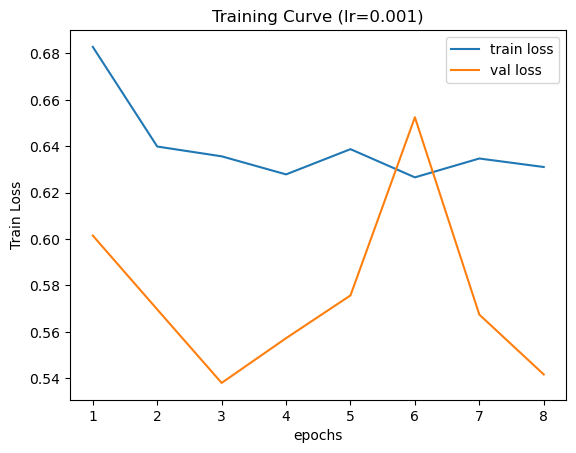

In [40]:
plt.plot(range(1, n_trained_epochs+1), train_avg_loss, label="train loss")
plt.plot(range(1, n_trained_epochs+1), val_avg_loss, label="val loss")
plt.title("Training Curve (lr={})".format(lr))
plt.xlabel("epochs")
plt.ylabel("Train Loss")
plt.legend(loc="best")
plt.show()

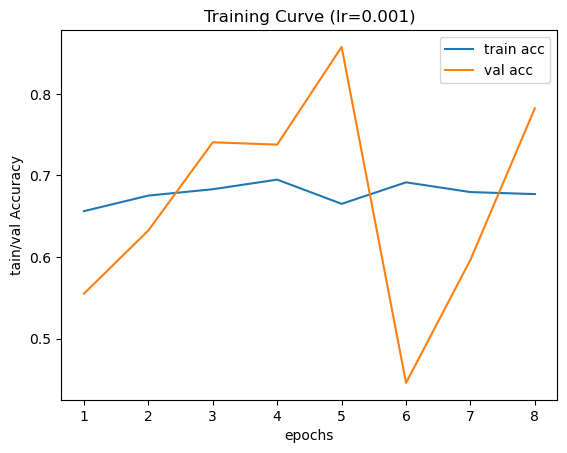

In [41]:
plt.plot(range(1, n_trained_epochs+1), train_avg_acc, label="train acc")
plt.plot(range(1, n_trained_epochs+1), val_avg_acc, label="val acc")
plt.title("Training Curve (lr={})".format(lr))
plt.xlabel("epochs")
plt.ylabel("tain/val Accuracy")
plt.legend(loc="best")
plt.show()

In [42]:
## saving the model - Early stopping did it here 
##torch.save(model.state_dict(), "finetuned-35-epochs-1e3-lr-with-weighted-loss.pth") # early stopping saves model

### Load the model 
- if train and wants to evaluate: jsut use the `sameModelName`
- if want to laod a specific model - use next cell and write in double quote

In [16]:
model_name = saveModelName

In [43]:
# loading the locally saved model


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CausalityBERT()
model.load_state_dict(torch.load(model_name))
## Move the model to the GPU 
model.to(device)
model.eval() # gettign in the eval mode 



You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing BertModel: ['roberta.encoder.layer.11.output.LayerNorm.weight', 'lm_head.decoder.bias', 'roberta.encoder.layer.1.intermediate.dense.bias', 'roberta.encoder.layer.9.attention.output.LayerNorm.weight', 'roberta.encoder.layer.8.output.dense.bias', 'roberta.encoder.layer.5.attention.output.LayerNorm.weight', 'roberta.encoder.layer.5.intermediate.dense.weight', 'roberta.encoder.layer.11.attention.output.dense.bias', 'roberta.encoder.layer.2.attention.self.key.weight', 'roberta.encoder.layer.7.attention.self.key.weight', 'roberta.encoder.layer.0.output.dense.weight', 'roberta.encoder.layer.9.attention.self.query.weight', 'roberta.encoder.layer.1.attention.self.key.bias', 'lm_head.decoder.weight', 'roberta.encoder.layer.4.output.LayerNorm.weight', 'robe

CausalityBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True

## evaluation on the test dataset 



In [44]:
#loss_fn = CrossEntropyLoss()
test_loss = []
test_acc = []
test_prec = []
test_rec = []
test_f1 = []


for batch in tqdm(test_loader):
    batch = tuple(batch[t].to(device) for t in batch)      # batch to GPU
    b_input_ids, b_input_mask, b_token_type_ids, b_labels = batch     # unpack inputs from dataloader

    with torch.no_grad():
        model.eval()
        logits = model(**{"input_ids":b_input_ids, "attention_mask":b_input_mask, "token_type_ids":b_token_type_ids}) # forward pass, calculates logit predictions 
    
    # move logits and labels to CPU
    logits = logits.detach().to('cpu').numpy()
    label_ids = b_labels.to('cpu').numpy()

    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()
    
    metrics = compute_metrics(pred_flat, labels_flat)
    test_acc.append(metrics["accuracy"])
    test_prec.append(metrics["precision"])
    test_rec.append(metrics["recall"])
    test_f1.append(metrics["f1"])

    
print(F'\n\ttest loss: {np.mean(test_loss)}')
print(F'\n\ttest acc: {np.mean(test_acc)}')
print(F'\n\ttest prec: {np.mean(test_prec)}')
print(F'\n\ttest rec: {np.mean(test_rec)}')
print(F'\n\ttest f1: {np.mean(test_f1)}')





  0%|          | 0/27 [00:00<?, ?it/s]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
  4%|▎         | 1/27 [00:01<00:40,  1.56s/it]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
  7%|▋         | 2/27 [00:03<00:38,  1.55s/it]<ipython-input-34-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
 11%|█         | 3/27 [00:04<00:37,  1.55s/it]<ipyt


	test loss: nan

	test acc: 0.7222222222222222

	test prec: 0.25931023708801487

	test rec: 0.5640652557319223

	test f1: 0.33834137231783096



/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Print predictions of last test set batch:

In [45]:
# take last batch of test set:

for i in range(len(batch)):
    tokens = tokenizer.convert_ids_to_tokens(b_input_ids[i])
    print("\nPadded Sentence:")
    print(tokens)
    print("prediction:", pred_flat[i])
    


Padded Sentence:
['<s>', 'I', "'", 'm', 'type', '2', 'diabetic', ',', 'I', 'measure', 'my', 'blood', 'sugar', 'with', 'a', 'monitor', '(', 'One', 'touch', ')', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
prediction: 1

Padded Sentence:
['<s>', 'Pretty', 'sure', 'he', 'is', '..', 'food', 'is', 'kinda', 'a', 'bid', 'deal', 'when', 'your', 'diabetic', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 